# Notes

* I've improved cross-validation accuracy from 79% to 83% by applying feature engineering. However, the test accuracy remains stuck at 77.5%.
    * The model is predicting that all men die - it is not able to distinguish men that survive, even on the training data. The model overestimates women surviving. I think that's why generalization is not much better than the gender model, and I think that means my model is too biased.
    * Potential causes: train-test distribution difference (like data drift), data leakage, overfitting
        * I don't think it's data leakage - I use pipelines for cross-validation
        * I don't think I'm overfitting to the validation data - I'm using cross-validation, and I see that validation performance for each fold is improving; it's not just the average across folds that's improving.
        * Train-test distributions are similar but not identical. It could be this, plus my model seems to be too biased (although increasing max_depth for the random forest only degrades cv performance).
    * Learning curves
        * Max depth = 5: too much bias
        * Max depth = 20: can learn, too much variance
        * With the tutorial's suggested features, the model cannot fit even when unconstrained. Bias is data-limited.
        * In all cases I tried, validation performance topped out at 84% - basically no improvement no matter what I tried. Adding regularization did not help; it only degraded the model's ability to fit. This suggests that there simply isn't enough training data.
        * You could try utilizing monotonic constraints but you will need to impute all missing values, plus it may not help much if at all
        * Did not try randomized search for the sake of time
    * Gradient boosting classifier doesn't improve performance
    * Decision tree classifier performance isn't that much worse - so it looks like random forest and gradient boosting tree is not providing much benefit
    * Next steps
        * I keep wondering about age imputation - try removing age entirely and see if performance degrades
        * Will model calibration help?
        * Do other models make different decisions?
            * Add Fare imputation - maybe a simple group-wise imputer by Pclass/AgeBin
            * Logreg, naive Bayes, GDA, SVM
        * Does tuning the decision threshold make sense for improving accuracy?
        * Try ensembling - before you do this, analyze the mistakes that your models are making. Ensembling models that make the same predictions may not help.
        * Data augmentation?
        * Are there any other features to play around with?
* Other things to look into
    * Feature selection, feature permutation for importance
    * Understand random forests and gradient boosting algorithms
    * Try using many different models for practice (this will require different kinds of preprocessing and feature engineering)
    * Use PCA to visualize the data points and decision boundary

# Load libraries and datasets

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score
import re

df_train = pd.read_csv("./dataset/train.csv")
df = df_train
df_test = pd.read_csv("./dataset/test.csv")

sns.set_style("whitegrid")

In [3]:
import custom_transformers, custom_scoring, utility_functions
from importlib import reload
reload(custom_transformers)
reload(custom_scoring)
reload(utility_functions)

<module 'utility_functions' from '/home/ryanwtsai/repos/ml_ai_portfolio/titanic/utility_functions.py'>

In [60]:
from custom_transformers import FamilySizeExtractor, TitleExtractor, DeckExtractor, SexPclassAgeExtractor, FareTransformer

to_drop = ["Survived", "PassengerId", "Ticket"]
to_drop = ["Survived", "PassengerId", "Ticket", "Cabin", "Parch", "SibSp", "Embarked"]
to_drop = ["Survived", "PassengerId", "Ticket", "Parch", "SibSp", "Embarked"]
fam_extractor = FamilySizeExtractor(max_famsize=4)
# fam_extractor = FamilySizeExtractor(max_famsize=3, to_drop=to_drop)
title_extractor = TitleExtractor()
# title_extractor = TitleExtractor(valid=["Mr", "Mrs", "Miss", "Master"])
deck_extractor = DeckExtractor()
# deck_extractor = DeckExtractor(to_replace={"C": "B", "D": "B", "E": "B", "G": "F"})
# deck_extractor = DeckExtractor(to_replace={"A": "A", "B": "A", "C": "A", "D": "A", "E": "A", "F": "A", "G": "A"})
sex_pclass_age_extractor = SexPclassAgeExtractor()

fare_transformer = FareTransformer()

data_prep = Pipeline([
    ("fam", fam_extractor),
    ("title", title_extractor),
    ("deck", deck_extractor),
    ("sex_pclass_age", sex_pclass_age_extractor),
    ("fare", fare_transformer),
])

df_out = data_prep.fit_transform(df.drop("Survived", axis=1, errors="ignore"))
df_out = pd.concat((df_out, df[["Survived"]]), axis=1)
df_out["AgeMissing"] = df_out.Age.isna()
# df_out[["Pclass", "Embarked", "Sex", "Title", "Deck", "AgeMissing", "FamilySize"]] = df_out[["Pclass", "Embarked", "Sex", "Title", "Deck", "AgeMissing", "FamilySize"]].astype("category")
df_out["AgeBin"] = ((np.floor(df_out["Age"]/5)+1)*5).astype("category")
df_out["FareBin"] = ((np.floor(df_out["Fare"]/10)+1)*10).astype("category")
# df_out = df_out.apply(sex_pclass_age_feature, axis=1)
# df_out["CabinMissing"] = df_out.Cabin.isna()

print(df_out.dtypes)
df_out.head()

PassengerId           int64
Pclass                int64
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Embarked             object
FamilySize            int64
Title                object
Deck                 object
SexPclassAge         object
FareTransformed     float64
Survived              int64
AgeMissing             bool
AgeBin             category
FareBin            category
dtype: object


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title,Deck,SexPclassAge,FareTransformed,Survived,AgeMissing,AgeBin,FareBin
0,1,3,male,22.0,1,0,A/5 21171,7.2500,S,1,Mr,U,"Male, P3, Age>15",0.860338,0,False,25.0,10.0
1,2,1,female,38.0,1,0,PC 17599,71.2833,C,1,Mrs,C,Other,1.852988,1,False,40.0,80.0
2,3,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,Miss,U,Other,0.898999,1,False,30.0,10.0
3,4,1,female,35.0,1,0,113803,53.1000,S,1,Mrs,C,Other,1.725095,1,False,40.0,60.0
4,5,3,male,35.0,0,0,373450,8.0500,S,0,Mr,U,"Male, P3, Age>15",0.905796,0,False,40.0,10.0


In [975]:
from custom_transformers import DynamicDataPrepPipeline

data_prep_pipe = DynamicDataPrepPipeline(
    extract_fam=True, fam_kwargs={"max_famsize": 4},
    extract_deck=True, deck_kwargs={"to_replace": {"G": "F"}},
    extract_title=True, title_kwargs={"valid": ["Mr", "Miss", "Mrs", "Master", "Rev"]},
    extract_sexpclassage=True,
    transform_fare=True,
)

X_in = df.drop("Survived", axis=1, errors="ignore")
data_prep_pipe.fit(X_in)
X = data_prep_pipe.transform(X_in)
print(data_prep_pipe.get_feature_names_out())
print(X.shape)

['num__Age' 'num__Pclass' 'num__Fare' 'num__FamilySize'
 'num__FareTransformed' 'onehot__Title_Master' 'onehot__Title_Miss'
 'onehot__Title_Mr' 'onehot__Title_Mrs' 'onehot__Title_Rev'
 'onehot__Title_Unknown' 'onehot__SexPclassAge_Male, P3, 5<Age<=15'
 'onehot__SexPclassAge_Male, P3, Age<=5'
 'onehot__SexPclassAge_Male, P3, Age>15' 'onehot__SexPclassAge_Other'
 'ord_sex__Sex' 'ord_deck__Deck']
(891, 17)


# Univariate

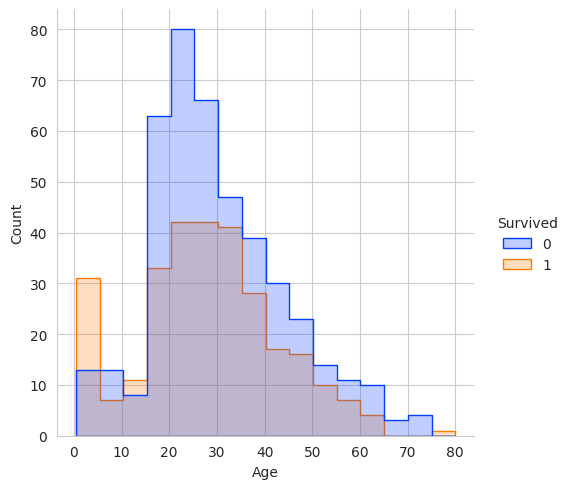

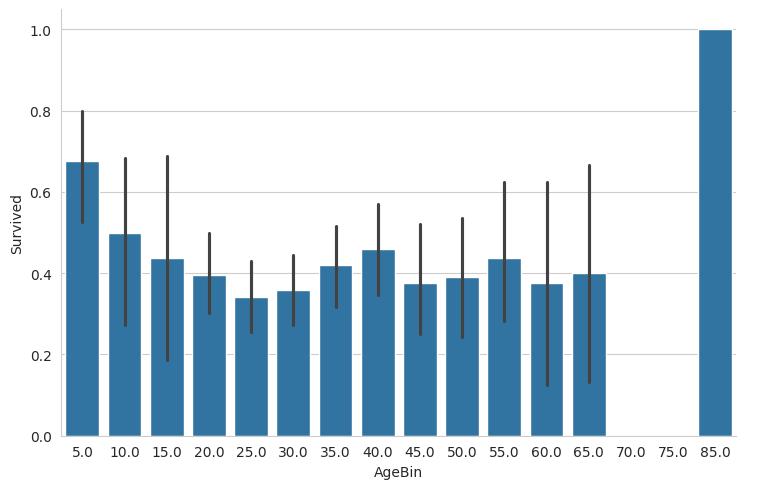

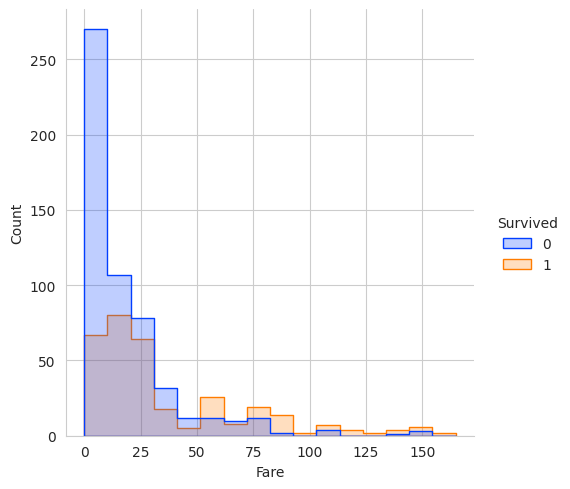

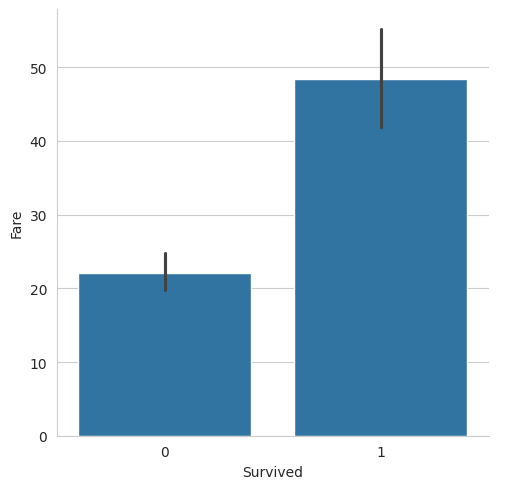

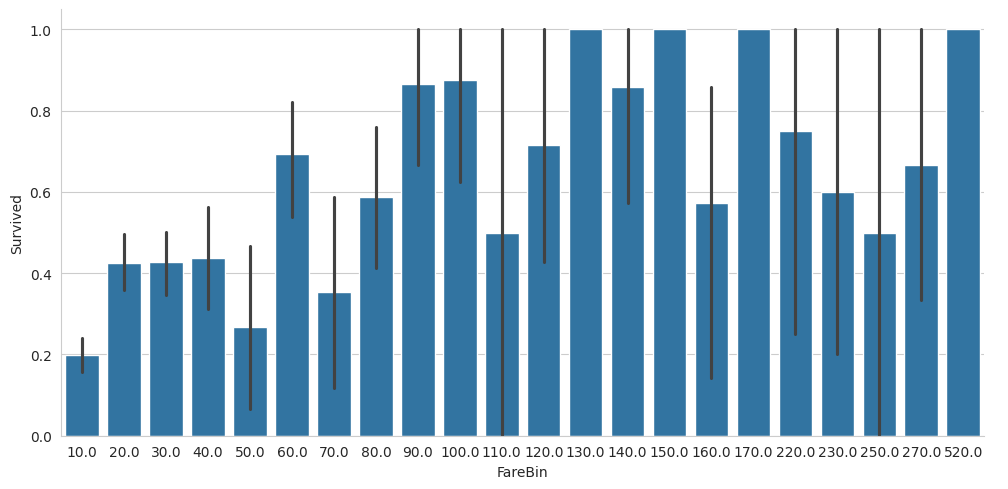

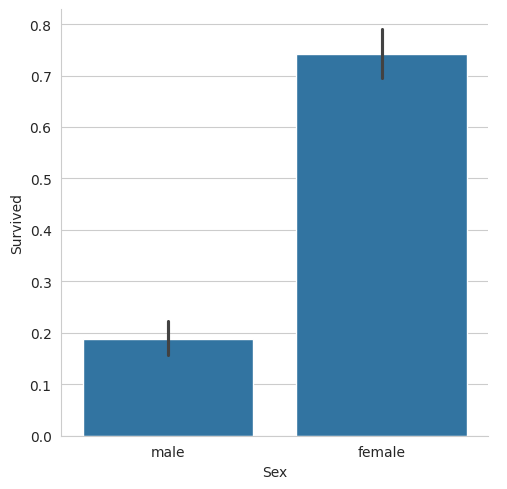

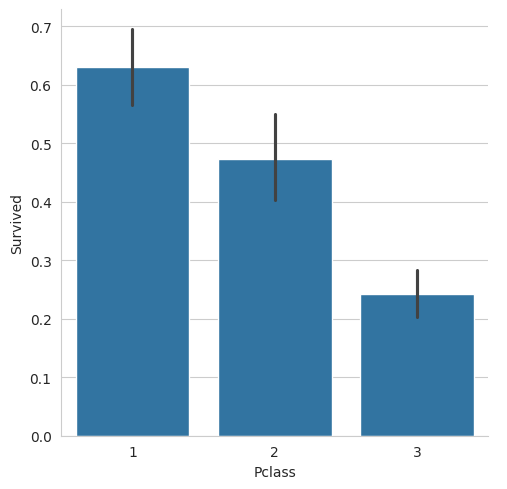

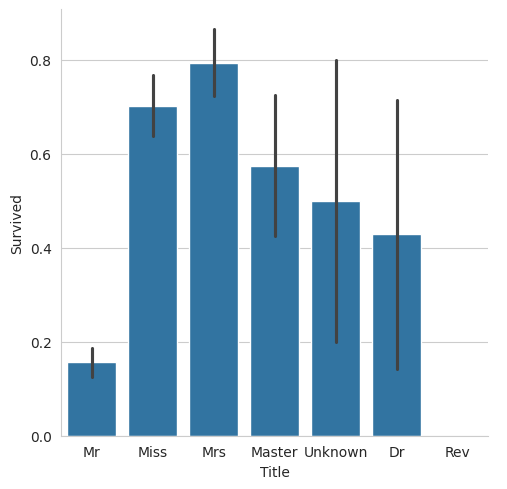

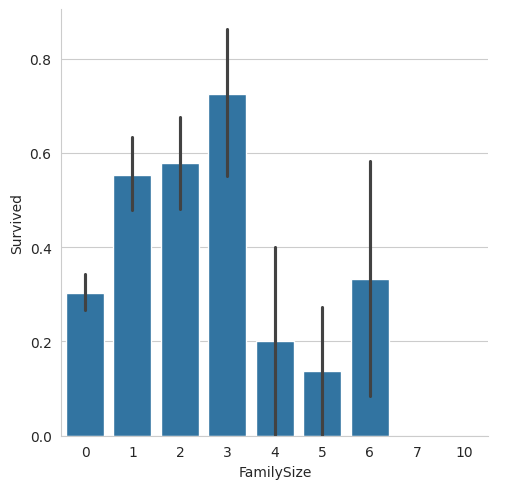

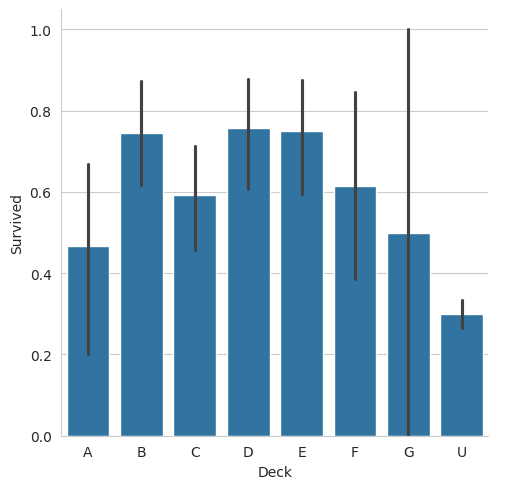

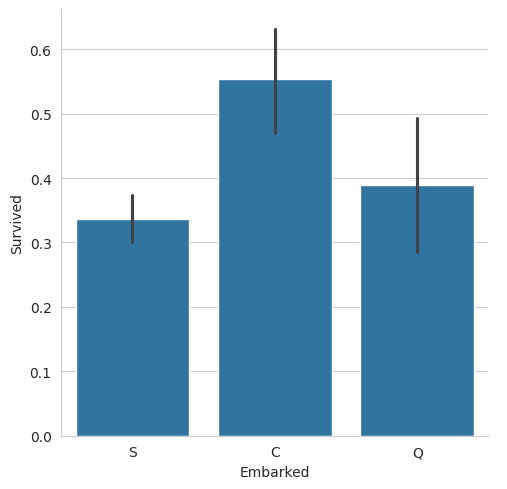

In [808]:
g = sns.displot(df_out, x="Age", hue="Survived", element="step", binwidth=5, palette="bright")
g = sns.catplot(df_out, x="AgeBin", y="Survived", kind="bar", aspect=1.5)
# g = sns.catplot(df_out, x="AgeMissing", y="Survived", kind="bar")
g = sns.displot(df_out.loc[df["Fare"] < 200], x="Fare", hue="Survived", binwidth=10, palette="bright", element="step")
g = sns.catplot(df_out, x="Survived", y="Fare", kind="bar")
g = sns.catplot(df_out, x="FareBin", y="Survived", kind="bar", aspect=2)
g = sns.catplot(df_out, x="Sex", y="Survived", kind="bar")
g = sns.catplot(df_out, x="Pclass", y="Survived", kind="bar")
g = sns.catplot(df_out, x="Title", y="Survived", kind="bar", order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, x="FamilySize", y="Survived", kind="bar")
# g = sns.displot(df_out, x="FamilySize", hue="Survived", element="step", discrete=True, palette="bright")
# g = sns.catplot(df_out, x="SibSp", y="Survived", kind="bar")
# g = sns.catplot(df_out, x="Parch", y="Survived", kind="bar")
g = sns.catplot(df_out, x="Deck", y="Survived", kind="bar", order=sorted(df_out.Deck.unique()))
g = sns.catplot(df_out, x="Embarked", y="Survived", kind="bar", order=df_out.Embarked.value_counts().sort_values(ascending=False).index)

## Age/Fare transformations

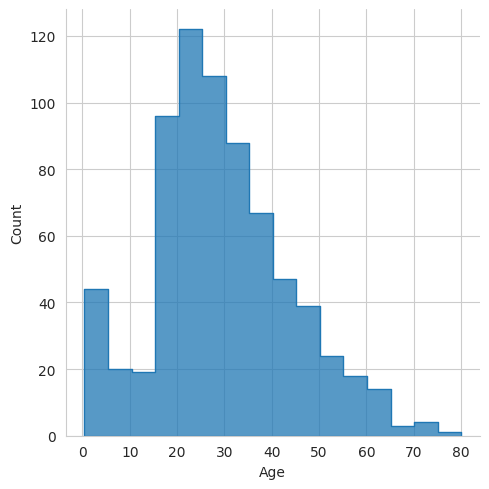

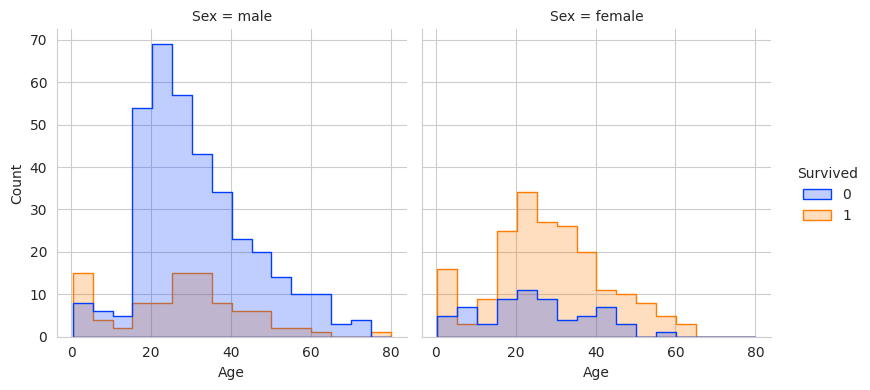

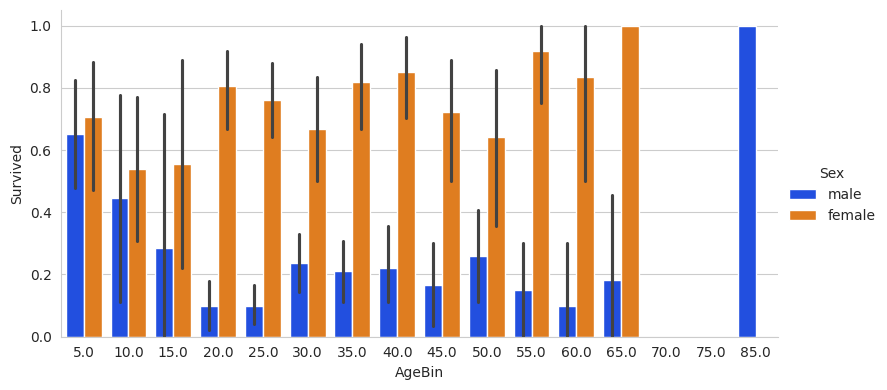

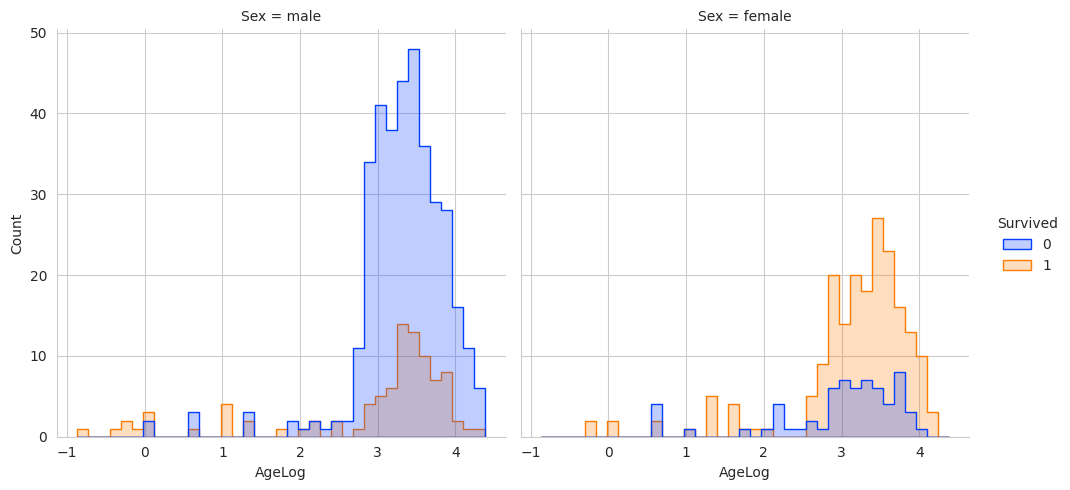

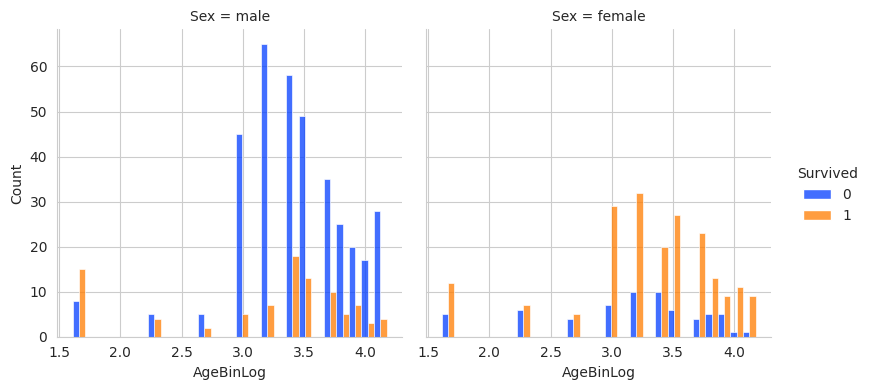

In [ ]:
# Transformation params: binwidth, clip, enable log transform (it should be after binning if binning is enabled)
# Before taking log, you may want to clip lower to 1
# For age, try binwidth=5, clip=65. If you bin and make the bins ordinal, it doesn't make sense to also log. If you keep numeric, then maybe it makes sense to take log.
# Perhaps just bin and clip and keep numeric?

binwidth = 5

df_out["AgeLog"] = np.log(df_out["Age"])
df_out["AgeBinLog"] = df_out["AgeBin"].astype("float")
df_out["AgeBinLog"] = np.log(df_out["AgeBinLog"].clip(upper=65))

g = sns.displot(df_out, kind="hist", x="Age", binwidth=binwidth, element="step")
g = sns.displot(df_out, kind="hist", x="Age", hue="Survived", col="Sex", binwidth=binwidth, palette="bright", element="step", height=4)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", hue="Sex", palette="bright", height=4, aspect=2)
g = sns.displot(df_out, kind="hist", x="AgeLog", hue="Survived", element="step", col="Sex", palette="bright")
g = sns.displot(df_out, kind="hist", x="AgeBinLog", hue="Survived", palette="bright", multiple="dodge", col="Sex", height=4)
# g = sns.catplot(df_out, kind="bar", x="AgeBinLog", y="Survived", hue="Sex", palette="bright", aspect=2)

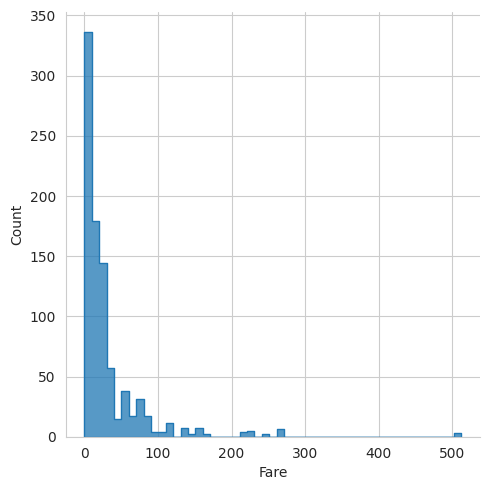

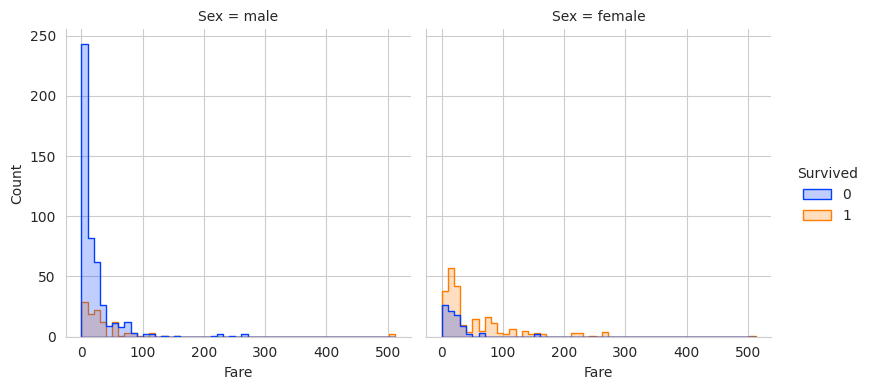

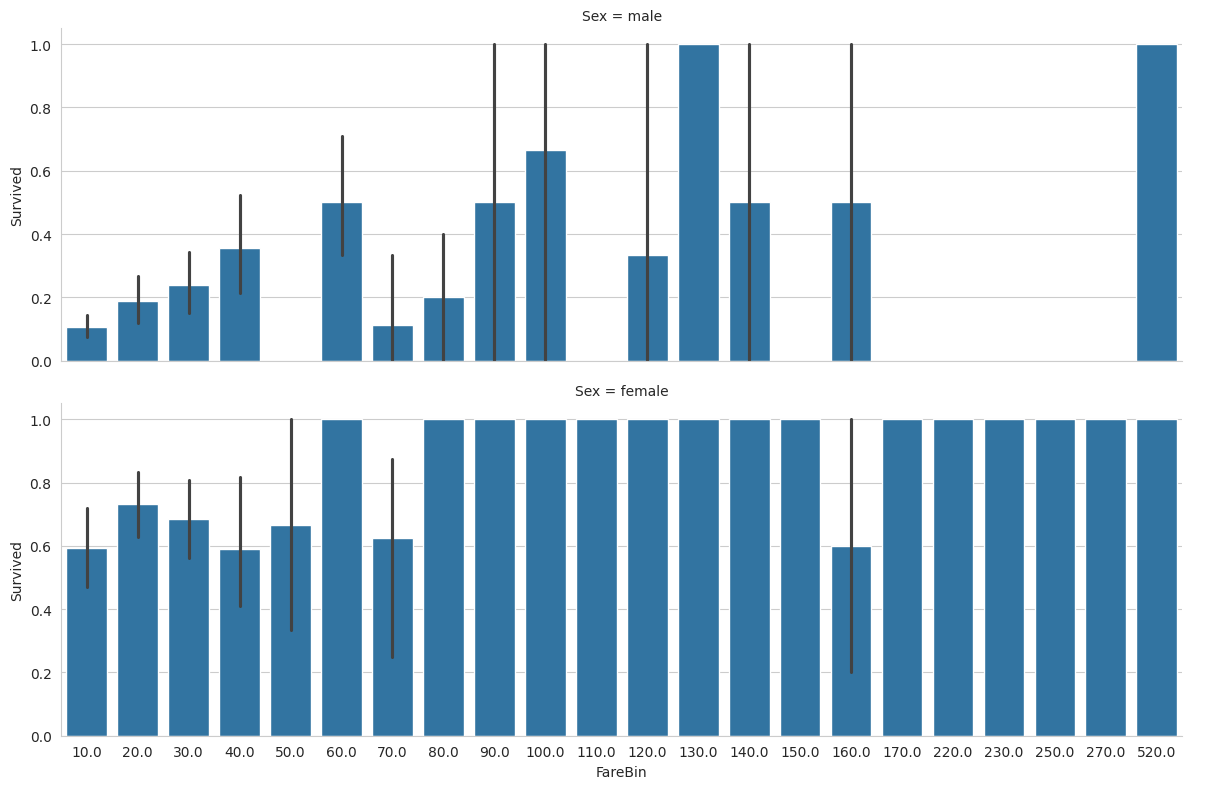

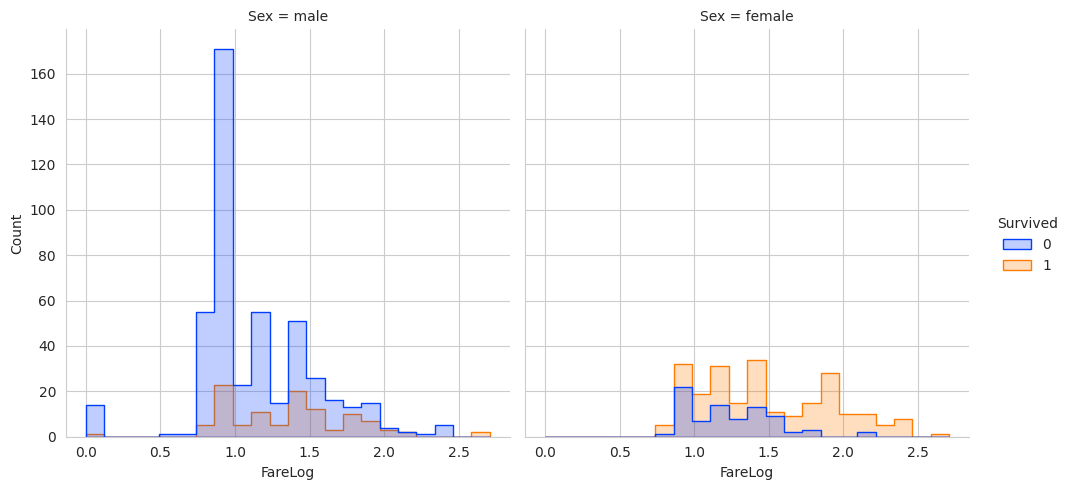

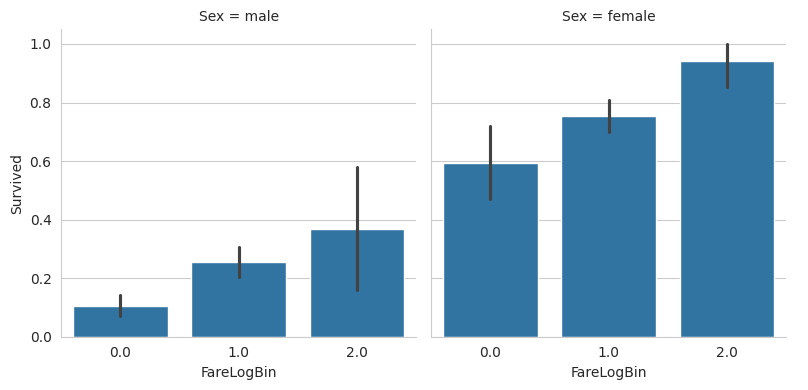

In [957]:
binwidth = 10

base = 10

df_out["FareLog"] = np.log10(df_out["Fare"].clip(lower=1))/np.log10(base)
df_out["FareLogBin"] = np.floor(np.log10(df_out["Fare"].clip(lower=1))/np.log10(base)).astype("category")
# df_out["FareBinLog"] = df_out["FareBin"].astype("float")
# df_out["FareBinLog"] = np.log(df_out["FareBinLog"].clip(upper=None))

g = sns.displot(df_out, kind="hist", x="Fare", binwidth=binwidth, element="step")
g = sns.displot(df_out, kind="hist", x="Fare", hue="Survived", col="Sex", binwidth=binwidth, palette="bright", element="step", height=4)
# g = sns.catplot(df_out, kind="bar", x="FareBin", y="Survived", hue="Sex", palette="bright", height=4, aspect=3)
g = sns.catplot(df_out, kind="bar", x="FareBin", y="Survived", row="Sex", height=4, aspect=3)
g = sns.displot(df_out, kind="hist", x="FareLog", hue="Survived", element="step", col="Sex", palette="bright")
g = sns.catplot(df_out, kind="bar", x="FareLogBin", y="Survived", col="Sex", height=4)
# g = sns.displot(df_out, kind="hist", x="FareBinLog", hue="Survived", palette="bright", multiple="dodge", col="Sex", height=4)

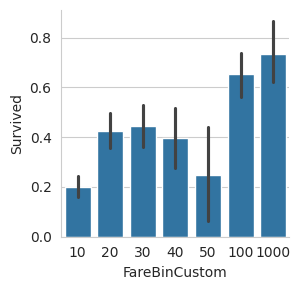

In [952]:
def custom_fare_bin(x):
    x = np.clip(x, a_min=0, a_max=1000)
    bins = np.array([10, 20, 30, 40, 50, 100, 1000])
    return bins[np.argmax(x <= bins)]

df_out["FareBinCustom"] = df_out["Fare"].map(custom_fare_bin).astype("category")
g = sns.catplot(df_out, kind="bar", x="FareBinCustom", y="Survived", height=3)

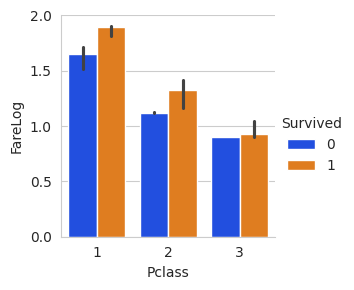

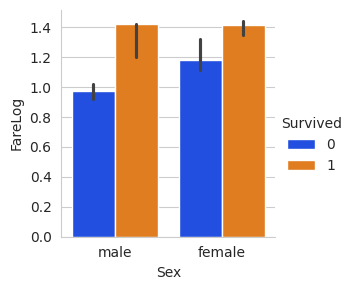

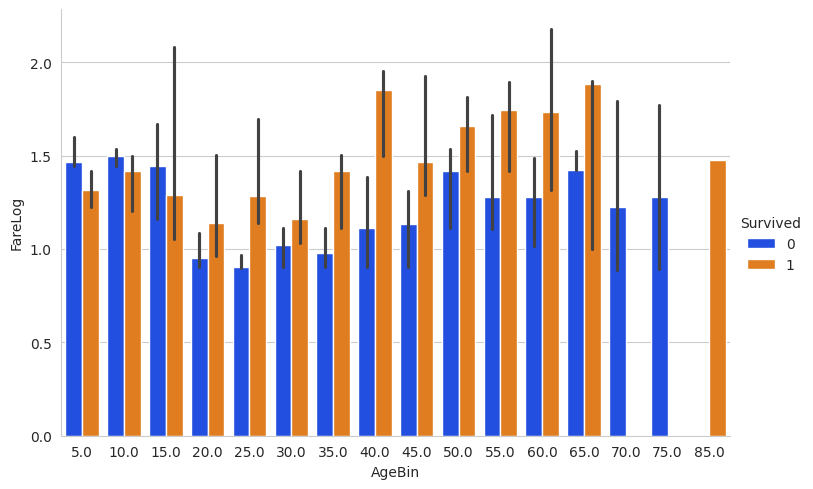

In [969]:
g = sns.catplot(df_out, kind="bar", x="Pclass", y="FareLog", estimator="median", hue="Survived", palette="bright", height=3) # Using median reduces outlier effect
g = sns.catplot(df_out, kind="bar", x="Sex", y="FareLog", estimator="median", hue="Survived", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="FareLog", estimator="median", hue="Survived", palette="bright", aspect=1.5)

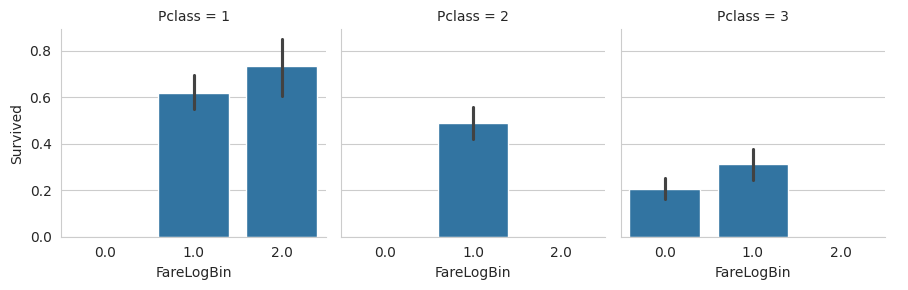

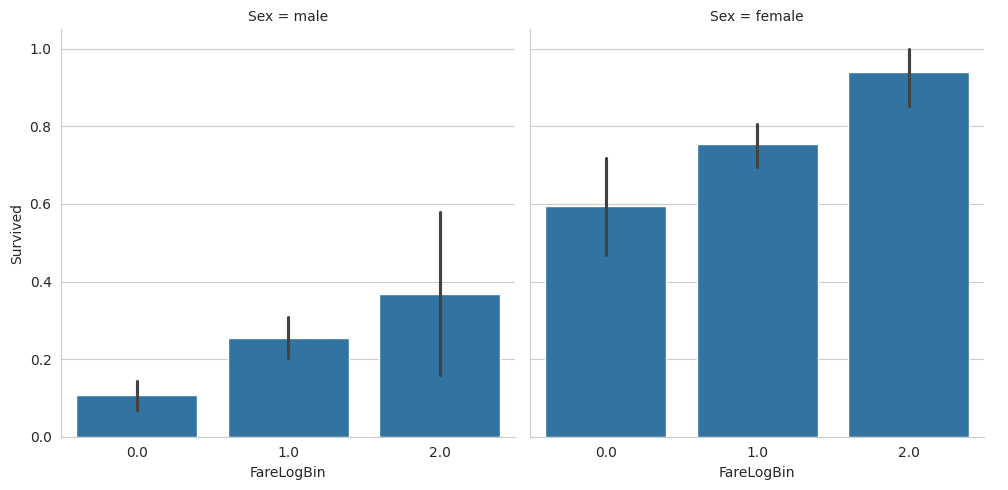

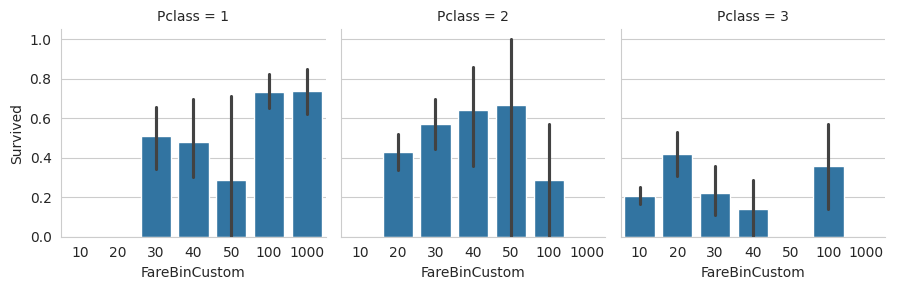

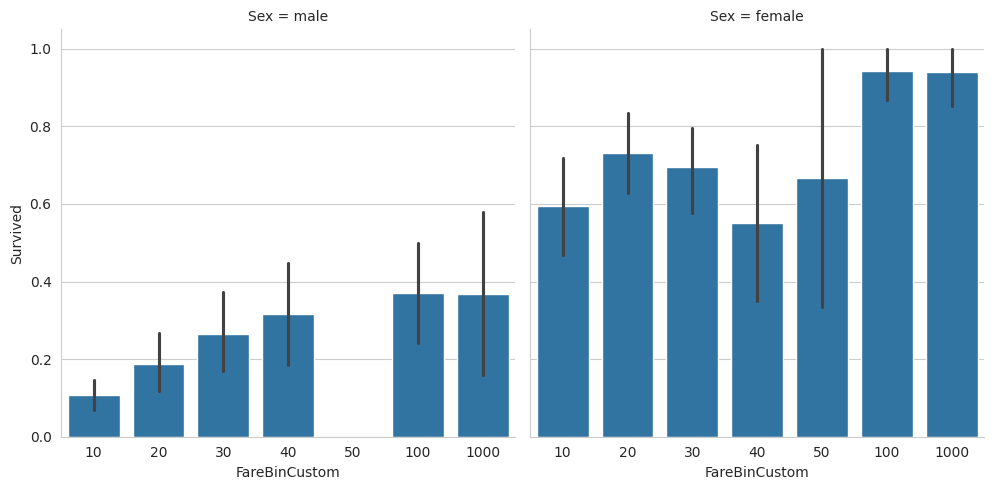

In [ ]:
g = sns.catplot(df_out, kind="bar", x="FareLogBin", y="Survived", col="Pclass", height=3)
g = sns.catplot(df_out, kind="bar", x="FareLogBin", y="Survived", col="Sex")
g = sns.catplot(df_out, kind="bar", x="FareBinCustom", y="Survived", col="Pclass", height=3)
g = sns.catplot(df_out, kind="bar", x="FareBinCustom", y="Survived", col="Sex")

# Multivariate

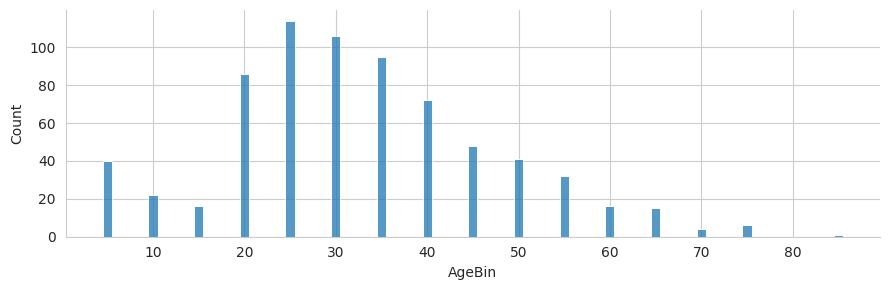

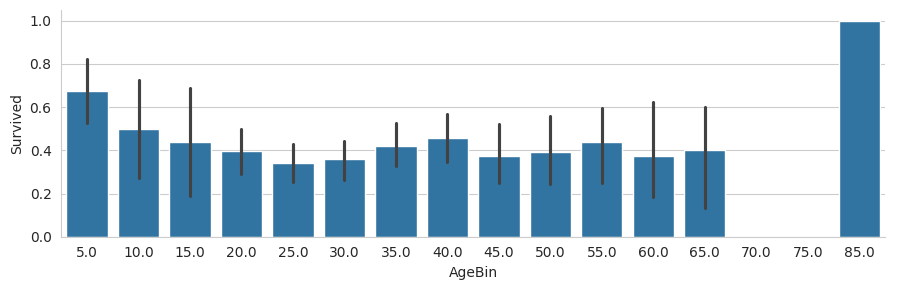

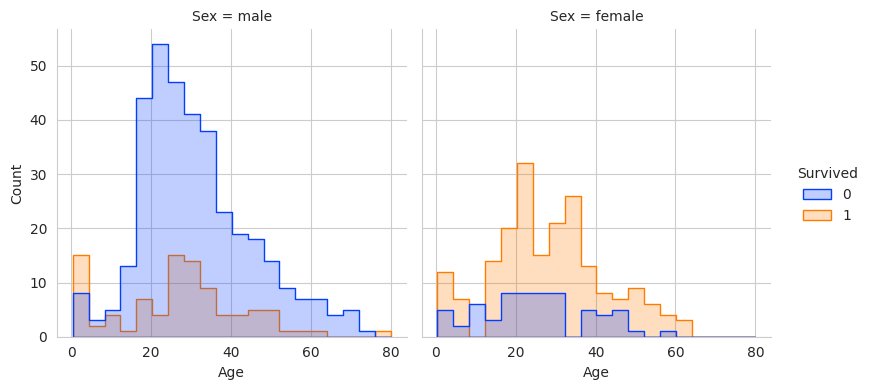

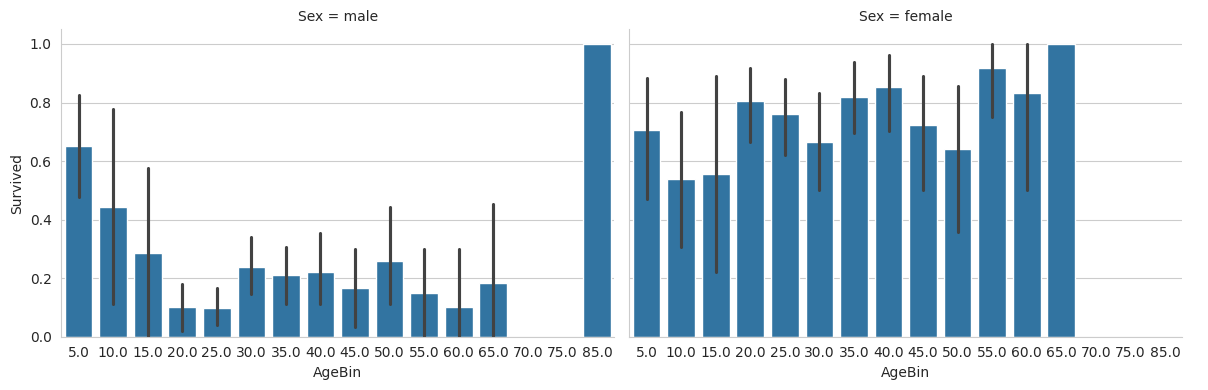

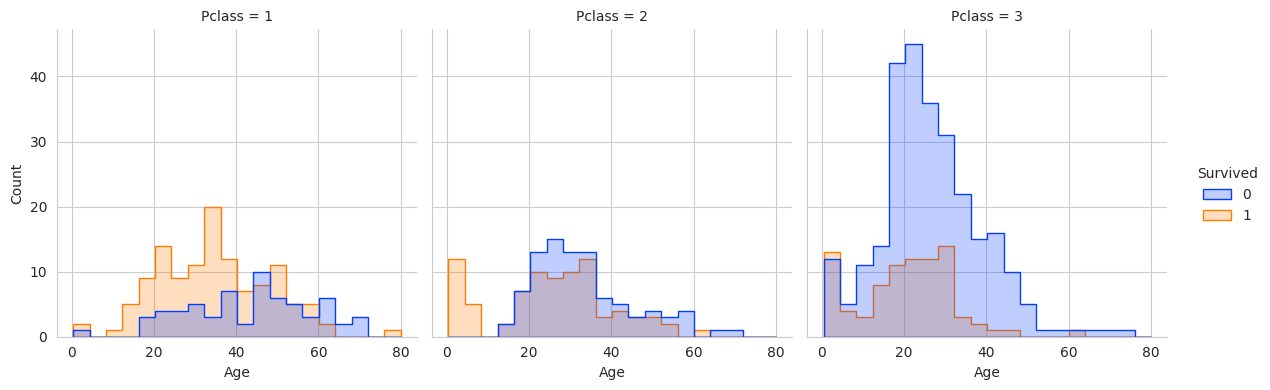

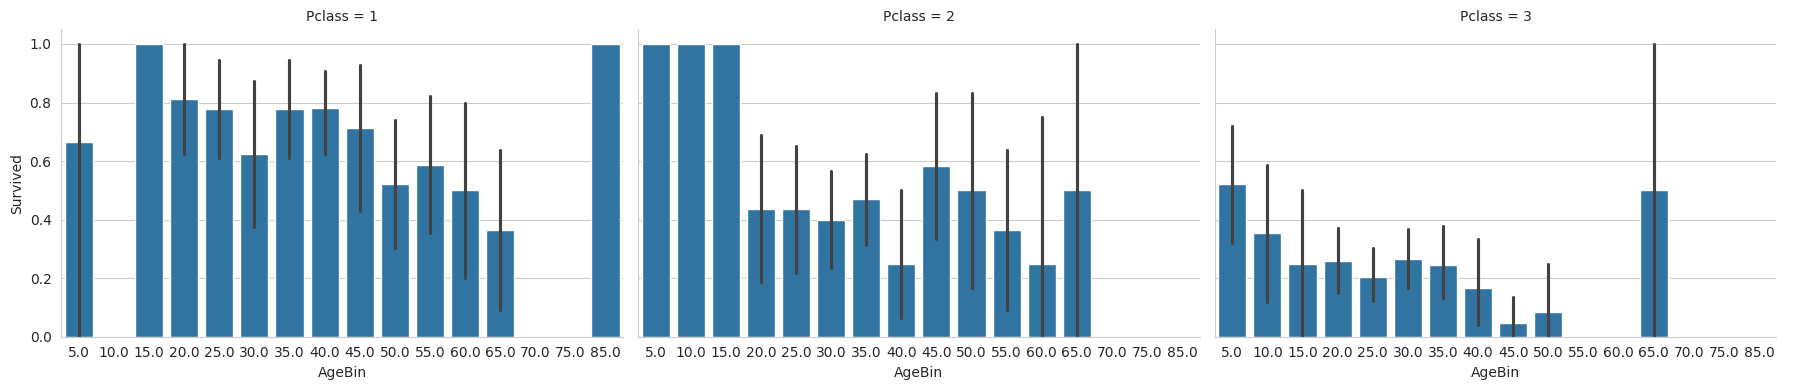

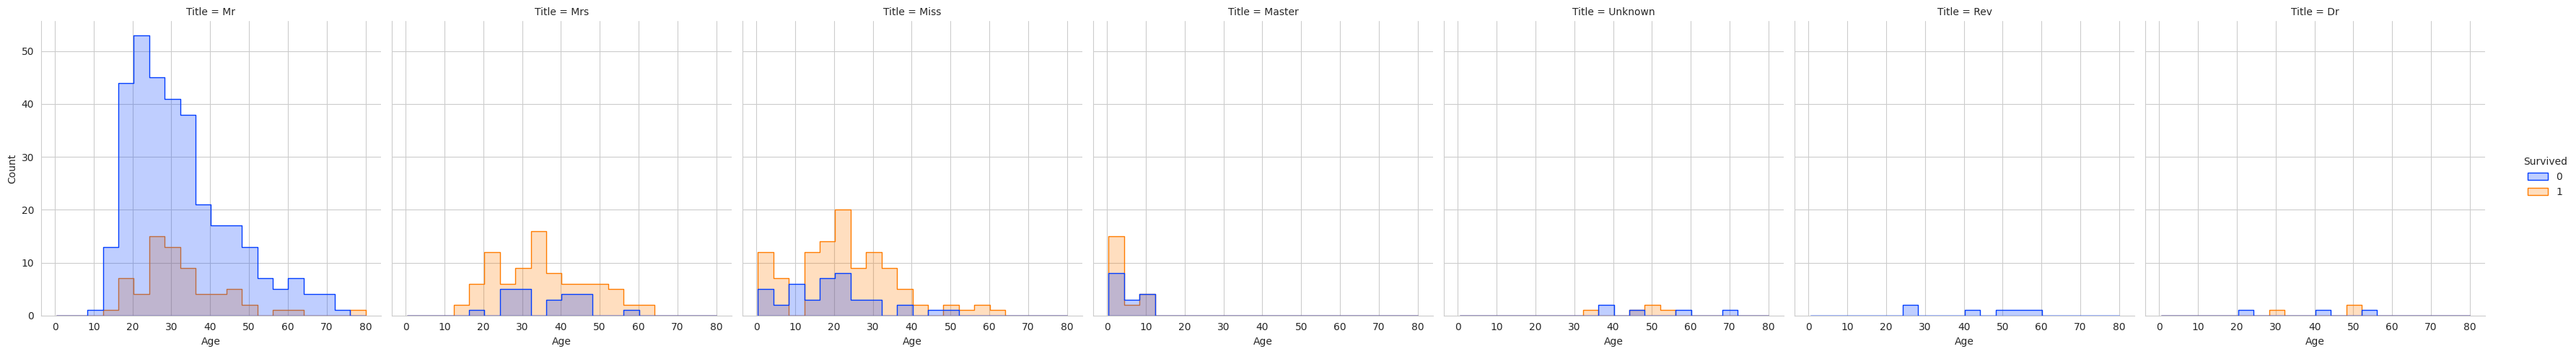

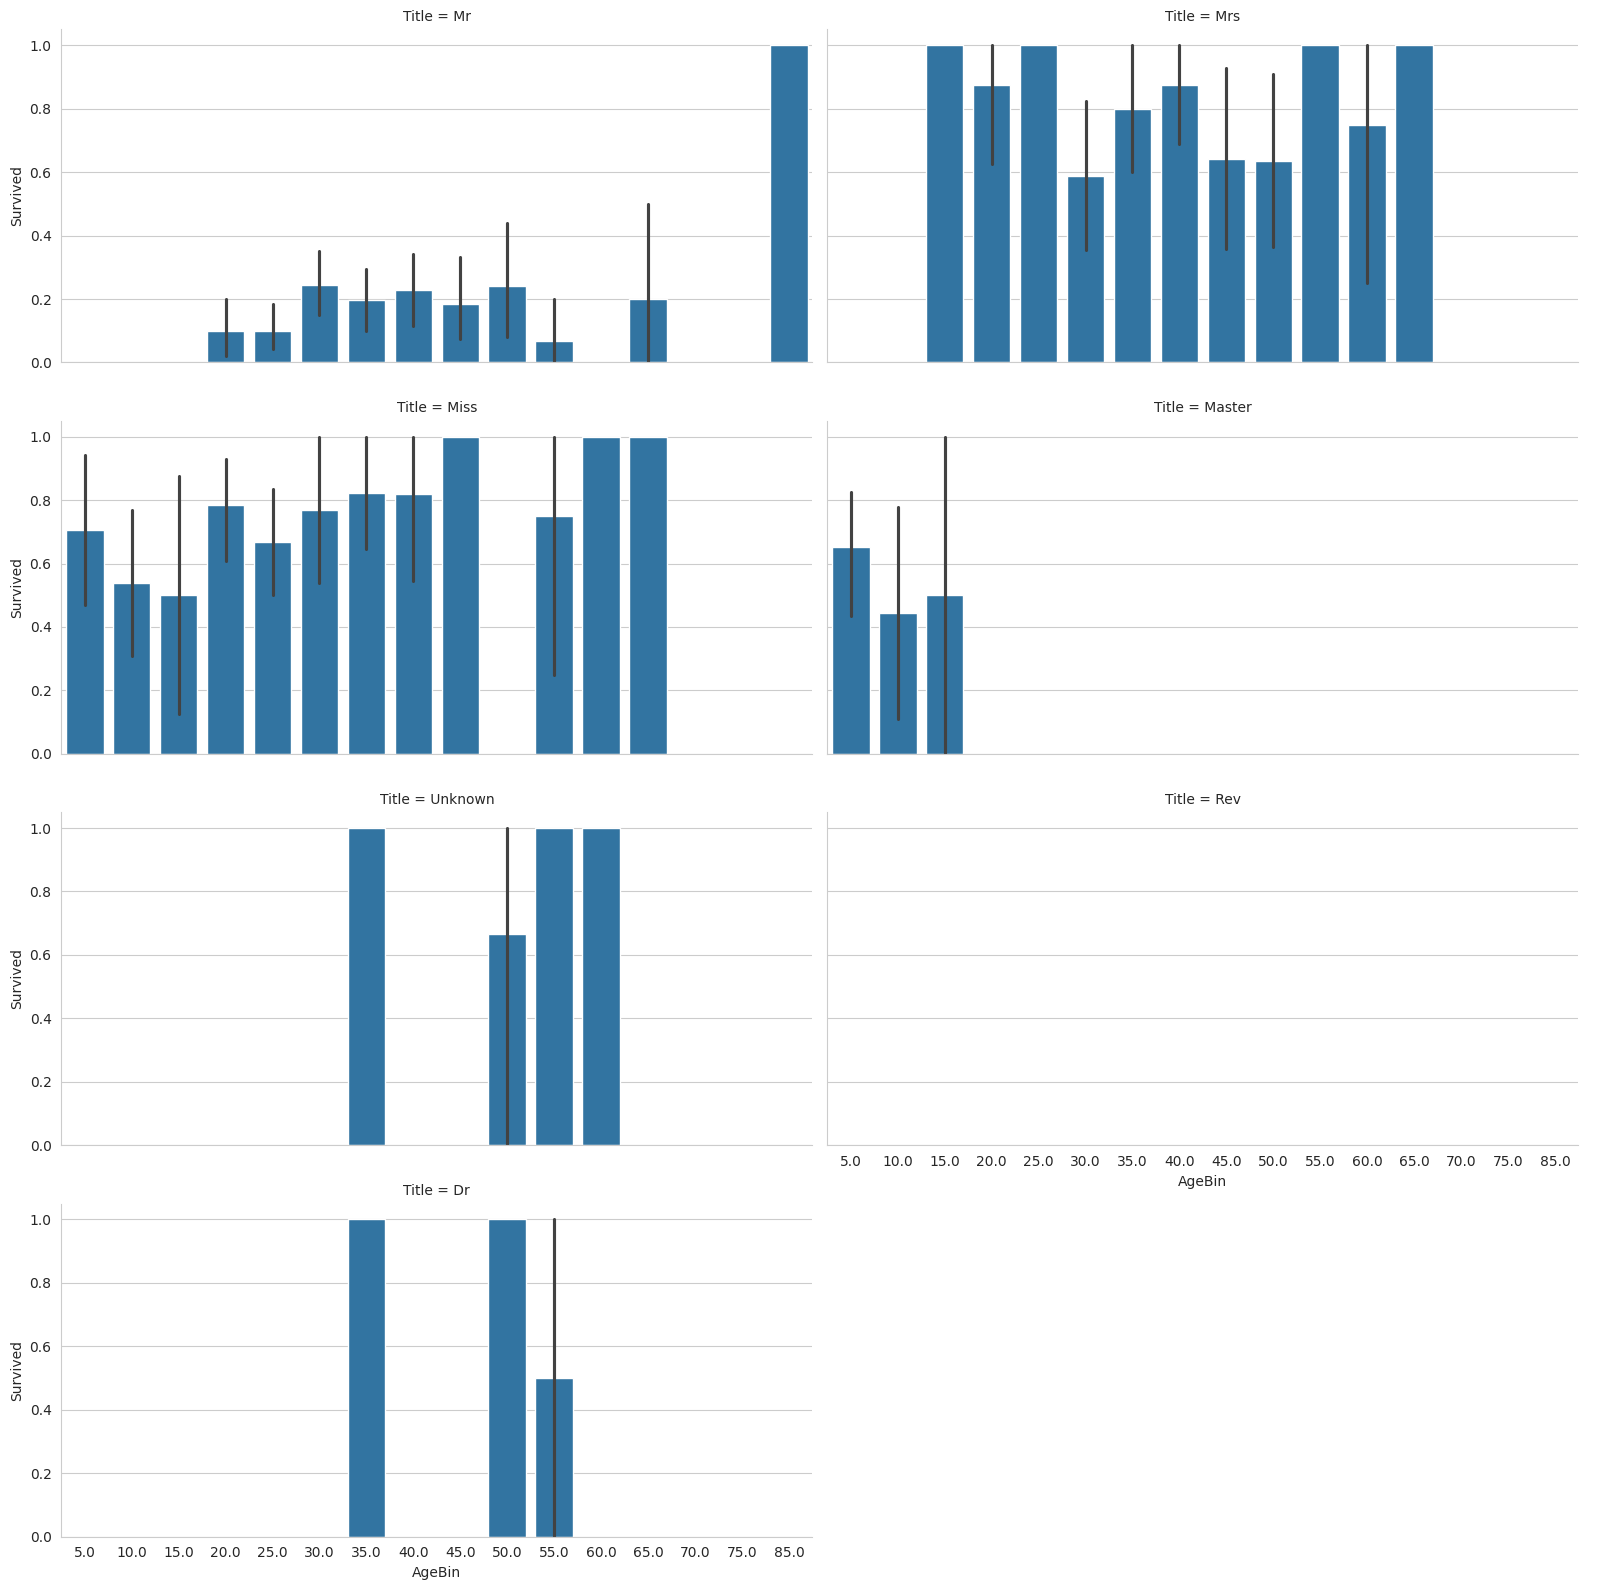

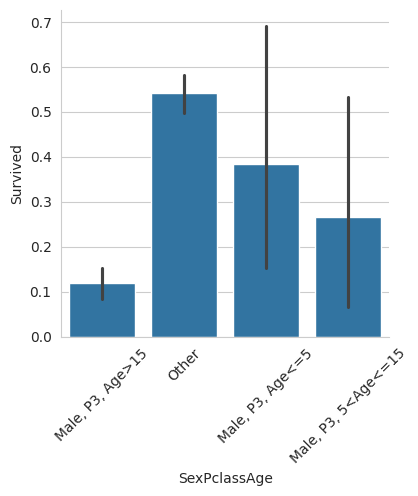

In [ ]:
# Ah, To Be Young

g = sns.displot(df_out, kind="hist", x="AgeBin", discrete=True, height=3, aspect=3)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", height=3, aspect=3)
# g = sns.catplot(df_out, kind="bar", x="Survived", y="Age", estimator="median", height=4)
# g = sns.catplot(df_out, kind="boxen", x="Survived", y="Age", height=4)
# g = sns.displot(df_out, kind="hist", x="Age", hue="Sex", col="Survived", height=4, palette="bright", element="step")
g = sns.displot(df_out, kind="hist", x="Age", hue="Survived", palette="bright", col="Sex", element="step", height=4) # Survived vs. Age, controlling for Sex
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", col="Sex", height=4, aspect=1.5) # Survived vs. Age, controlling for Sex
g = sns.displot(df_out, kind="hist", x="Age", hue="Survived", palette="bright", col="Pclass", element="step", height=4)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", col="Pclass", height=4, aspect=1.5)
g = sns.displot(df_out, kind="hist", x="Age", col="Title", hue="Survived", element="step", palette="bright")
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", height=4, col="Title", aspect=2, col_wrap=2)
g = sns.catplot(df_out, kind="bar", x="SexPclassAge", y="Survived", height=4)
g.ax.tick_params(axis="x", labelrotation=45)

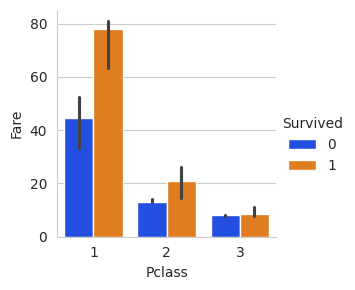

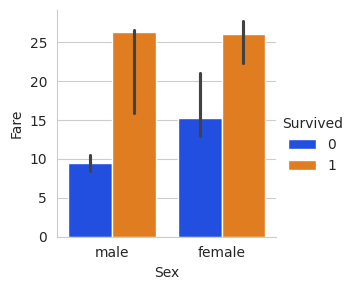

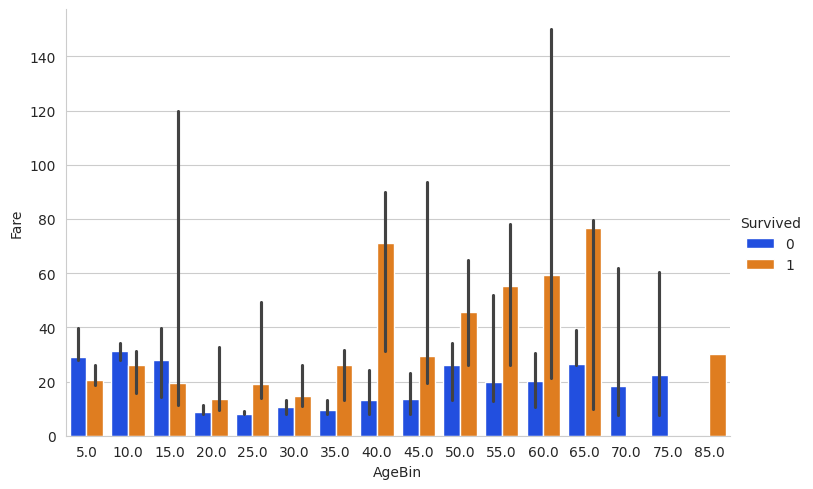

In [956]:
# Life Is Pay 2 Win

# Controlling for Pclass, does Fare affect survival? Yes, big difference in median (which is important when considering tree splits)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Fare", estimator="median", hue="Survived", palette="bright", height=3) # Using median reduces outlier effect
g = sns.catplot(df_out, kind="bar", x="Sex", y="Fare", estimator="median", hue="Survived", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Fare", estimator="median", hue="Survived", palette="bright", aspect=1.5)

In [ ]:
# The Fairer Sex

g = sns.catplot(df_out, kind="bar", x="AgeBin", y="Survived", hue="Sex", palette="bright", height=3, aspect=2)
g = sns.catplot(df_out, kind="bar", x="FareBin", y="Survived", hue="Sex", palette="bright", height=3, aspect=3)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Sex", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Survived", hue="Sex", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="Deck", y="Survived", hue="Sex", palette="bright", height=3)
g = sns.catplot(df_out, kind="bar", x="Embarked", y="Survived", hue="Sex", palette="bright", height=3)

In [ ]:
# Priority Passenger, Coming Through!

g = sns.catplot(df_out, kind="bar", y="Survived", x="AgeBin", hue="Pclass", palette="bright", height=4, aspect=3)
g = sns.catplot(df_out, kind="bar", y="Survived", x="FareBin", hue="Pclass", palette="bright", height=4, aspect=3)
g = sns.catplot(df_out, kind="bar", y="Survived", x="Sex", hue="Pclass", palette="bright", height=4)
g = sns.catplot(df_out, kind="bar", y="Survived", x="Title", hue="Pclass", palette="bright", height=4)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.catplot(df_out, kind="bar", y="Survived", x="FamilySize", hue="Pclass", palette="bright", height=4)

Deck  Pclass
A     1          22
B     1          65
C     1          94
D     1          40
      2           6
E     1          34
      2           4
      3           3
F     2          13
      3           8
G     3           5
U     1          68
      2         254
      3         693
Name: count, dtype: int64


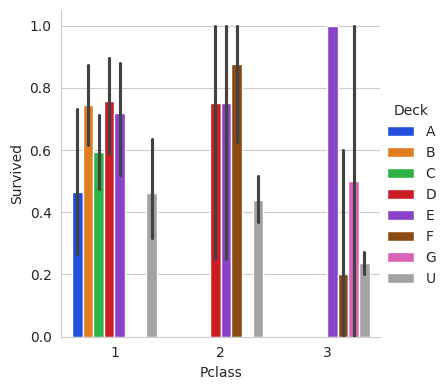

In [771]:
# Living large at the top

print(df_out.groupby(["Deck"]).Pclass.value_counts(normalize=False).sort_index())
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Deck", palette="bright", height=4, hue_order=sorted(df_out.Deck.unique()))

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64
Embarked  Pclass
C         1         0.522222
          2         0.103704
          3         0.374074
Q         1         0.024390
          2         0.056911
          3         0.918699
S         1         0.193654
          2         0.264770
          3         0.541575
Name: proportion, dtype: float64


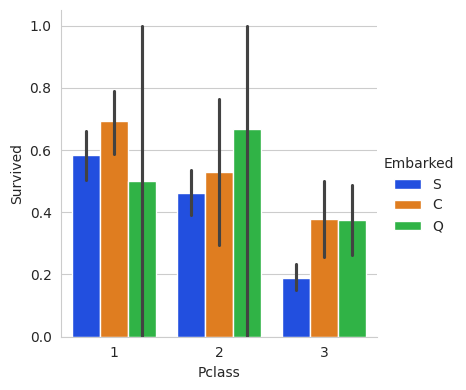

In [ ]:
# The bourgeoisie comes from Cherbourg

print(df_out.Embarked.value_counts().sort_values(ascending=False))
print(df_out.groupby("Embarked").Pclass.value_counts(normalize=True).sort_index())
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Embarked", palette="bright", height=4, hue_order=df_out.Embarked.value_counts().sort_values(ascending=False).index)

In [ ]:
# Excuse Me, Miss

print(df_out.Title.value_counts().sort_values(ascending=False))
g = sns.catplot(df_out, kind="bar", x="Title", y="Survived", height=3, order=df_out.Title.value_counts().sort_values(ascending=False).index)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.catplot(df_out.loc[df_out["FareBin"] < 50], kind="bar", x="FareBin", y="Survived", hue="Title", palette="bright", height=4, aspect=1.5, hue_order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, kind="bar", x="Sex", y="Survived", hue="Title", palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="Survived", hue="Title", palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Survived", hue="Title", palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index, aspect=3)
g = sns.catplot(df_out, kind="bar", x="Deck", y="Survived", hue="Title", 
                palette="bright", hue_order=df_out.Title.value_counts().sort_values(ascending=False).index, 
                order=sorted(df_out.Deck.unique()), aspect=3)

FamilySize
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64


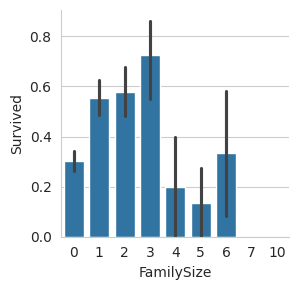

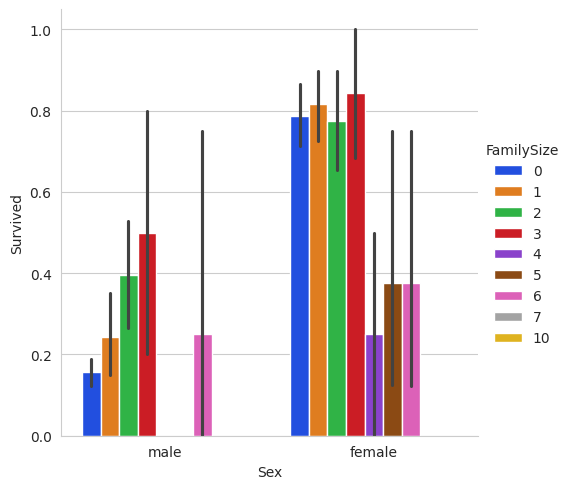

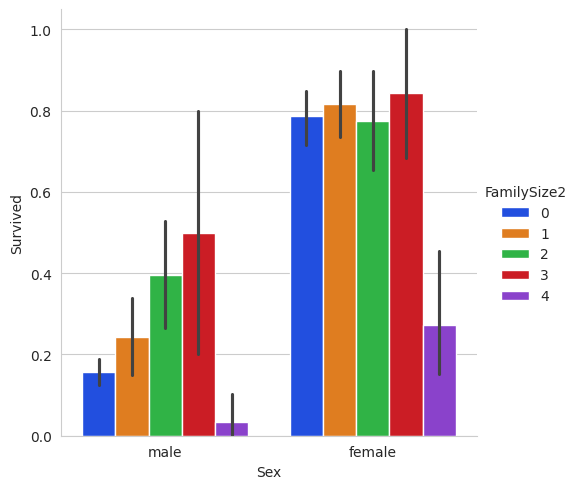

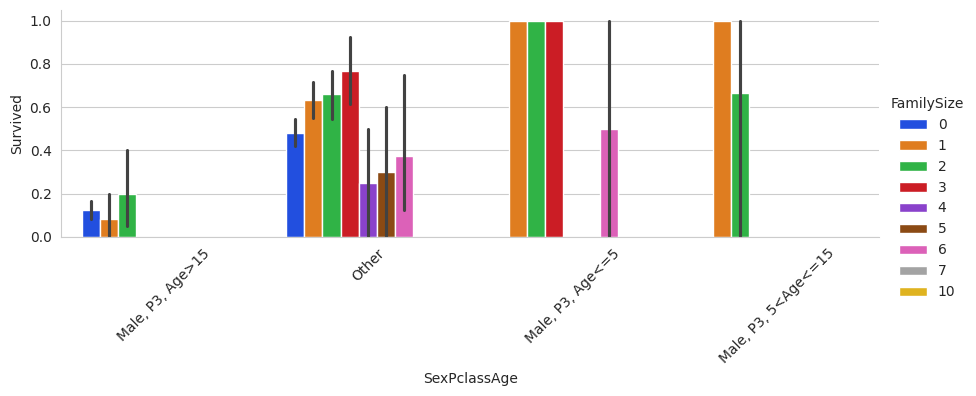

In [430]:
# Man + Small Family = Dead. Large Family? Also Dead.

print(df_out.FamilySize.value_counts().sort_index())
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Survived", height=3)
# print(df_out.groupby("Sex").FamilySize.value_counts().sort_index())
g = sns.catplot(df_out, kind="bar", x="Sex", y="Survived", hue="FamilySize", palette="bright")
df_out["FamilySize2"] = df_out["FamilySize"].clip(upper=4)
g = sns.catplot(df_out, kind="bar", x="Sex", y="Survived", hue="FamilySize2", palette="bright")
g = sns.catplot(df_out, kind="bar", x="SexPclassAge", y="Survived", hue="FamilySize", palette="bright", height=3, aspect=3)
g.ax.tick_params(axis="x", labelrotation=45)

# Who's Missing?

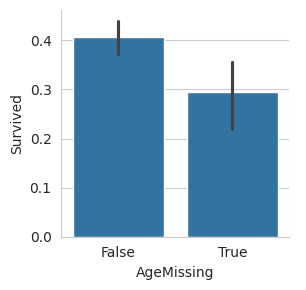

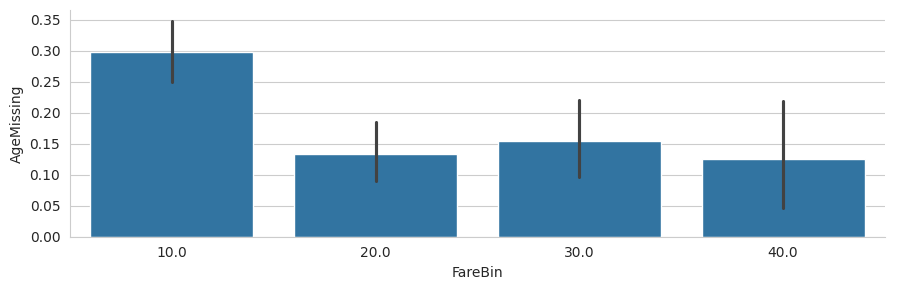

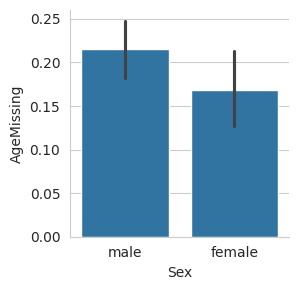

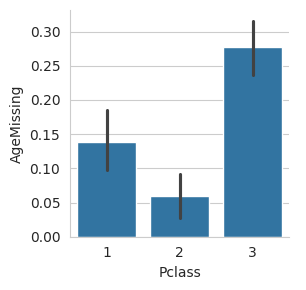

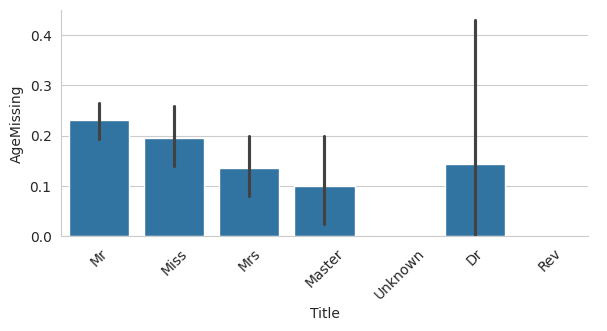

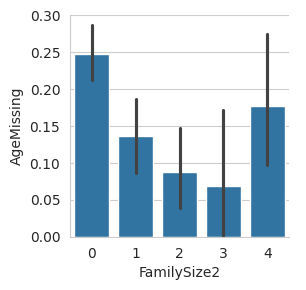

In [ ]:
# Age missing? You're dead.
# Age missing is probably covered by other features.

g = sns.catplot(df_out, kind="bar", x="AgeMissing", y="Survived", height=3)
g = sns.catplot(df_out.loc[df_out["FareBin"] < 50], kind="bar", x="FareBin", y="AgeMissing", height=3, aspect=3)
g = sns.catplot(df_out, kind="bar", x="Sex", y="AgeMissing", height=3)
g = sns.catplot(df_out, kind="bar", x="Pclass", y="AgeMissing", height=3)
g = sns.catplot(df_out, kind="bar", x="Title", y="AgeMissing", height=3, aspect=2, order=df_out.Title.value_counts().sort_values(ascending=False).index)
g.ax.tick_params(axis="x", labelrotation=45)
df_out["FamilySize2"] = df_out["FamilySize"].clip(upper=4)
g = sns.catplot(df_out, kind="bar", x="FamilySize2", y="AgeMissing", height=3)

## Predicting Age

* When training a model to predict Age, should you clip Age to 65? Hard to say. Not sure if it'll affect the survival prediction much.
* No pattern from Fare
* Sex doesn't matter too much on its own, but there's a bigger difference w/FamilySize interaction. In large families, the women tend to be older.
* Larger family (clipped at 4) = younger
* More siblings = younger (stronger predictor than family size)
* Higher class = older
* Title makes a big difference

Features to use: Sex, FamilySize, SibSp, Pclass, Title

I'm thinking my AgeImputer should take care of encoding the features and then drop after. Who cares if it takes more time. Much easier if it's standalone.

Can RandomForestRegressor predict/split based on median? If mean only, should I clip or transform Age so it's not so skewed?

Assess imputation:
* Try a different model, e.g. SVR
* Run model on training data and check training performance - turns out FareTransformed does have a big impact on MAE
* Check which groups are missing and estimate which ages should be filled in (e.g. group-wise imputation)
    * Mostly singles
    * Mr/Male: Pclass 1 (40-45), Pclass 2 (30-35), Pclass 3 (25-30)
    * Miss/Female: Pclass 3 (20-25)
* Check distributions before and after, check conditional distributions before and after

In [294]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from custom_transformers import DynamicDataPrepPipeline

model = RandomForestRegressor(max_depth=10, n_estimators=100, criterion="squared_error", random_state=0)

# model = DecisionTreeRegressor(random_state=0)
age_imputer_pipe = DynamicDataPrepPipeline(
    extract_fam=True, extract_title=True,
    age_imputer_model=model, impute_age_kwargs={"add_indicator": True, "feature_names": {"numeric": {"FamilySize", "SibSp", "Pclass", "FareTransformed"}, "ordinal": {"Sex"}, "onehot": {"Title"}}},
)

age_imputer_pipe.fit(df)
df_out = age_imputer_pipe.feature_extractor_.transform(df)
df_out["AgeOG"] = df["Age"].copy()

count    714.000000
mean       6.225612
std        5.479816
min        0.000160
25%        2.274223
50%        4.847371
75%        8.745887
max       44.669277
Name: MAE, dtype: float64

0.50     4.847371
0.75     8.745887
0.90    13.372395
0.95    15.986369
0.99    27.135901
Name: MAE, dtype: float64



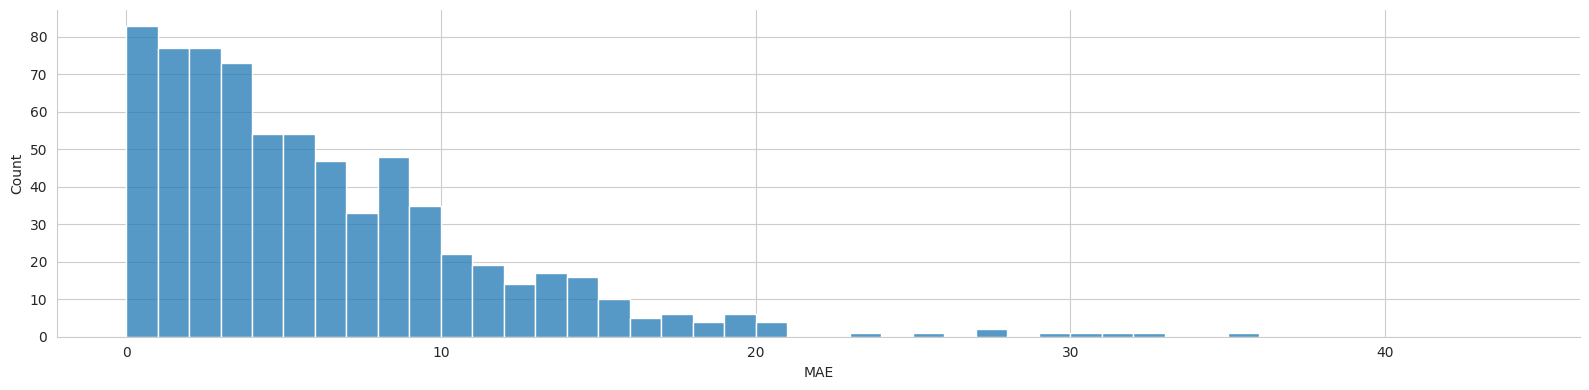

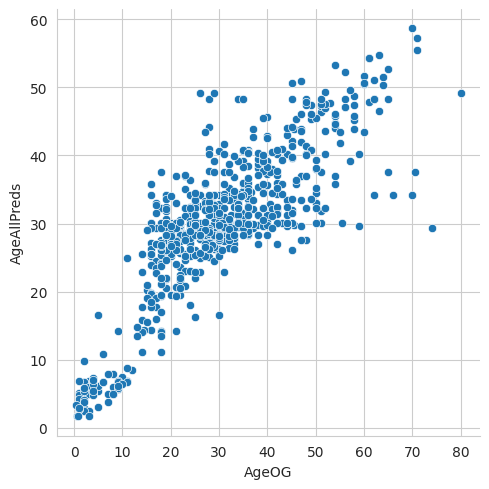

In [295]:
y_preds = age_imputer_pipe.feature_extractor_.named_steps["age_imputer"].pipeline_.predict(df_out)

df_all_preds = df_out.copy()
df_all_preds["AgeAllPreds"] = y_preds
df_all_preds["MAE"] = df_all_preds["AgeOG"]
not_missing_mask = df_all_preds["MAE"].notna()
df_all_preds.loc[not_missing_mask, "MAE"] = np.abs(df_all_preds.loc[not_missing_mask, "AgeOG"] - df_all_preds.loc[not_missing_mask, "AgeAllPreds"])

print(df_all_preds["MAE"].describe())
print("")
print(df_all_preds["MAE"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))
print("")
g = sns.displot(df_all_preds, kind="hist", x="MAE", height=4, aspect=4, bins=range(0,np.ceil(df_all_preds["MAE"].max()).astype("int").item()))
g = sns.relplot(df_all_preds.loc[not_missing_mask], kind="scatter", x="AgeOG", y="AgeAllPreds")

In [283]:
df_all_preds.sort_values(by="MAE", ascending=False).head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title,FareTransformed,Age_Missing,AgeOG,AgeAllPreds,MAE
851,852,0,3,male,74.0,0,0,347060,7.7750,S,0,Mr,0.890700,False,74.0,25.282,48.718
672,673,0,2,male,70.0,0,0,C.A. 24580,10.5000,S,0,Mr,1.021189,False,70.0,30.120,39.880
630,631,1,1,male,80.0,0,0,27042,30.0000,S,0,Mr,1.477121,False,80.0,42.325,37.675
33,34,0,2,male,66.0,0,0,C.A. 24579,10.5000,S,0,Mr,1.021189,False,66.0,30.120,35.880
94,95,0,3,male,59.0,0,0,364500,7.2500,S,0,Mr,0.860338,False,59.0,25.642,33.358
116,117,0,3,male,70.5,0,0,370369,7.7500,Q,0,Mr,0.889302,False,70.5,38.347,32.153
570,571,1,2,male,62.0,0,0,S.W./PP 752,10.5000,S,0,Mr,1.021189,False,62.0,30.120,31.880
152,153,0,3,male,55.5,0,0,A.5. 11206,8.0500,S,0,Mr,0.905796,False,55.5,28.767,26.733
280,281,0,3,male,65.0,0,0,336439,7.7500,Q,0,Mr,0.889302,False,65.0,38.347,26.653
771,772,0,3,male,48.0,0,0,350047,7.8542,S,0,Mr,0.895102,False,48.0,24.697,23.303


In [241]:
# Check outliers

iqr_times_1p5 = df_out.AgeOG.quantile([0.25, 0.75]).diff().iloc[1]*1.5

print([(df_out.AgeOG.quantile([0.25])-iqr_times_1p5).iloc[0].item(), 
       (df_out.AgeOG.quantile([0.75])+iqr_times_1p5).iloc[0].item()])

iqr_times_1p5 = df_out.Age.quantile([0.25, 0.75]).diff().iloc[1]*1.5

print([(df_out.Age.quantile([0.25])-iqr_times_1p5).iloc[0].item(), 
       (df_out.Age.quantile([0.75])+iqr_times_1p5).iloc[0].item()])

# df_out.loc[df_out.Age > (df_out.Age.quantile([0.75])+iqr_times_1p5).iloc[0].item()]
# df_out.query("Age > 60").sort_values(by="Survived", ascending=False)

[-6.6875, 64.8125]
[-1.5, 58.5]


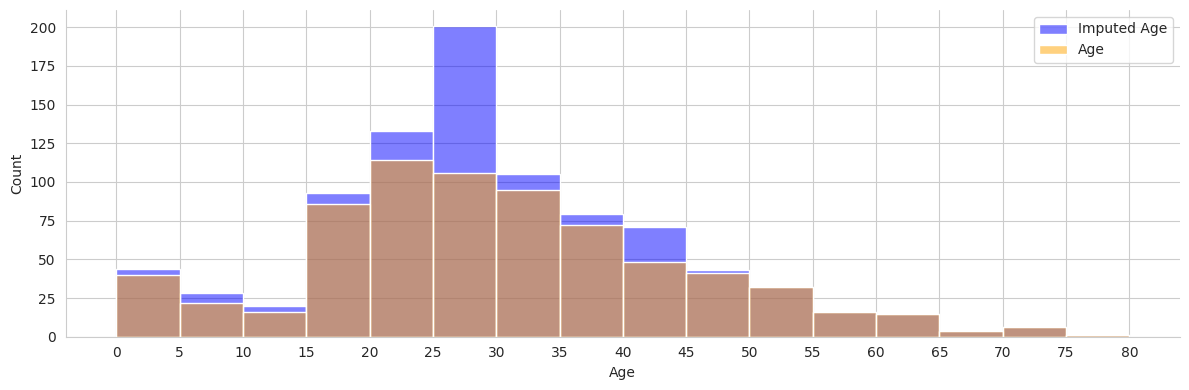

In [242]:
g = sns.displot(df_out, kind="hist", x="Age", bins=range(0, 85, 5), height=4, aspect=3, color="blue", alpha=0.5, label="Imputed Age")
ax = sns.histplot(df_out, x="AgeOG", bins=range(0, 85, 5), ax=g.ax, color="orange", alpha=0.5, label="Age")
_ = ax.set_xticks(range(0, 85,5))
_ = ax.legend()

In [193]:
print(df_out[["Fare", "Age", "AgeOG"]].corr())
print("")

           Fare       Age     AgeOG
Fare   1.000000  0.104666  0.096067
Age    0.104666  1.000000  1.000000
AgeOG  0.096067  1.000000  1.000000



In [ ]:
g = sns.relplot(df_out, kind="scatter", x="Fare", y="Age", alpha=0.5, height=3)
g = sns.catplot(df_out, kind="boxen", x="Sex", y="Age", height=3)
g = sns.catplot(df_out, kind="bar", x="Sex", y="Age", height=3)
g = sns.displot(df_out, kind="hist", x="Age", hue="Sex", palette="bright", element="step", height=3, stat="probability", common_norm=False)
g = sns.catplot(df_out, kind="boxen", x="Pclass", y="Age", height=3)
g = sns.displot(df_out, kind="hist", x="Age", hue="Pclass", palette="bright", element="step", height=4, stat="probability", common_norm=False)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Age", height=4)
g = sns.catplot(df_out, kind="boxen", x="FamilySize", y="Age", height=4)
g = sns.catplot(df_out, kind="bar", x="FamilySize", y="Age", hue="Sex", palette="bright", height=4)
g = sns.catplot(df_out, kind="boxen", x="FamilySize", y="Age", hue="Sex", palette="bright", height=4)
g = sns.catplot(df_out, kind="bar", x="SibSp", y="Age", height=4)
g = sns.catplot(df_out, kind="boxen", x="SibSp", y="Age", height=4)
g = sns.catplot(df_out, kind="bar", x="SibSp", y="Age", height=4, hue="Sex", palette="bright")
g = sns.catplot(df_out, kind="boxen", x="SibSp", y="Age", height=4, hue="Sex", palette="bright")
# g = sns.catplot(df_out, kind="bar", x="Parch", y="Age", height=4)
# g = sns.catplot(df_out, kind="boxen", x="Parch", y="Age", height=4)
g = sns.catplot(df_out, kind="boxen", x="Title", y="Age", height=4)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.catplot(df_out, kind="bar", x="Title", y="Age", height=4)
g.ax.tick_params(axis="x", labelrotation=45)
g = sns.displot(df_out, kind="ecdf", x="Age", hue="Title", palette="bright", height=4)

          Age                                                                \
        count       mean        std   min        25%        50%   75%   max   
Sex                                                                           
female  314.0  27.350413  13.681982  0.75  18.994552  26.000000  36.0  63.0   
male    577.0  30.735654  13.496472  0.42  23.000000  29.235196  37.0  80.0   

        AgeOG                                                      
        count       mean        std   min   25%   50%   75%   max  
Sex                                                                
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0  
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0  



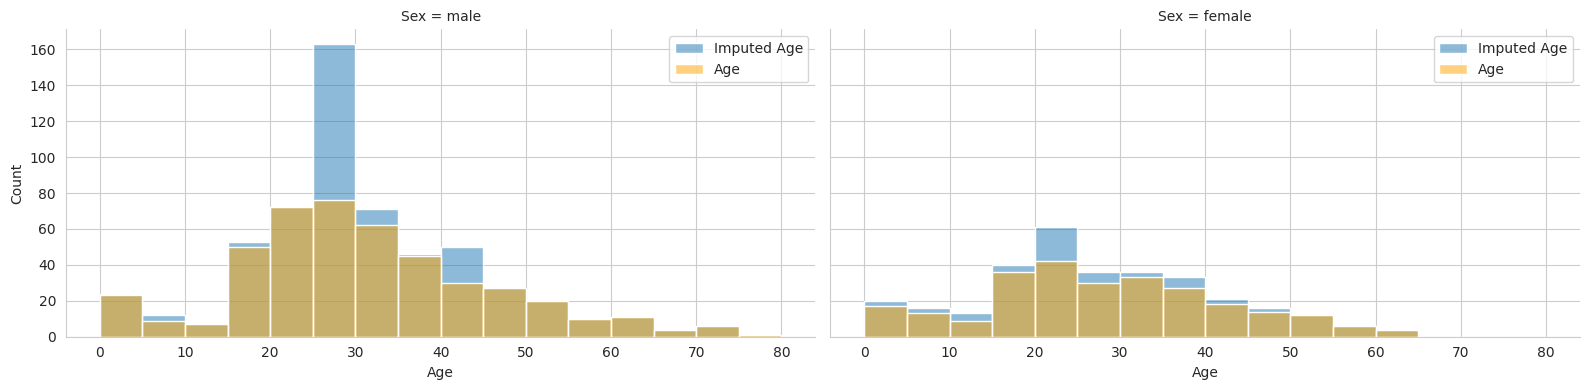

In [181]:
print(df_out.groupby("Sex")[["Age", "AgeOG"]].describe())
print("")

g = sns.displot(df_out, kind="hist", bins=range(0, 85, 5), x="Age", col="Sex", height=4, aspect=2, alpha=0.5, label="Imputed Age")
_ = sns.histplot(df_out.query("Sex == 'male'"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=g.axes[0][0])
_ = sns.histplot(df_out.query("Sex == 'female'"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=g.axes[0][1])
_ = g.axes[0][0].legend()
_ = g.axes[0][1].legend()

              Age                                                       \
            count       mean        std      min        25%        50%   
FamilySize                                                               
0           537.0  32.023260  11.696822  5.00000  23.000000  29.235196   
1           161.0  31.079476  12.840630  0.42000  22.000000  29.000000   
2           102.0  25.215983  16.365602  0.67000   9.250000  26.500000   
3            29.0  18.052427  14.109706  0.75000   4.000000  23.000000   
4            15.0  16.682356  16.091604  2.00000   6.012167   9.000000   
5            22.0  18.409091  17.388171  1.00000   4.750000  12.000000   
6            12.0  15.166667  14.732977  2.00000   4.750000   9.000000   
7             6.0  15.666667  14.361987  1.00000   9.500000  12.500000   
10            7.0  13.632788   3.486399  6.94369  12.888942  12.888942   

                                  AgeOG                                     \
                  75%        max 

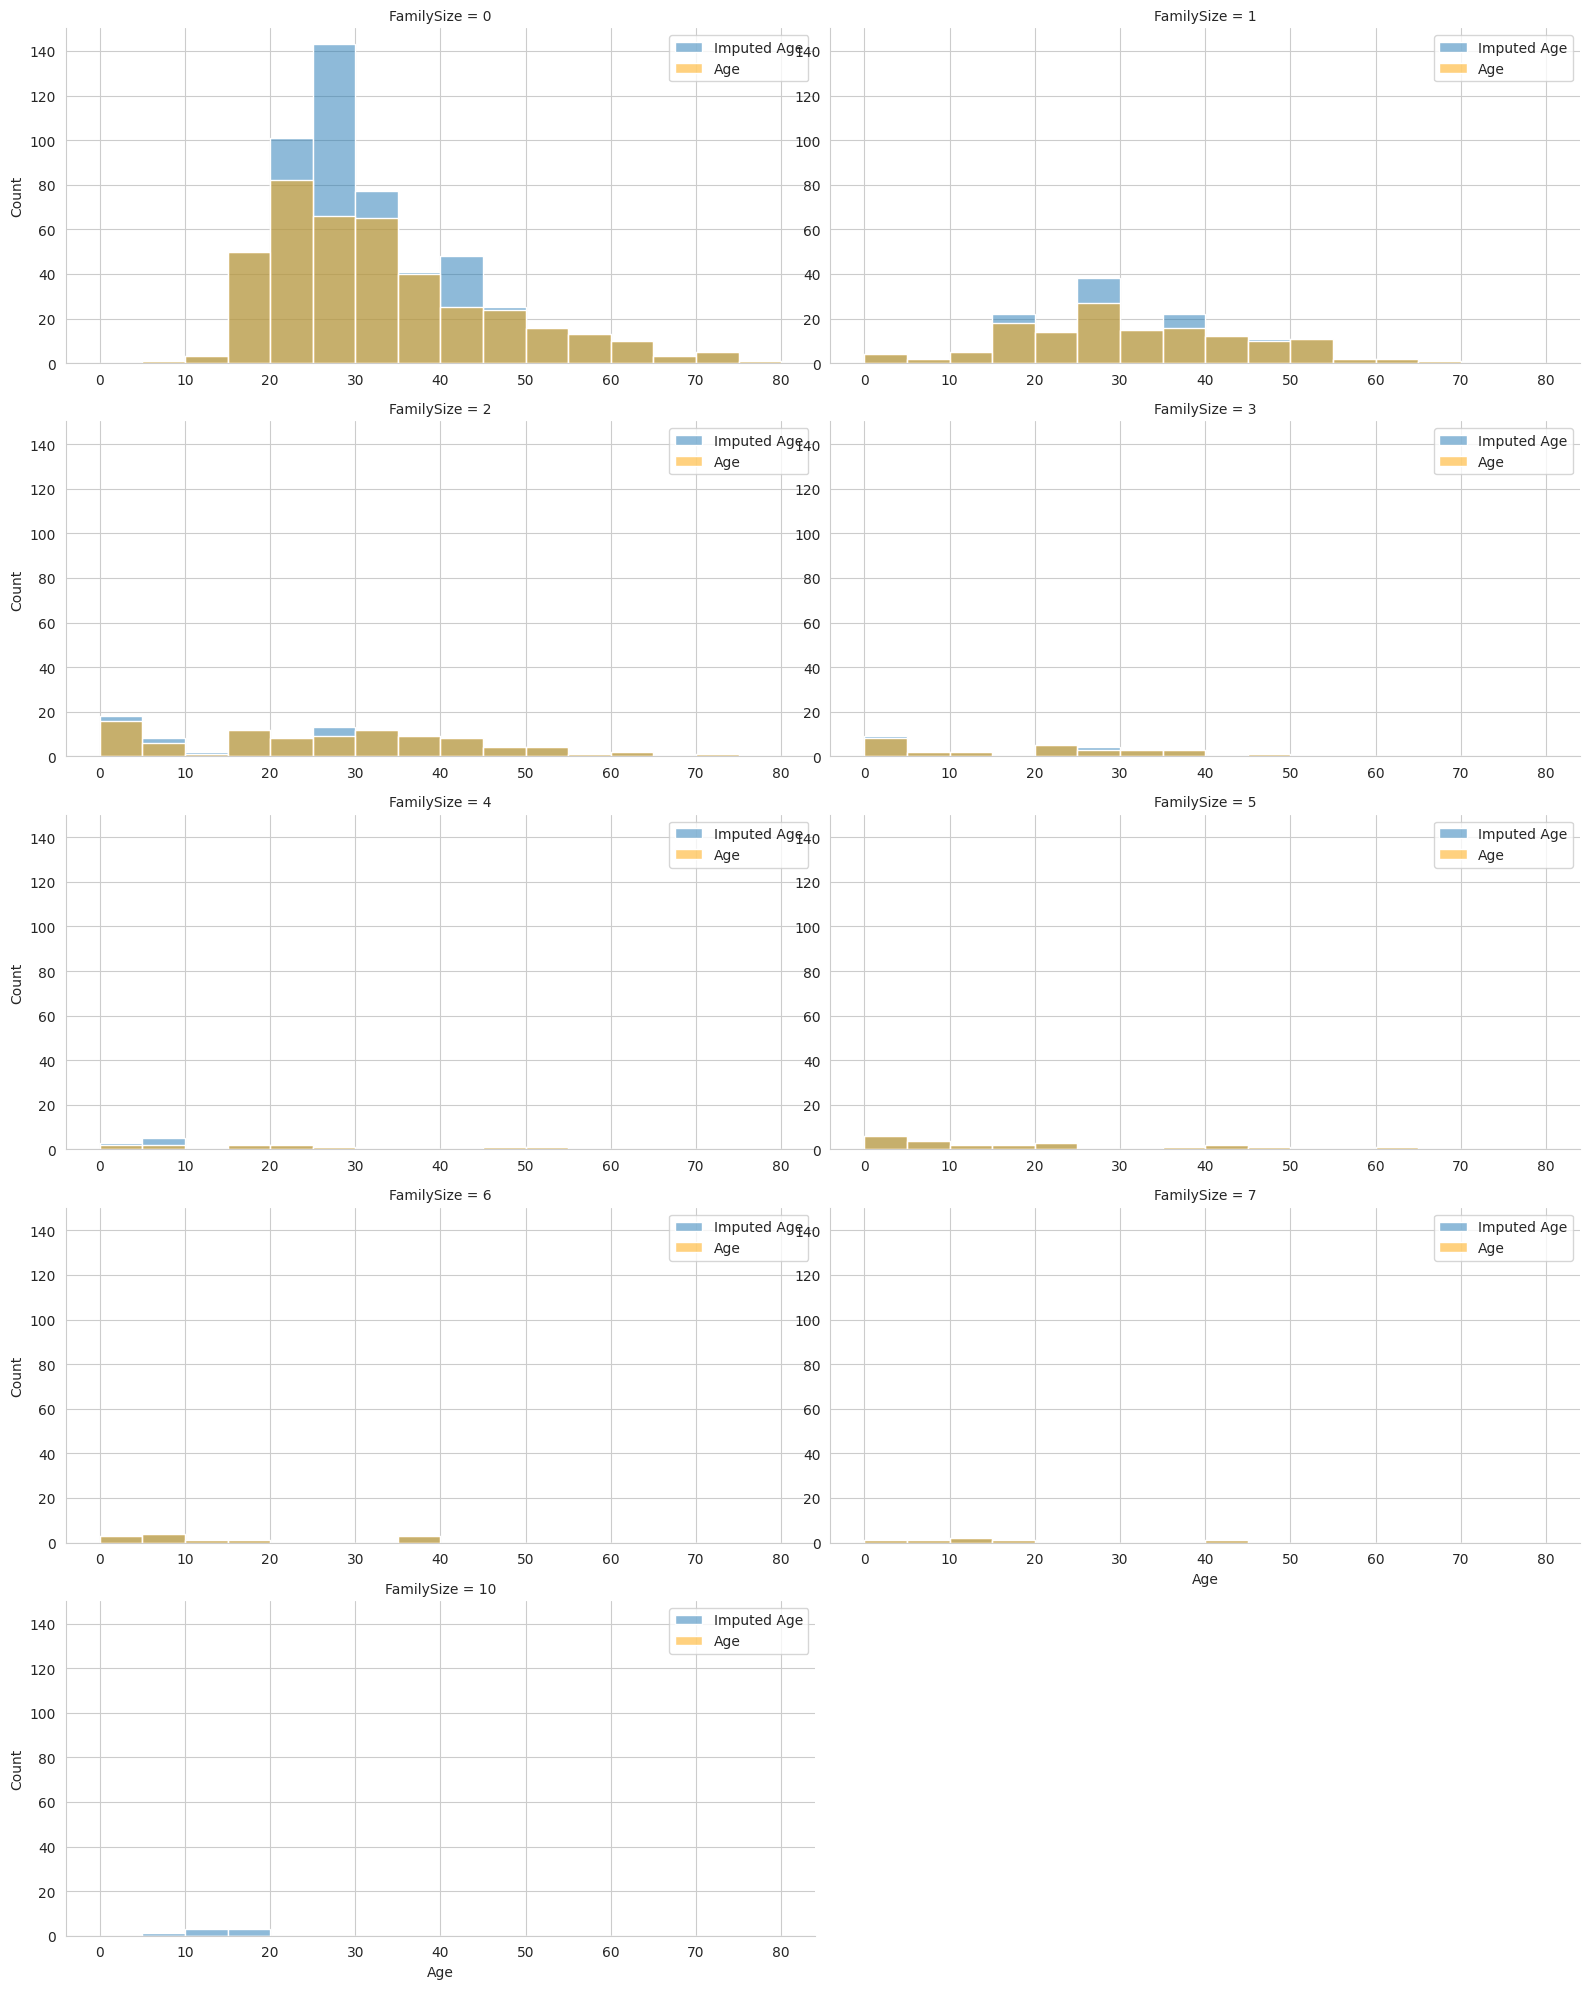

In [180]:
print(df_out.groupby("FamilySize")[["Age", "AgeOG"]].describe())
print("")

g = sns.displot(df_out, kind="hist", bins=range(0, 85, 5), x="Age", col="FamilySize", col_order=sorted(df_out.FamilySize.unique()), col_wrap=2, height=4, aspect=2, alpha=0.5, label="Imputed Age")
for i, sz in enumerate(sorted(df_out.FamilySize.unique())):
    _ = sns.histplot(df_out.query("FamilySize == @sz"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=g.axes[i])
    _ = g.axes[i].legend()

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelleft=True)

         Age                                                                  \
       count       mean        std      min        25%        50%        75%   
SibSp                                                                          
0      608.0  31.384734  12.495814  0.42000  22.364835  29.235196  38.000000   
1      209.0  29.395775  14.259658  0.67000  20.000000  29.000000  38.000000   
2       28.0  22.685778  14.055544  0.75000  15.214013  23.500000  28.422858   
3       16.0  11.764709  10.447128  2.00000   3.799710   7.006083  20.000000   
4       18.0   7.055556   4.880601  1.00000   3.250000   6.500000   9.000000   
5        5.0  10.200000   5.805170  1.00000   9.000000  11.000000  14.000000   
8        7.0  13.632788   3.486399  6.94369  12.888942  12.888942  16.606333   

                  AgeOG                                                        
             max  count       mean        std   min    25%   50%    75%   max  
SibSp                                  

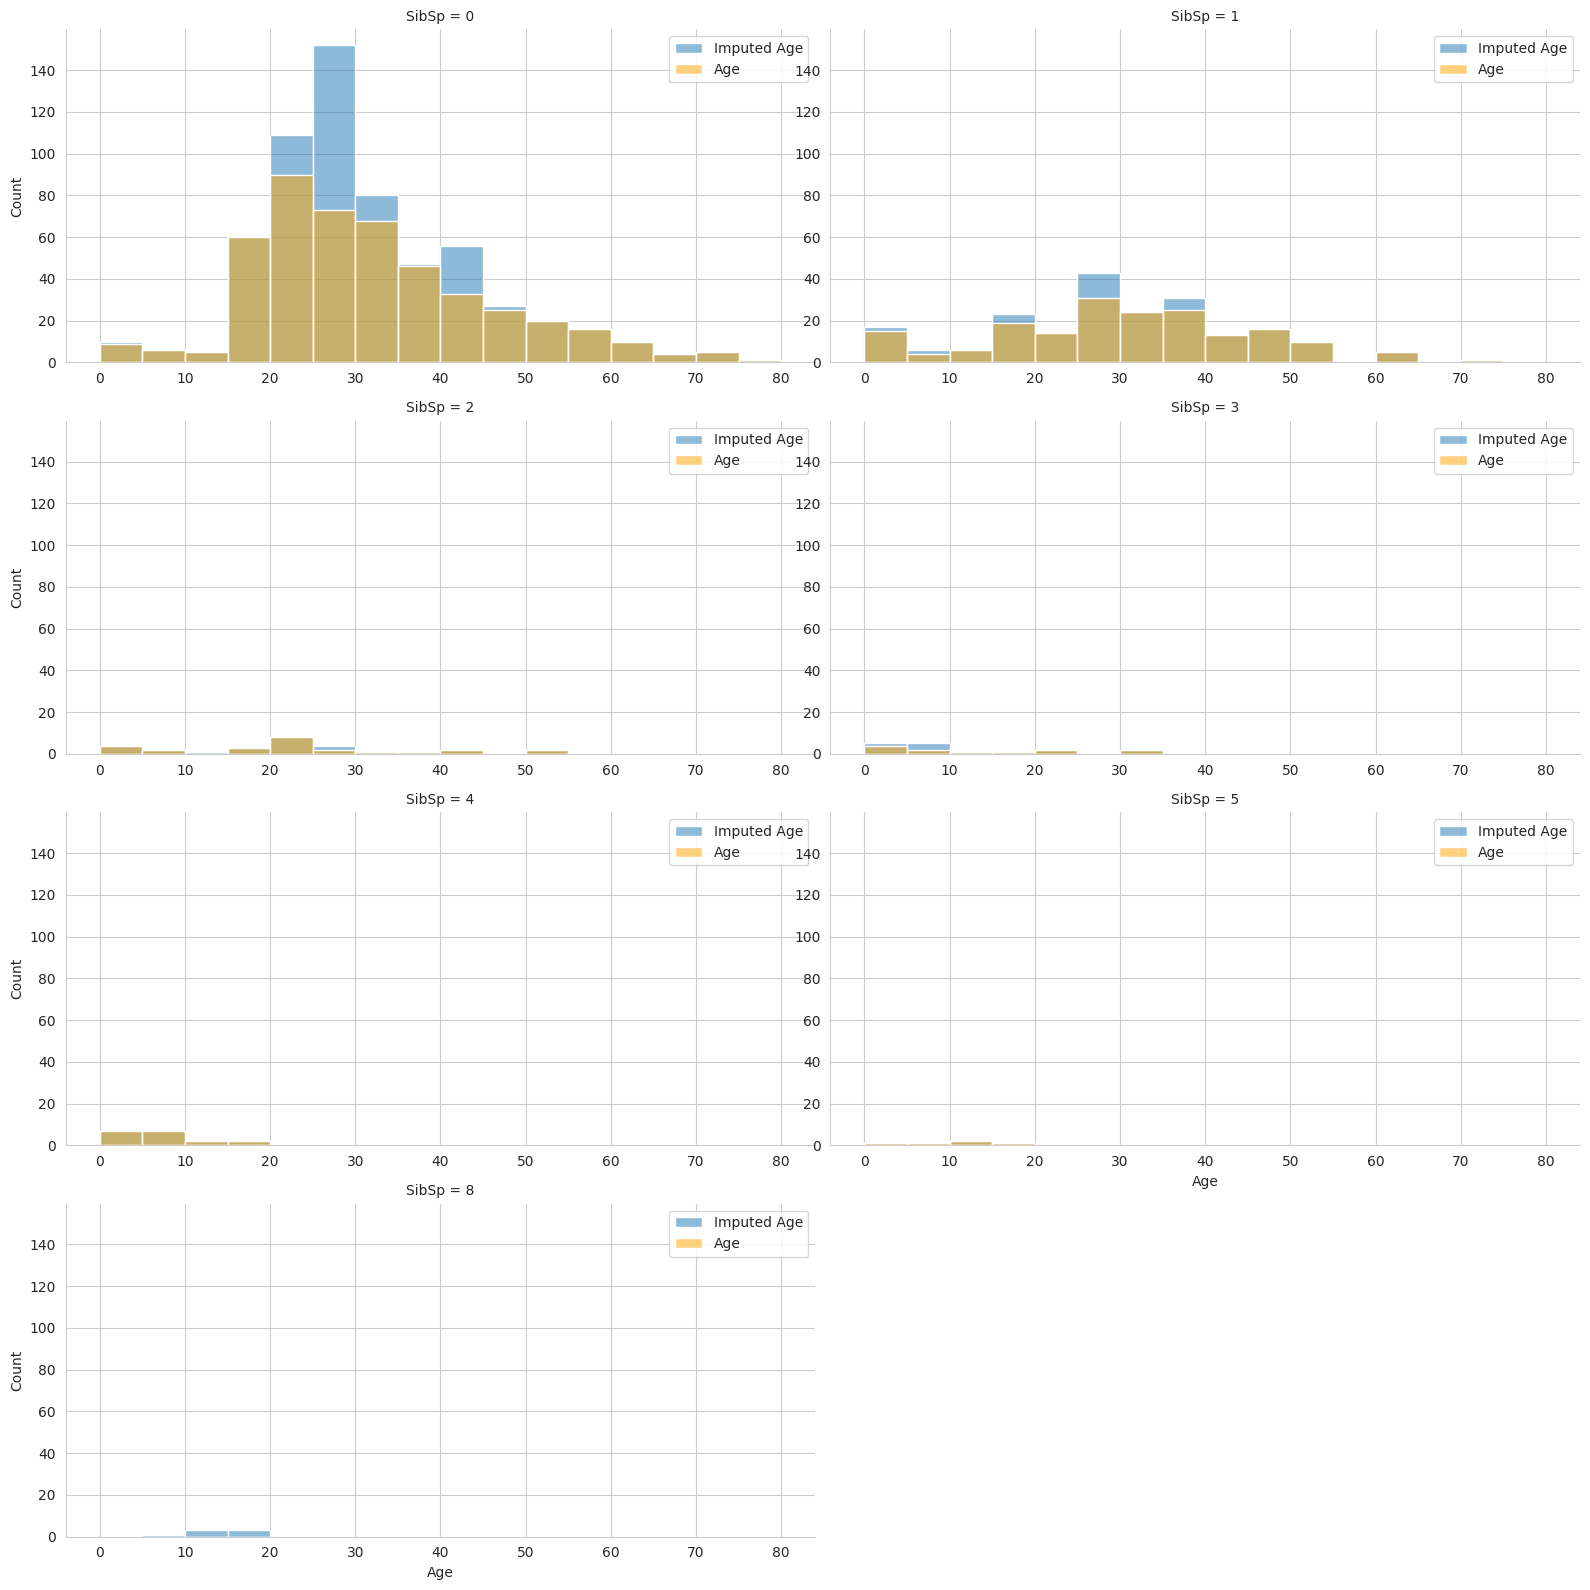

In [179]:
print(df_out.groupby("SibSp")[["Age", "AgeOG"]].describe())
print("")

g = sns.displot(df_out, kind="hist", bins=range(0, 85, 5), x="Age", col_order=sorted(df_out.SibSp.unique()), col="SibSp", col_wrap=2, height=4, aspect=2, alpha=0.5, label="Imputed Age")
for i, sz in enumerate(sorted(df_out.SibSp.unique())):
    _ = sns.histplot(df_out.query("SibSp == @sz"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=g.axes[i])
    _ = g.axes[i].legend()

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelleft=True)

          Age                                                      AgeOG  \
        count       mean        std   min   25%   50%   75%   max  count   
Pclass                                                                     
1       216.0  38.702917  13.859736  0.92  29.0  39.0  48.0  80.0  186.0   
2       184.0  29.904701  13.574472  0.67  23.0  30.0  36.0  70.0  173.0   
3       491.0  24.862429  11.234958  0.42  19.0  26.0  29.0  74.0  355.0   

                                                            
             mean        std   min   25%   50%   75%   max  
Pclass                                                      
1       38.233441  14.802856  0.92  27.0  37.0  49.0  80.0  
2       29.877630  14.001077  0.67  23.0  29.0  36.0  70.0  
3       25.140620  12.495398  0.42  18.0  24.0  32.0  74.0  



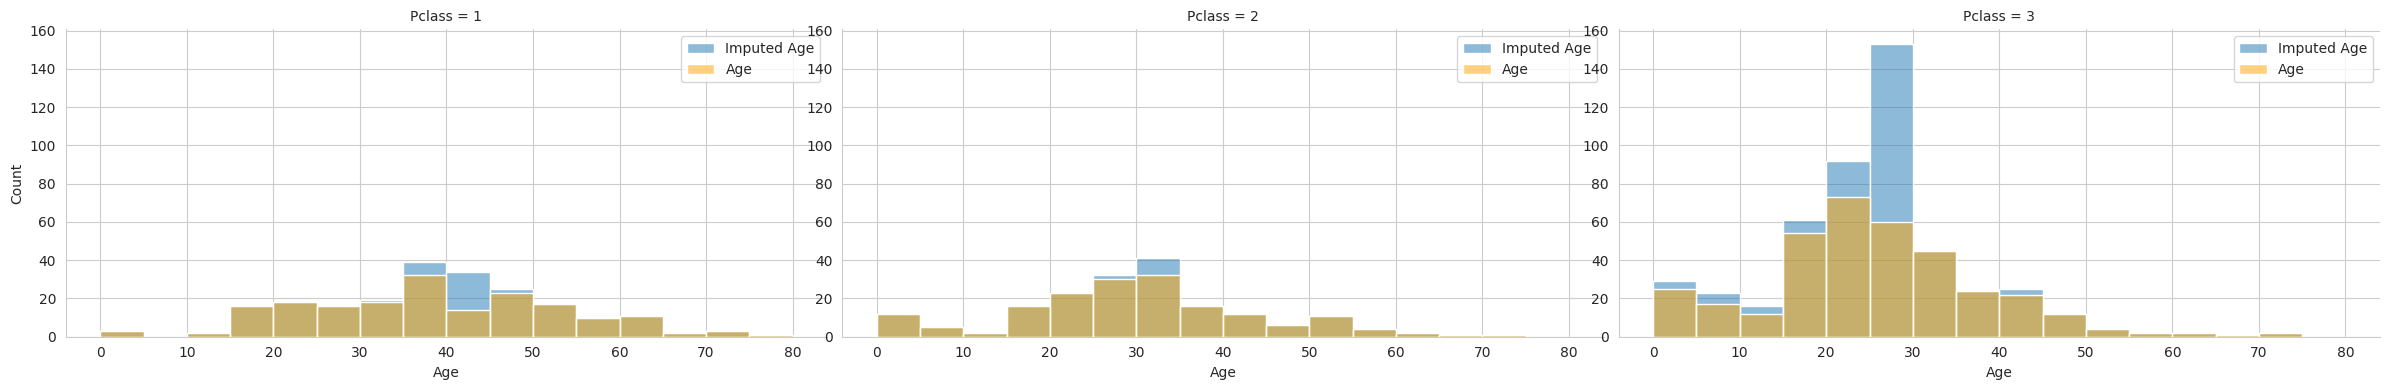

In [243]:
print(df_out.groupby("Pclass")[["Age", "AgeOG"]].describe())
print("")

g = sns.displot(df_out, kind="hist", bins=range(0, 85, 5), x="Age", col="Pclass", col_order=sorted(df_out.Pclass.unique()), height=4, aspect=2, alpha=0.5, label="Imputed Age")
ax_iter = g.axes.flat
for i, sz in enumerate(sorted(df_out.Pclass.unique())):
    ax = next(ax_iter)
    _ = sns.histplot(df_out.query("Pclass == @sz"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=ax)
    _ = ax.legend()

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelleft=True)

           Age                                                              \
         count       mean        std    min      25%    50%      75%   max   
Title                                                                        
Dr         7.0  41.633571  11.012412  23.00  35.7175  44.00  49.5000  54.0   
Master    40.0   4.639375   3.469042   0.42   1.7500   4.00   7.4075  12.0   
Miss     185.0  21.171297  12.033945   0.75  14.0000  21.83  28.0000  63.0   
Mr       517.0  31.745208  11.636409  11.00  25.0000  28.00  37.0000  80.0   
Mrs      126.0  35.823611  10.914802  14.00  28.1300  35.00  43.8800  63.0   
Rev        6.0  43.166667  13.136463  27.00  31.5000  46.50  53.2500  57.0   
Unknown   10.0  49.100000  11.029758  33.00  41.2500  48.50  55.0000  70.0   

         AgeOG                                                         
         count       mean        std    min    25%   50%    75%   max  
Title                                                                  
Dr 

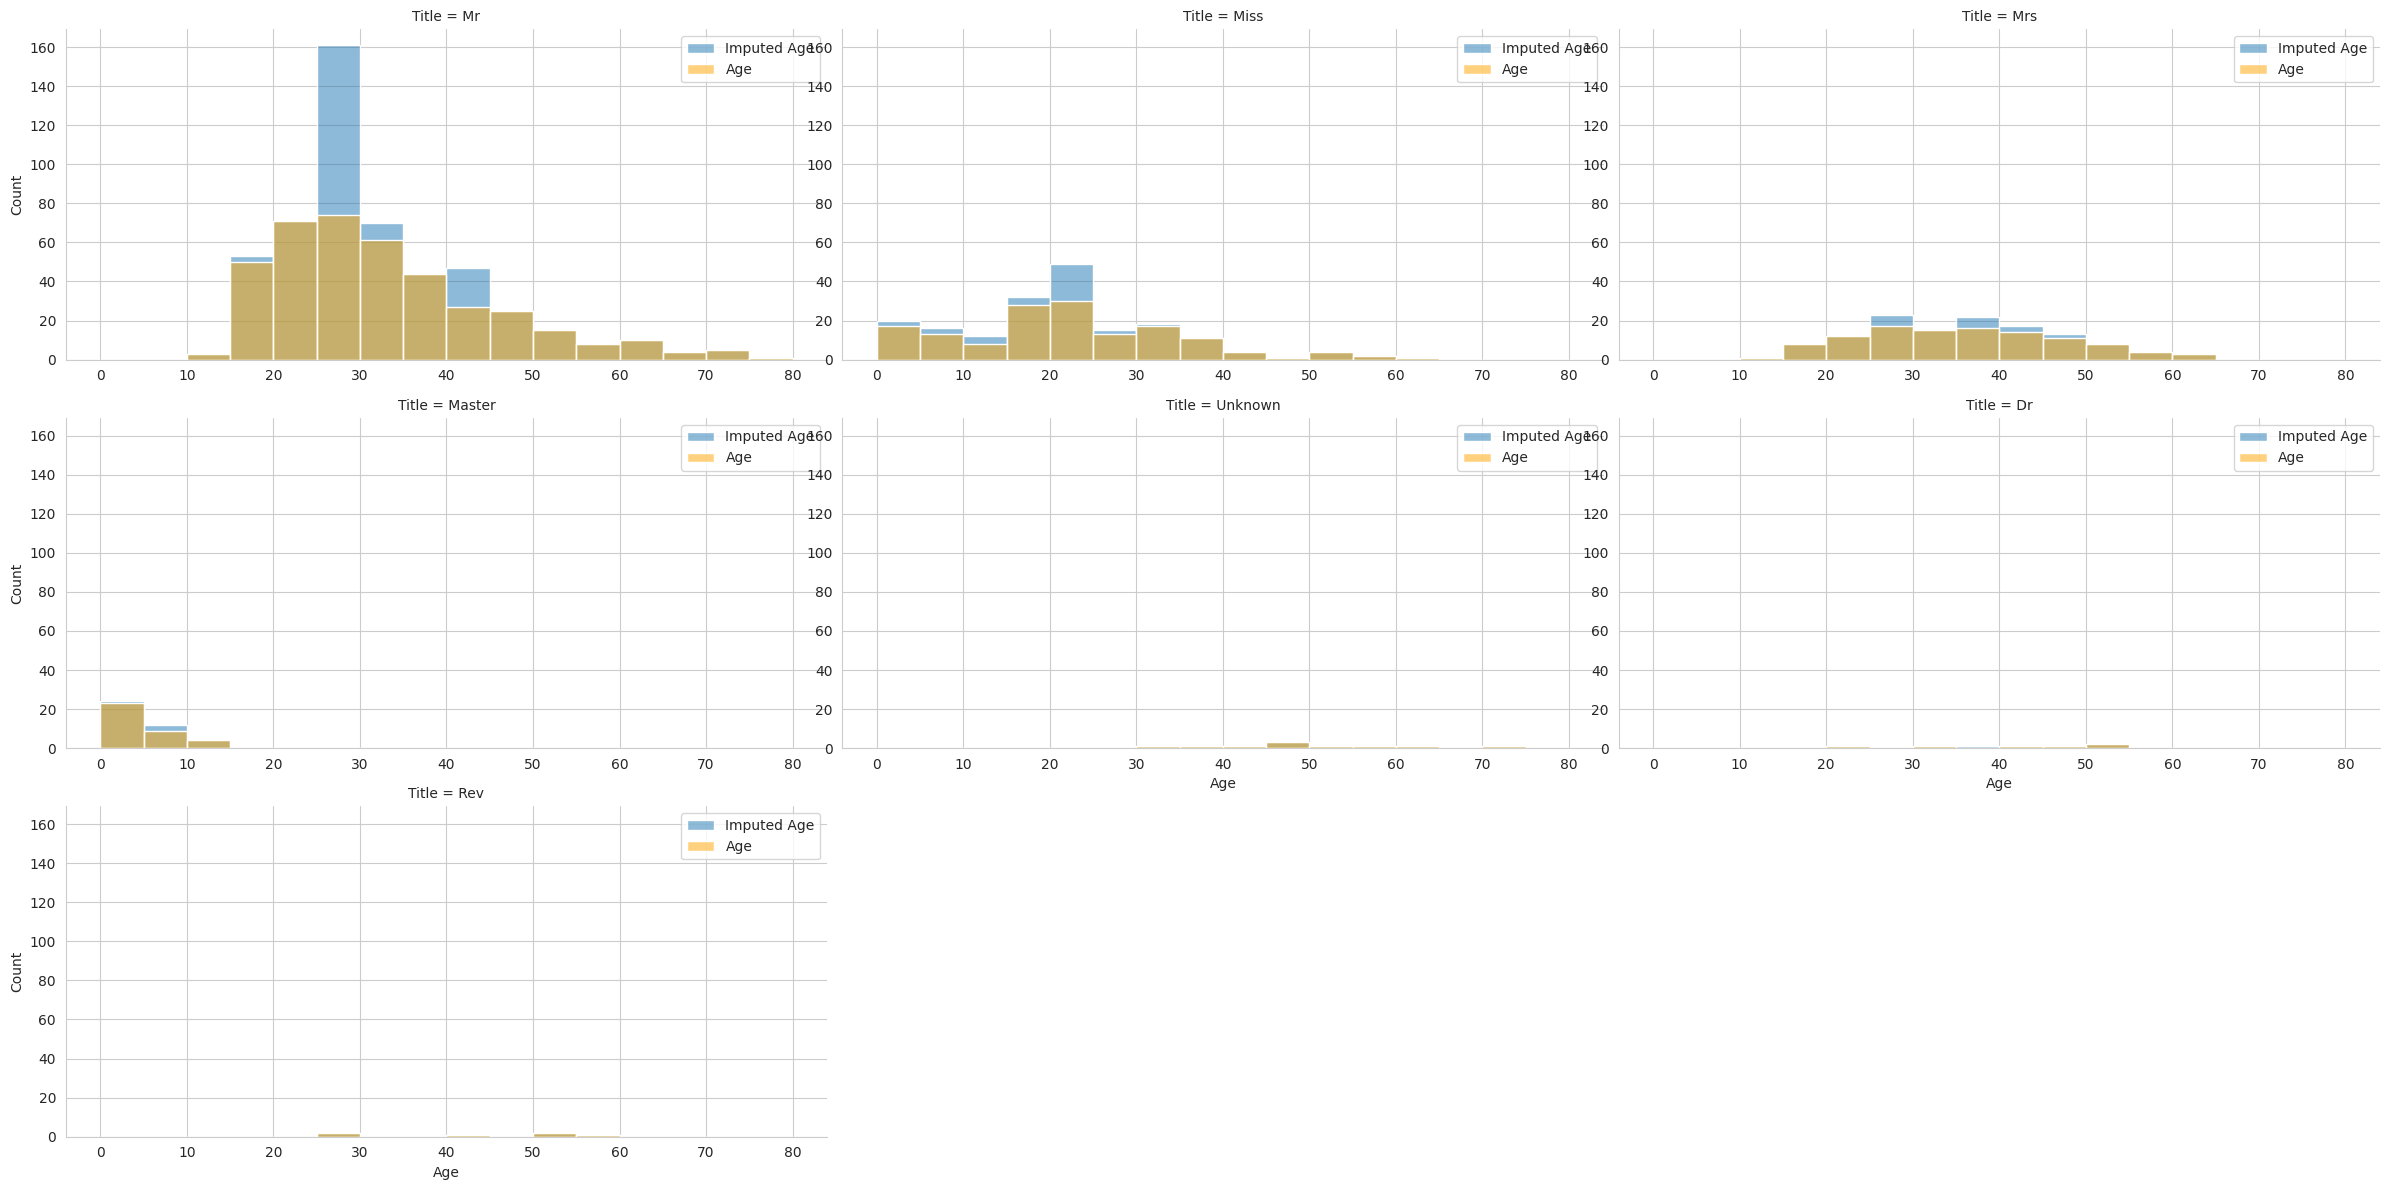

In [244]:
print(df_out.groupby("Title")[["Age", "AgeOG"]].describe())
print("")

g = sns.displot(df_out, kind="hist", bins=range(0, 85, 5), x="Age", col="Title", col_order=df_out.Title.value_counts().sort_values(ascending=False).index, col_wrap=3, height=4, aspect=2, alpha=0.5, label="Imputed Age")
ax_iter = g.axes.flat
for i, sz in enumerate(df_out.Title.value_counts().sort_values(ascending=False).index):
    ax = next(ax_iter)
    _ = sns.histplot(df_out.query("Title == @sz"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=ax)
    _ = ax.legend()

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelleft=True)

                 Age                                                    \
               count       mean        std   min        25%        50%   
Pclass Sex                                                               
1      female   34.0  35.241230  11.765933  16.0  26.750000  32.500000   
       male     75.0  44.243871  12.359738  22.0  35.500000  43.605833   
2      female   32.0  32.933521  10.419188  17.0  26.523670  31.000000   
       male     72.0  34.031078  12.469735  16.0  25.000000  31.830570   
3      female   60.0  23.965052   8.325946   5.0  19.452437  22.000000   
       male    264.0  29.510146   9.526968  11.0  23.000000  27.955697   

                                AgeOG                                     \
                     75%   max  count       mean        std   min    25%   
Pclass Sex                                                                 
1      female  41.750000  62.0   32.0  34.937500  11.788287  16.0  25.50   
       male    51.663250  80.

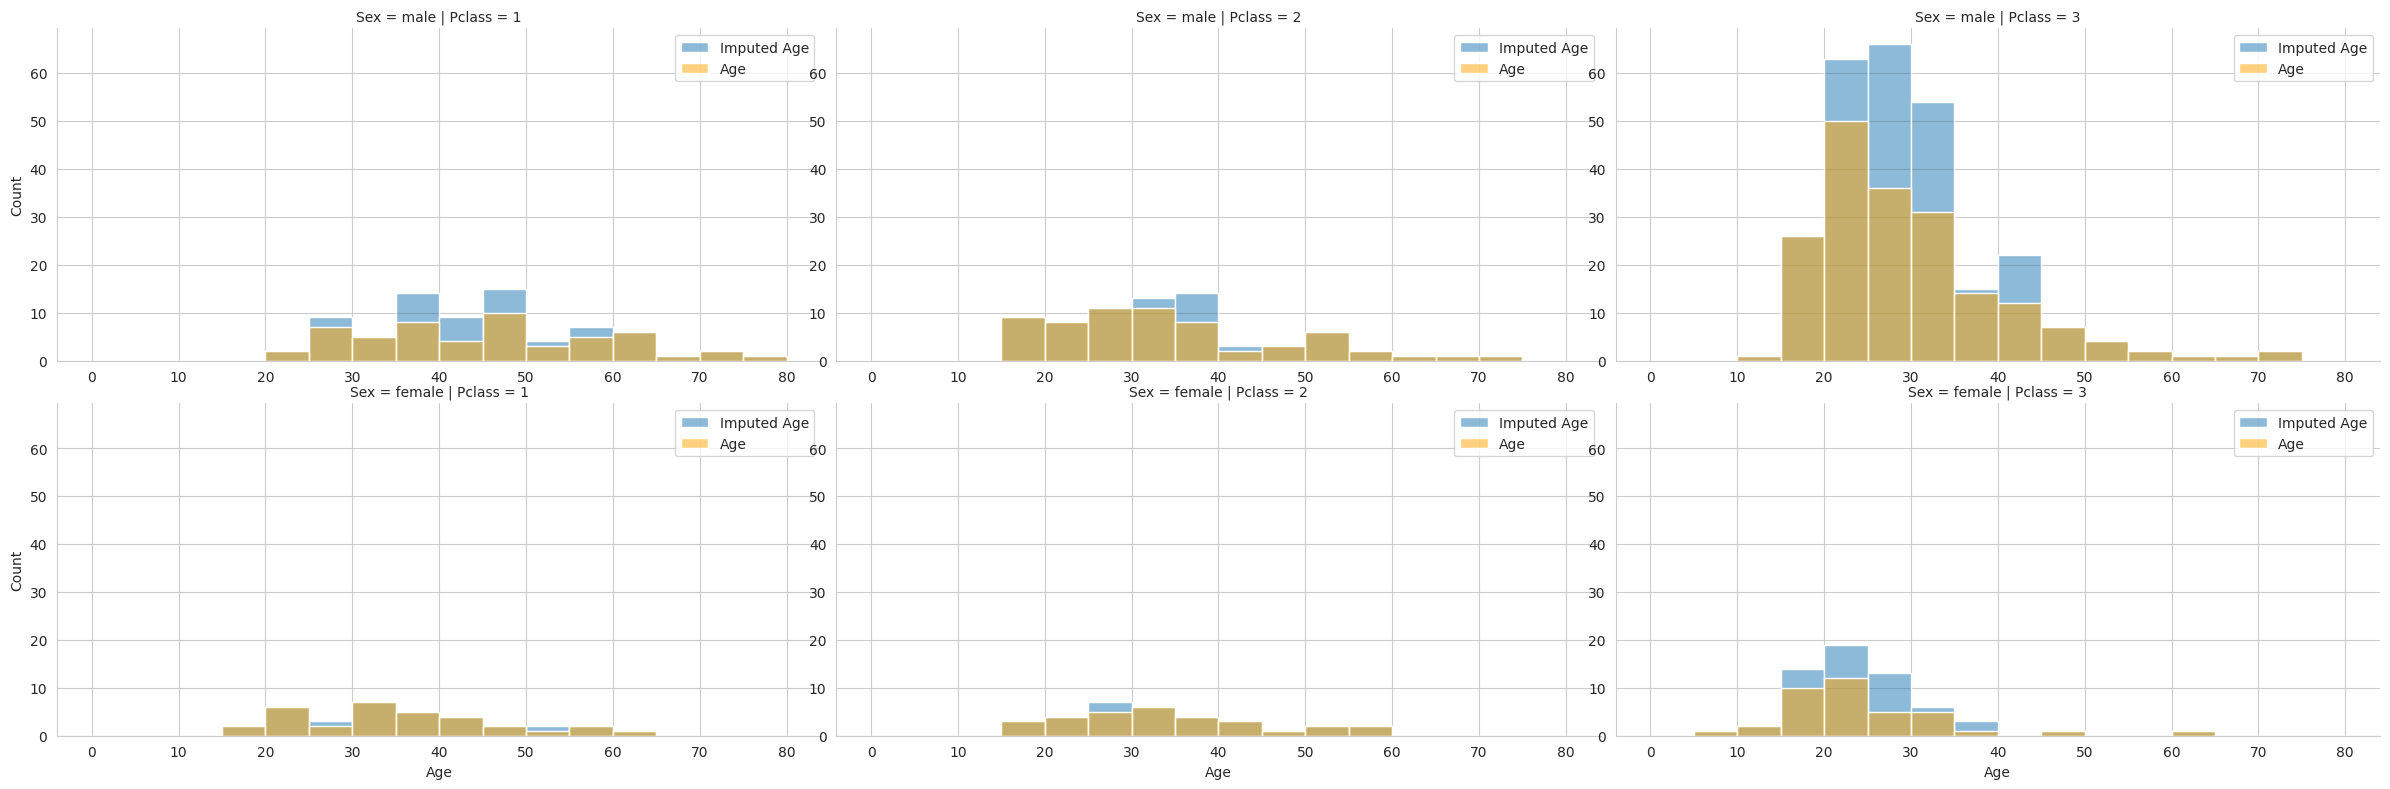

In [274]:
print(df_out.query("FamilySize == 0").groupby(["Pclass", "Sex"])[["Age", "AgeOG"]].describe())
print("")

g = sns.displot(df_out.query("FamilySize == 0"), kind="hist", bins=range(0, 85, 5), x="Age", col="Pclass", col_order=sorted(df_out.Pclass.unique()), 
                row="Sex", row_order=["male", "female"], height=4, aspect=2, alpha=0.5, label="Imputed Age")
ax_iter = g.axes.flat
for sex in ["male", "female"]:
    for i, sz in enumerate(sorted(df_out.Pclass.unique())):
        ax = next(ax_iter)
        _ = sns.histplot(df_out.query("(FamilySize == 0) and (Pclass == @sz) and (Sex == @sex)"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=ax)
        _ = ax.legend()

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelleft=True)

                Age                                                           \
              count       mean        std   min   25%      50%     75%   max   
Pclass Title                                                                   
1      Miss    27.0  32.921481  10.576331  16.0  25.0  30.0000  38.000  58.0   
       Mr      67.0  44.102239  11.998245  22.0  36.0  43.4675  47.000  80.0   
2      Miss    21.0  30.458810   9.143860  17.0  24.0  29.5675  35.000  50.0   
       Mr      66.0  32.674242  12.098472  16.0  25.0  30.5000  36.000  70.0   
3      Miss    55.0  22.114000   5.854856   5.0  20.5  21.8300  22.500  45.0   
       Mr     264.0  28.539328   9.109025  11.0  23.0  26.9725  30.625  74.0   

              AgeOG                                                      
              count       mean        std   min   25%   50%   75%   max  
Pclass Title                                                             
1      Miss    26.0  33.000000  10.777755  16.0  24.5  30

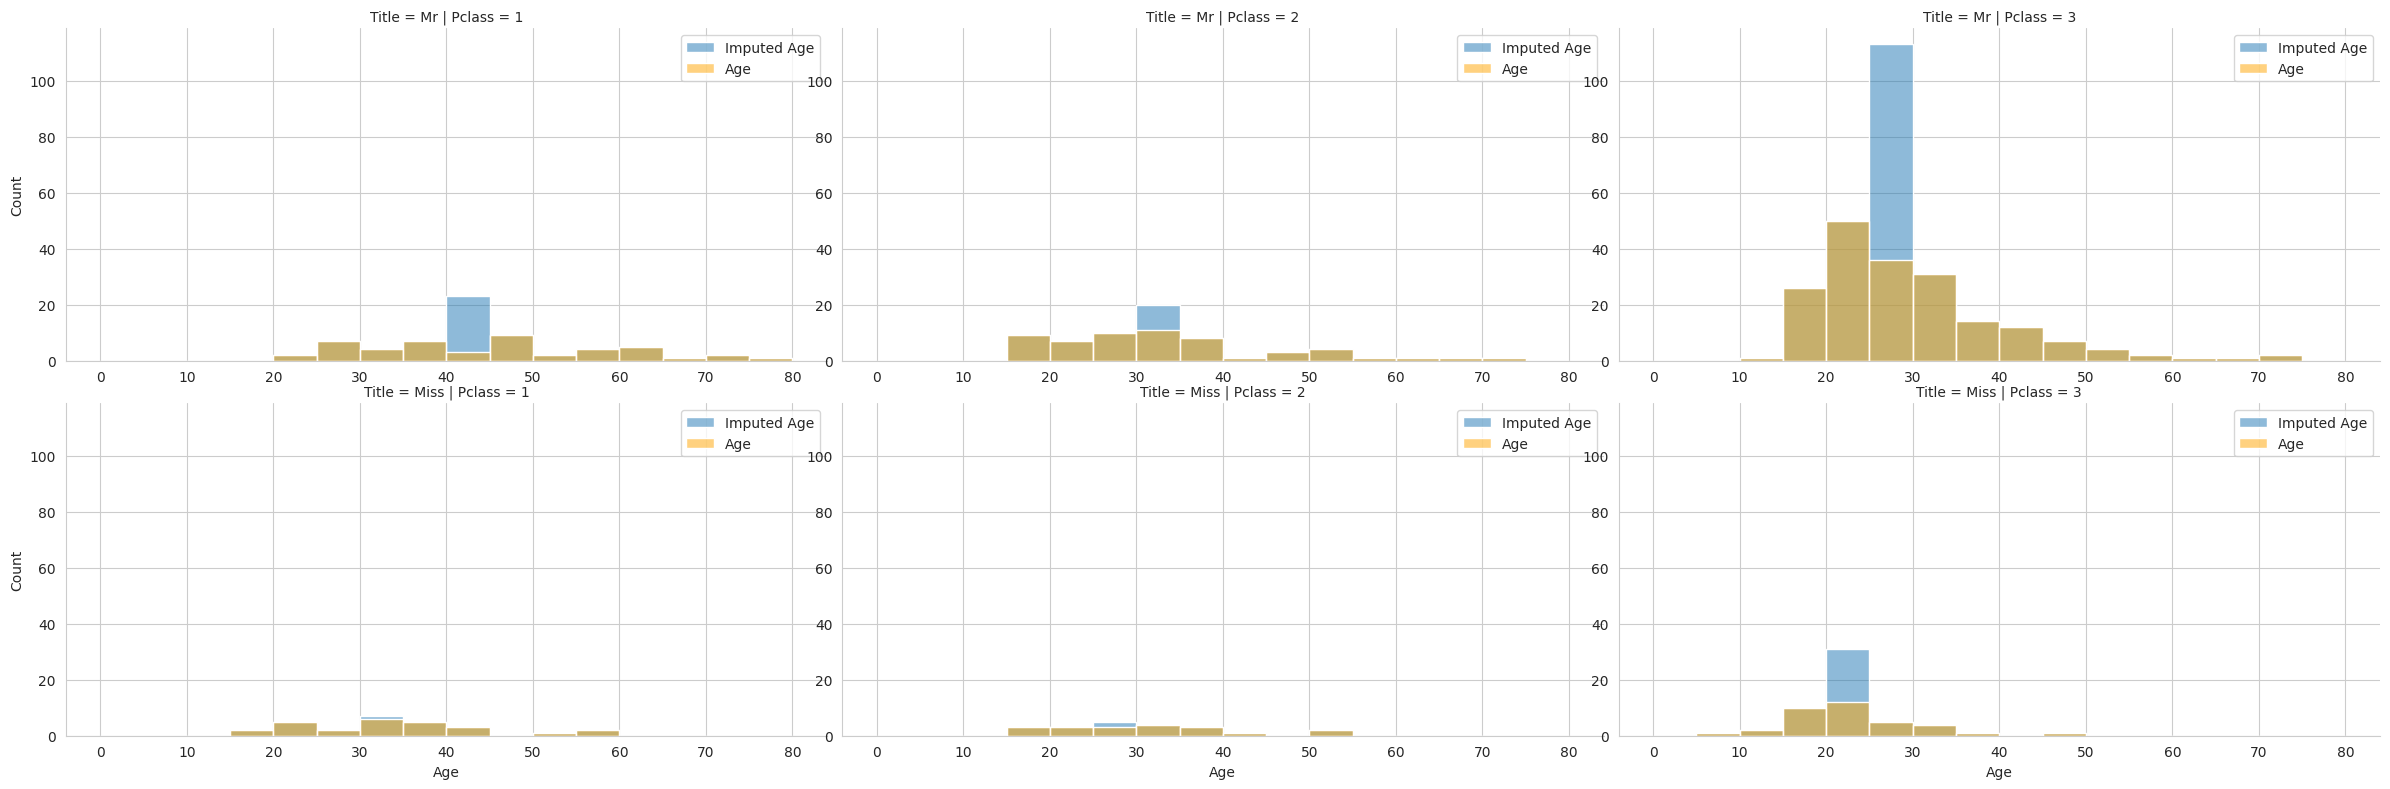

In [246]:
print(df_out.query("(FamilySize == 0) and (Title in ['Mr', 'Miss'])").groupby(["Pclass", "Title"])[["Age", "AgeOG"]].describe())
print("")

g = sns.displot(df_out.query("(FamilySize == 0) and (Title in ['Mr', 'Miss'])"), kind="hist", bins=range(0, 85, 5), x="Age", col="Pclass", col_order=sorted(df_out.Pclass.unique()), 
                row="Title", row_order=["Mr", "Miss"], height=4, aspect=2, alpha=0.5, label="Imputed Age")

ax_iter = g.axes.flat
for title in ["Mr", "Miss"]:
    for i, sz in enumerate(sorted(df_out.Pclass.unique())):
        ax = next(ax_iter)
        _ = sns.histplot(df_out.query("(FamilySize == 0) and (Pclass == @sz) and (Title == @title)"), bins=range(0, 85, 5), x="AgeOG", alpha=0.5, color="orange", label="Age", ax=ax)
        _ = ax.legend()

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelleft=True)

# Model selection

* Treat the test predictions as the labels and see if they make sense
    * I broke it - I used Pclass as the only feature, and indeed, train/val/test accuracy are all 67%
* Other solutions
    * Prove that they leaked data and that it artificially inflates test performance
* Can you visualize how the random forest or decision tree is coming up with decisions?
* Gradient boosting?
* We're still overfitting on training data - is this affecting test generalization?

Features:
* Age: passthrough - imputation, what about log transform? Binning? Clipping or removing outliers?
* Fare: passthrough - what about log transform? Binning? Clipping or removing outliers?
* Sex (ord): passthrough
* Pclass: passthrough
* Title (onehot): valid = [Mr, Mrs, Miss, Master, Rev, Dr], valid = [Mr, Mrs, Miss, Master, Rev]
* SibSp/Parch: drop
* FamilySize: passthrough, clip upper 4
* Deck (ord): drop
* Embarked (onehot): drop
* SexPclassAge (onehot): passthrough

In [32]:
from custom_transformers import DynamicDataPrepPipeline, MLPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from utility_functions import make_stratified_k_fold_with_custom_strata, make_custom_strata

df = pd.read_csv("./dataset/train.csv")

In [33]:
# Custom scoring functions

from custom_transformers import TitleExtractor
from custom_scoring import make_scorer_wrapper

title_extractor = TitleExtractor()
df_with_title = title_extractor.transform(df)
title_mr_acc_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "accuracy")
title_mr_rec_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "recall")
title_mr_prec_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "precision")
title_mr_f1_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "f1")
title_mr_tn_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "tn")
title_mr_tp_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "tp")
title_mr_fn_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "fn")
title_mr_fp_scorer = make_scorer_wrapper(df_with_title["Title"], "Mr", "fp")

In [ ]:
y_concat = make_custom_strata(df_with_title, ["Title", "Survived"])
sample_weights = np.ones(y_concat.shape)
sample_weights[y_concat == "Mr_1"] = 5
s = pd.DataFrame({"Strata": y_concat, "Weight": sample_weights})
s.value_counts()

Strata     Weight
Mr_0       1.0       436
Miss_1     1.0       130
Mrs_1      1.0       100
Mr_1       5.0        81
Miss_0     1.0        55
Mrs_0      1.0        26
Master_1   1.0        23
Master_0   1.0        17
Rev_0      1.0         6
Unknown_0  1.0         5
Unknown_1  1.0         5
Dr_0       1.0         4
Dr_1       1.0         3
Name: count, dtype: int64

## Cross-validation

In [89]:
from custom_transformers import DynamicDataPrepPipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate
from utility_functions import make_stratified_k_fold_with_custom_strata, make_custom_strata

df = pd.read_csv("./dataset/train.csv")

data_prep_pipe = DynamicDataPrepPipeline(numeric_columns={"Pclass", "SibSp", "Parch"}, 
                                         ordinal_columns={"Sex"}, 
                                         onehot_columns=set())
# data_prep_pipe = DynamicDataPrepPipeline(numeric_columns=set(), 
#                                          ordinal_columns={"Sex"}, 
#                                          onehot_columns=set())
# data_prep_pipe = DynamicDataPrepPipeline(extract_title=True,
#                                          numeric_columns=set(), 
#                                          ordinal_columns=set(), 
#                                          onehot_columns=set())
# data_prep_pipe = DynamicDataPrepPipeline(numeric_columns={"Age", "Fare", "Pclass"}, 
#                                          ordinal_columns={"Sex"}, 
#                                          onehot_columns=set())

data_prep_pipe = DynamicDataPrepPipeline(
    ordinal_columns={"Sex"},
    numeric_columns={"Age", "Pclass", "Fare"},
    extract_title=True,
    extract_fam=True,
    extract_deck=True,
    extract_sexpclassage=True,
    # age_imputer_model=RandomForestRegressor(max_depth=10, random_state=0),
    # impute_age_kwargs={"add_indicator": True},
)
model = RandomForestClassifier(max_depth=20, random_state=0)
# max_depth=20
# max_leaf_nodes=100
# min_samples_leaf=1
# ccp_alpha=0
# model = RandomForestClassifier(max_depth=max_depth, 
#                                max_leaf_nodes=max_leaf_nodes, 
#                             #    min_samples_leaf=min_samples_leaf, 
#                             #    ccp_alpha=ccp_alpha,
#                                random_state=0)

# max_depth=5
# max_iter=200
# model = HistGradientBoostingClassifier(max_depth=max_depth, max_iter=max_iter, random_state=0)

# max_depth=20
# max_leaf_nodes=50
# model = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=0)

ml_pipe = Pipeline([
    ("data_prep", data_prep_pipe),
    ("model", model)
])

n_folds = 2
cv_splitter = make_stratified_k_fold_with_custom_strata(df_with_title, ["Title", "Survived"], cv_kwargs={"n_splits": n_folds, "shuffle": True, "random_state": 0})

In [43]:
cv_results = cross_validate(ml_pipe, df.drop(columns=["Survived"]), y=df["Survived"], cv=cv_splitter, return_train_score=True)

cv_df = pd.DataFrame(cv_results)
print(cv_df[["test_score", "train_score"]].describe())
cv_df

       test_score  train_score
count   10.000000    10.000000
mean     0.810275     0.951864
std      0.033925     0.003390
min      0.752809     0.945137
25%      0.789326     0.950390
50%      0.808989     0.952618
75%      0.831461     0.954800
max      0.855556     0.955112


,fit_time,score_time,test_score,train_score
0,0.750473,0.084011,0.855556,0.950062
1,0.848569,0.058228,0.853933,0.947631
2,0.753395,0.051812,0.775281,0.952618
3,0.660945,0.045690,0.831461,0.951372
4,0.669866,0.042577,0.797753,0.955112
5,0.815609,0.042171,0.820225,0.955112
6,0.699723,0.044661,0.797753,0.955112
7,0.756989,0.050356,0.831461,0.945137
8,0.723978,0.069857,0.786517,0.952618
9,0.786345,0.042934,0.752809,0.953865


In [42]:
ml_pipe.fit(df.drop(columns=["Survived"]), y=df["Survived"])

feature_importance = pd.DataFrame({"Feature": ml_pipe.named_steps["data_prep"].get_feature_names_out(),
                                   "Importance": (ml_pipe.named_steps["model"].feature_importances_*100).round(2)})

feature_importance.sort_values(by="Importance", ascending=False)

,Feature,Importance
7,onehot__Title_Mr,37.81
2,num__Fare,18.50
1,num__Age,14.89
3,num__FamilySize,12.83
16,ord_deck__Deck,5.51
0,num__Pclass,3.83
9,onehot__Title_Rev,1.97
15,ord_sex__Sex,1.53
13,"onehot__SexPclassAge_Male, P3, Age>15",0.80
10,onehot__Title_Unknown,0.70


In [ ]:
depths = [tree.get_depth() for tree in ml_pipe.named_steps["model"].estimators_]
n_leaves = [tree.get_n_leaves() for tree in ml_pipe.named_steps["model"].estimators_]

rf_fitted_df = pd.DataFrame({"Depth": depths, "NumLeaves": n_leaves})
rf_fitted_df.describe()

In [44]:
print(ml_pipe.named_steps["model"].get_depth())
print(ml_pipe.named_steps["model"].get_n_leaves())

16
100


### Learning curves

Text(0.5, 1.0, 'Learning Curve for DT, max_depth=20, max_leaf_nodes=50')

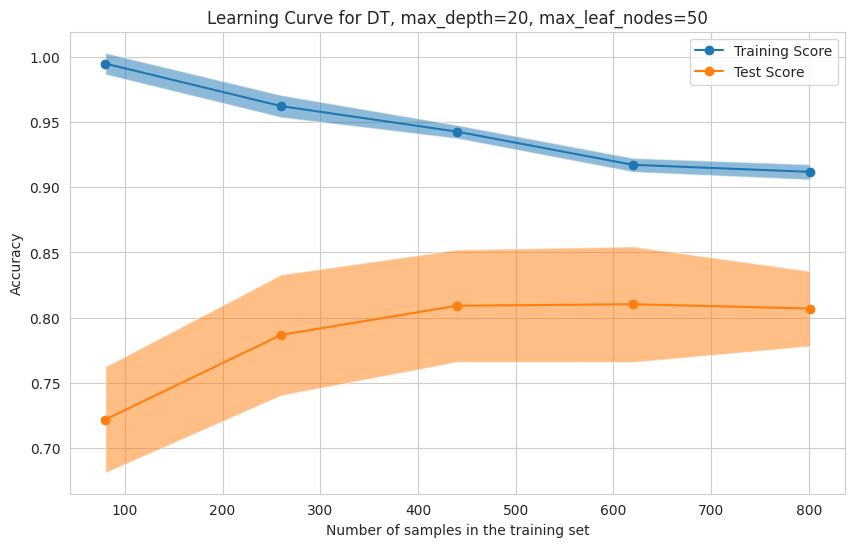

In [53]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

common_params = {
    "X": df.drop(columns=["Survived"]),
    "y": df["Survived"],
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": cv_splitter,
    "score_type": "both",
    # "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

# for ax_idx, estimator in enumerate([ml_pipe]):
estimator = ml_pipe
LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
# ax.set_title(f"Learning Curve for HGBC, max_iter={max_iter}, max_depth={max_depth}")
ax.set_title(f"Learning Curve for DT, max_depth={max_depth}, max_leaf_nodes={max_leaf_nodes}")
# ax.set_ylim(bottom=0.75, top=1)
# plt.show()

### Calibration curves

In [ ]:
# train_idx, val_idx = next(cv_splitter.split(df.drop(columns=["Survived"]), y=df["Survived"]))
# X_train = df.drop(columns=["Survived"]).iloc[train_idx]
# y_train = df["Survived"].iloc[train_idx].to_numpy()
# X_test = df.drop(columns=["Survived"]).iloc[val_idx]
# y_test = df["Survived"].iloc[val_idx].to_numpy()
# X_train = data_prep_pipe.fit_transform(X_train)
# X_test = data_prep_pipe.transform(X_test)

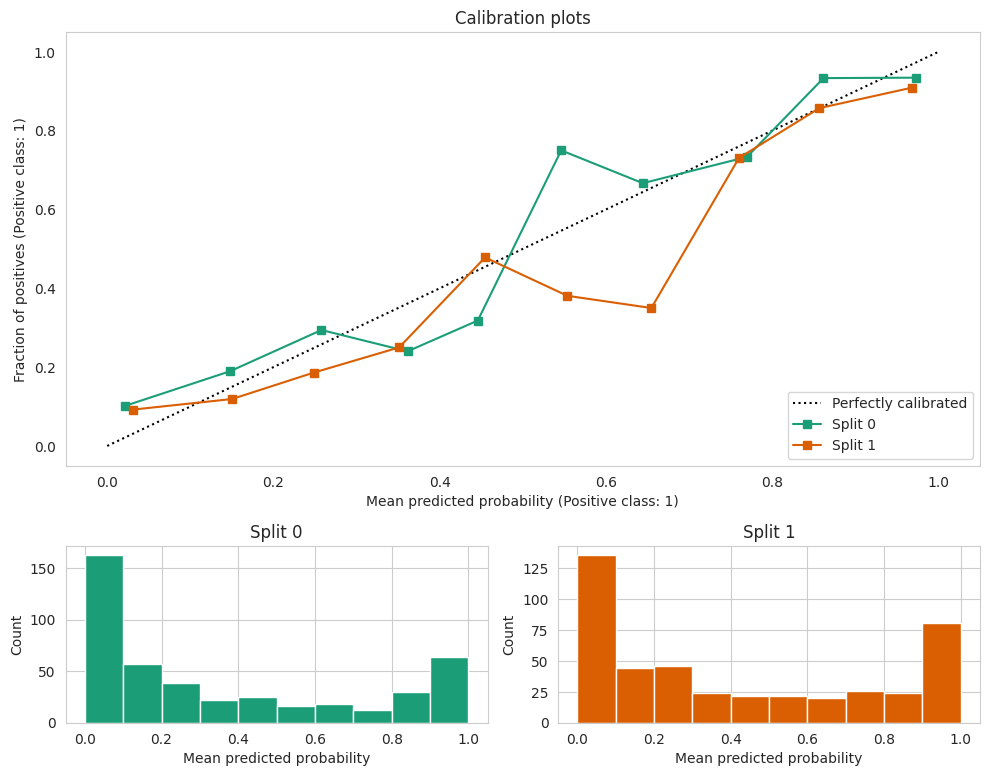

In [92]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

n_folds = 2
cv_splitter = make_stratified_k_fold_with_custom_strata(df_with_title, ["Title", "Survived"], cv_kwargs={"n_splits": n_folds, "shuffle": True})

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
# for i, (clf, name) in enumerate(clf_list):
for i, (train_idx, val_idx) in enumerate(cv_splitter.split(df.drop(columns=["Survived"]), y=df["Survived"])):
    X_train = df.drop(columns=["Survived"]).iloc[train_idx]
    y_train = df["Survived"].iloc[train_idx].to_numpy()
    X_test = df.drop(columns=["Survived"]).iloc[val_idx]
    y_test = df["Survived"].iloc[val_idx].to_numpy()
    X_train = data_prep_pipe.fit_transform(X_train)
    X_test = data_prep_pipe.transform(X_test)
    model.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        model,
        X_test,
        y_test,
        n_bins=10,
        name=f"Split {i}",
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[f"Split {i}"] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
# for i, (_, name) in enumerate(clf_list):
for i, name in enumerate(calibration_displays.keys()):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

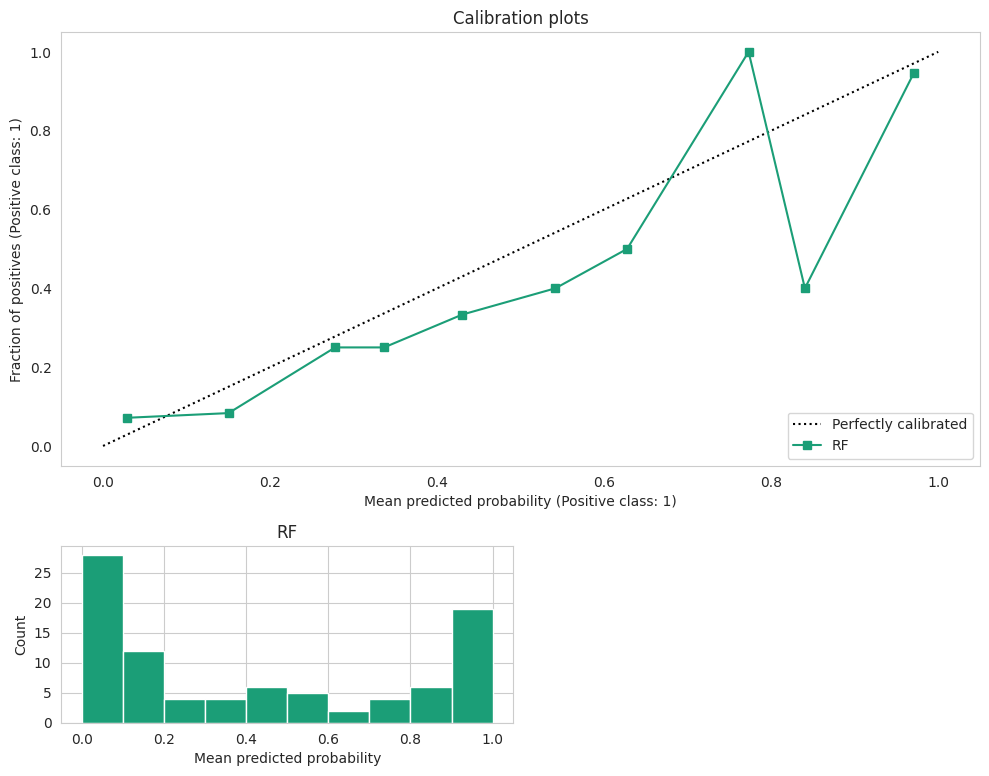

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

# from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# clf_list = [(model, "RF")]

# fig = plt.figure(figsize=(10, 10))
# gs = GridSpec(4, 2)
# colors = plt.get_cmap("Dark2")

# ax_calibration_curve = fig.add_subplot(gs[:2, :2])
# calibration_displays = {}
# for i, (clf, name) in enumerate(clf_list):
#     clf.fit(X_train, y_train)
#     display = CalibrationDisplay.from_estimator(
#         clf,
#         X_test,
#         y_test,
#         n_bins=10,
#         name=name,
#         ax=ax_calibration_curve,
#         color=colors(i),
#     )
#     calibration_displays[name] = display

# ax_calibration_curve.grid()
# ax_calibration_curve.set_title("Calibration plots")

# # Add histogram
# grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
# for i, (_, name) in enumerate(clf_list):
#     row, col = grid_positions[i]
#     ax = fig.add_subplot(gs[row, col])

#     ax.hist(
#         calibration_displays[name].y_prob,
#         range=(0, 1),
#         bins=10,
#         label=name,
#         color=colors(i),
#     )
#     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# plt.tight_layout()
# plt.show()

## Hyperparameter tuning

In [48]:
from custom_transformers import DynamicDataPrepPipeline
from utility_functions import make_stratified_k_fold_with_custom_strata
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier, \
        HistGradientBoostingClassifier, \
        RandomForestRegressor

data_prep_pipe = DynamicDataPrepPipeline()
model = RandomForestClassifier(max_depth=5, random_state=0)
model = HistGradientBoostingClassifier(random_state=0)
model = DecisionTreeClassifier(random_state=0)

ml_pipe = Pipeline([
    ("data_prep", data_prep_pipe),
    ("model", model)
])

# 0
# Not much difference as long as Sex is a feature (77-80% val accuracy)
# Performance drops to 70% val accuracy without Sex
# Train and val accuracy are both low, even when reducing model regularization
# Underfitting, but not due to model complexity - due to features
param_grid = [
    {
        "data_prep__ordinal_columns": [{"Sex"}],
        "data_prep__numeric_columns": [
            {"Pclass", "SibSp", "Parch"}, # From tutorial
            {"SibSp", "Parch"},
            {"Pclass"},
            set()],
        "model__max_depth": [5, 20],
    },
    {
        "data_prep__ordinal_columns": [{"Sex"}],
        "data_prep__numeric_columns": [{"Pclass"}],
        "data_prep__extract_fam": [True],
        "model__max_depth": [5, 20],
    },
    {
        "data_prep__ordinal_columns": [set()],
        "data_prep__numeric_columns": [{"Pclass", "SibSp", "Parch"}],
        "model__max_depth": [5, 20],
    },
]

# 1
# Extracting everything seems best, with fam and title seemingly having the most effect
# Once again, increasing model complexity does not improve val performance
param_grid = [
    {
        "data_prep__ordinal_columns": [{"Sex"}],
        "data_prep__numeric_columns": [
            {"Age", "Pclass", "Fare"}],
        "data_prep__extract_title": [False, True],
        "data_prep__extract_fam": [False, True],
        "data_prep__extract_deck": [False, True],
        "data_prep__extract_sexpclassage": [False, True],
        "model__max_depth": [5, 20],
    },
]

# 2
# Transforming fare and imputing age don't seem to help
param_grid = [
    {
        "data_prep__ordinal_columns": [{"Sex"}],
        "data_prep__numeric_columns": [
            {"Age", "Pclass"}],
        "data_prep__extract_title": [True],
        "data_prep__extract_fam": [True],
        "data_prep__extract_deck": [True],
        "data_prep__extract_sexpclassage": [True],
        "data_prep__transform_fare": [True],
        "model__max_depth": [5, 20],
    },
    {
        "data_prep__ordinal_columns": [{"Sex"}],
        "data_prep__numeric_columns": [
            {"Age", "Pclass", "Fare"}],
        "data_prep__extract_title": [True],
        "data_prep__extract_fam": [True],
        "data_prep__extract_deck": [True],
        "data_prep__extract_sexpclassage": [True],
        "data_prep__age_imputer_model": [
            RandomForestRegressor(max_depth=5, random_state=0),
            RandomForestRegressor(max_depth=10, random_state=0),
            RandomForestRegressor(max_depth=20, random_state=0),
        ],
        "data_prep__impute_age_kwargs": [{"add_indicator": False}, {"add_indicator": True}],
        "model__max_depth": [5, 20],
    },
]

# 3
# Fine-tuning the model hyperparameters
param_grid = [
    {
        "data_prep__ordinal_columns": [{"Sex"}],
        "data_prep__numeric_columns": [{"Age", "Pclass", "Fare"}],
        "data_prep__extract_title": [True],
        "data_prep__extract_fam": [True],
        "data_prep__extract_deck": [True],
        "data_prep__extract_sexpclassage": [True],
        "model__max_depth": [15, 10, 5],
        # "model__l2_regularization": [0.001, 0.002, 0.005, 0.01],
        # "model__max_iter": [200, 500, 1000],
        # "model__n_estimators": [500, 1000],
        # "model__ccp_alpha": [0.002, 0.004],
        "model__max_leaf_nodes": [200],
        # "model__min_samples_leaf": [2, 3],
        # "data_prep__age_imputer_model": [
        #     RandomForestRegressor(max_depth=10, random_state=0),
        # ],
        # "data_prep__impute_age_kwargs": [{"add_indicator": True}],
    },
]

scoring_dict = {
    "accuracy": "accuracy",
    # "recall": "recall",
    # "precision": "precision",
    # "f1": "f1",
    # "accuracy_mr": title_mr_acc_scorer,
    # "recall_mr": title_mr_rec_scorer,
    # "precision_mr": title_mr_prec_scorer,
    # "f1_mr": title_mr_f1_scorer,
    # "tn_mr": title_mr_tn_scorer,
    # "tp_mr": title_mr_tp_scorer,
    # "fn_mr": title_mr_fn_scorer,
    # "fp_mr": title_mr_fp_scorer,
}

n_folds = 10
cv_index_iter = make_stratified_k_fold_with_custom_strata(df_with_title, ["Title", "Survived"], cv_kwargs={"n_splits": n_folds, "shuffle": True, "random_state": 0})
# cv_index_iter = n_folds
# grid = GridSearchCV(ml_pipe, param_grid=param_grid, cv=cv_index_iter, 
#                     scoring=scoring_dict, 
#                     return_train_score=True,
#                     refit=False)
grid = GridSearchCV(ml_pipe, param_grid=param_grid, cv=n_folds, 
                    scoring="accuracy", 
                    return_train_score=True)
grid.fit(df.drop("Survived", axis=1), y=df["Survived"])
# grid.fit(df.drop("Survived", axis=1), y=df["Survived"], **{"model__sample_weight": sample_weights})
# grid.fit(df.drop("Survived", axis=1), y=df["Survived"], model__sample_weight=sample_weights)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('data_prep', DynamicDataPrepPipeline()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid=[{'data_prep__extract_deck': [True],
                          'data_prep__extract_fam': [True],
                          'data_prep__extract_sexpclassage': [True],
                          'data_prep__extract_title': [True],
                          'data_prep__numeric_columns': [{'Age', 'Fare',
                                                          'Pclass'}],
                          'data_prep__ordinal_columns': [{'Sex'}],
                          'model__max_depth': [15, 10, 5],
                          'model__max_leaf_nodes': [200]}],
             return_train_score=True, scoring='accuracy')

In [49]:
pd.set_option("display.max_colwidth", 1000)
test_results = pd.DataFrame({"Run": list(range(len(grid.cv_results_["mean_train_score"]))),
                             "Train (Mean)": (np.array(grid.cv_results_["mean_train_score"])*100).round(2),
                             "Train (Std)": (np.array(grid.cv_results_["std_train_score"])*100/np.sqrt(n_folds)).round(2),
                             "Test (Mean)": (np.array(grid.cv_results_["mean_test_score"])*100).round(2),
                             "Test (Std)": (np.array(grid.cv_results_["std_test_score"])*100/np.sqrt(n_folds)).round(2),
                             "Params": grid.cv_results_["params"]})

# test_results = pd.read_pickle("./cv/3_tune_rf.pkl")
test_results.sort_values(by="Test (Mean)", ascending=False)

,Run,Train (Mean),Train (Std),Test (Mean),Test (Std),Params
1,1,93.99,0.26,80.92,1.38,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 10, 'model__max_leaf_nodes': 200}"
2,2,85.66,0.27,80.02,1.16,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 5, 'model__max_leaf_nodes': 200}"
0,0,98.30,0.08,79.80,1.34,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 15, 'model__max_leaf_nodes': 200}"


In [ ]:
# test_results1 = pd.read_pickle("./cv/5_tune_dt.pkl")
# test_results = pd.concat((test_results1, test_results), axis=0)
# test_results.to_pickle("./cv/5_tune_dt.pkl")
# test_results.sort_values(by="Test (Mean)", ascending=False)

,Run,Train (Mean),Train (Std),Test (Mean),Test (Std),Params
2,2,91.07,0.26,81.82,1.37,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 20, 'model__max_leaf_nodes': 50}"
1,1,95.05,0.14,81.03,1.34,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 20, 'model__max_leaf_nodes': 100}"
1,1,93.99,0.26,80.92,1.38,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 10, 'model__max_leaf_nodes': 200}"
2,2,85.66,0.27,80.02,1.16,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 5, 'model__max_leaf_nodes': 200}"
0,0,98.30,0.08,79.80,1.34,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 15, 'model__max_leaf_nodes': 200}"
0,0,98.59,0.07,79.58,1.27,"{'data_prep__extract_deck': True, 'data_prep__extract_fam': True, 'data_prep__extract_sexpclassage': True, 'data_prep__extract_title': True, 'data_prep__numeric_columns': {'Pclass', 'Age', 'Fare'}, 'data_prep__ordinal_columns': {'Sex'}, 'model__max_depth': 20, 'model__max_leaf_nodes': 200}"


In [389]:
feature_importance = pd.DataFrame({"Feature": grid.best_estimator_.named_steps["data_prep"].get_feature_names_out(),
                                   "Importance": (grid.best_estimator_.named_steps["model"].feature_importances_*100).round(2)})

feature_importance.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,num__Age,23.11
1,num__Fare,22.10
7,onehot__Title_Mr,12.40
15,ord_sex__Sex,10.10
3,num__FamilySize,7.77
16,ord_deck__Deck,5.66
2,num__Pclass,5.44
6,onehot__Title_Miss,2.60
13,"onehot__SexPclassAge_Male, P3, Age>15",2.54
8,onehot__Title_Mrs,2.52


In [189]:
score_names_mean = [key for key in grid.cv_results_.keys() if key.startswith("mean")]
score_names_std = [key for key in grid.cv_results_.keys() if key.startswith("std")]
scores = {}
for run in range(len(grid.cv_results_[score_names_mean[0]])):
    scores[f"Run_{run}_mean"] = [round(grid.cv_results_[score_name][run]*100,2) for score_name in score_names_mean]
    scores[f"Run_{run}_se"] = [round(grid.cv_results_[score_name][run]*100/np.sqrt(n_folds),2) for score_name in score_names_std]
    # scores[f"Run_{run}_mean"] = [grid.cv_results_[score_name][run] for score_name in score_names_mean]
    # scores[f"Run_{run}_se"] = [grid.cv_results_[score_name][run] for score_name in score_names_std]

test_results = pd.DataFrame(scores, index=[name.replace("mean_","") for name in score_names_mean])
test_results

,Run_0_mean,Run_0_se
fit_time,20.66,0.76
score_time,1.18,0.06
test_score,78.57,1.09
train_score,81.69,0.10


In [202]:
scores = np.zeros(n_folds)
for idx in range(n_folds):
    scores[idx] = grid.cv_results_[f"split{idx}_test_score"].item()
sorted(scores)

[np.float64(0.7303370786516854),
 np.float64(0.7528089887640449),
 np.float64(0.7528089887640449),
 np.float64(0.7555555555555555),
 np.float64(0.7752808988764045),
 np.float64(0.8089887640449438),
 np.float64(0.8089887640449438),
 np.float64(0.8202247191011236),
 np.float64(0.8202247191011236),
 np.float64(0.8314606741573034)]

### Nested cross-validation

In [171]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

data_prep_pipe = DynamicDataPrepPipeline()
model = RandomForestClassifier(max_depth=12, random_state=0)

ml_pipe = Pipeline([
    ("data_prep", data_prep_pipe),
    ("model", model)
])

param_grid = [
    {
        "data_prep__numeric_columns": [{"Age", "Pclass"}],
        "data_prep__extract_title": [True],
        "data_prep__transform_fare": [True],
        "model__max_depth": [8],
        # "model__max_depth": [12, 10, 8, 6],
        "data_prep__age_imputer_model": [RandomForestRegressor(max_depth=10, random_state=0)],
        "data_prep__impute_age_kwargs": [{"feature_names": {"numeric": {"FamilySize", "SibSp", "Pclass", "FareTransformed"}, 
                                                            "ordinal": {"Sex"}, 
                                                            "onehot": {"Title"}}}]
    },
]

param_grid = [
    {
        "data_prep__numeric_columns": [
            {"Pclass", "SibSp", "Parch"},
            {"Age", "Pclass", "Fare"},
            ],
        "model__max_depth": [5],
    },
]


scoring_dict = {
    "accuracy": "accuracy",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    # "accuracy_mr": title_mr_acc_scorer,
    # "recall_mr": title_mr_rec_scorer,
    # "precision_mr": title_mr_prec_scorer,
    # "f1_mr": title_mr_f1_scorer,
    # "tn_mr": title_mr_tn_scorer,
    # "tp_mr": title_mr_tp_scorer,
    # "fn_mr": title_mr_fn_scorer,
    # "fp_mr": title_mr_fp_scorer,
}

n_folds = 5
inner_cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
# cv_index_iter = make_stratified_k_fold_with_custom_strata(df, ["Title", "Survived"], cv_kwargs={"n_splits": n_folds, "shuffle": True, "random_state": 0})
# cv_index_iter = n_folds
# grid = GridSearchCV(ml_pipe, param_grid=param_grid, cv=cv_index_iter, 
#                     scoring=scoring_dict, 
#                     return_train_score=True,
#                     refit=False)
grid = GridSearchCV(ml_pipe, param_grid=param_grid, cv=inner_cv, 
                    scoring="accuracy", 
                    return_train_score=True)
# grid.fit(df.drop("Survived", axis=1), y=df["Survived"])
# grid.fit(df.drop("Survived", axis=1), y=df["Survived"], **{"model__sample_weight": sample_weights})
# grid.fit(df.drop("Survived", axis=1), y=df["Survived"], model__sample_weight=sample_weights)

nested_score = cross_val_score(grid, df.drop("Survived", axis=1), y=df["Survived"], cv=outer_cv)

In [172]:
grid.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [166]:
nested_score.mean()

np.float64(0.8102881175067479)

In [179]:
data_prep_pipe = DynamicDataPrepPipeline(numeric_columns=set())
# data_prep_pipe = DynamicDataPrepPipeline(numeric_columns=set(), ordinal_columns=set(), onehot_columns={"Embarked"})
model = RandomForestClassifier(max_depth=5, random_state=0)

ml_pipe = Pipeline([
    ("data_prep", data_prep_pipe),
    ("model", model)
])

score = cross_val_score(ml_pipe, df.drop("Survived", axis=1), y=df["Survived"], cv=outer_cv)

score.mean()

# grid = GridSearchCV(ml_pipe, param_grid=param_grid, cv=outer_cv, 
#                     scoring="accuracy", 
#                     return_train_score=True)

# grid.fit(df.drop("Survived", axis=1), y=df["Survived"])

# grid.best_score_

np.float64(0.7867177201682256)

In [144]:
ml_pipe.named_steps["data_prep"].get_feature_names_out()

array(['num__Age', 'num__Fare', 'num__Pclass', 'ord_sex__Sex'],
      dtype=object)

In [ ]:
score_names_mean = [key for key in grid.cv_results_.keys() if key.startswith("mean")]
score_names_std = [key for key in grid.cv_results_.keys() if key.startswith("std")]
scores = {}
for run in range(len(grid.cv_results_[score_names_mean[0]])):
    scores[f"Run_{run}_mean"] = [round(grid.cv_results_[score_name][run]*100,2) for score_name in score_names_mean]
    scores[f"Run_{run}_se"] = [round(grid.cv_results_[score_name][run]*100/np.sqrt(n_folds),2) for score_name in score_names_std]
    # scores[f"Run_{run}_mean"] = [grid.cv_results_[score_name][run] for score_name in score_names_mean]
    # scores[f"Run_{run}_se"] = [grid.cv_results_[score_name][run] for score_name in score_names_std]

test_results = pd.DataFrame(scores, index=[name.replace("mean_","") for name in score_names_mean])
test_results

### With decision threshold tuning

In [ ]:
from custom_transformers import MLPipeline, DynamicDataPrepPipeline, ThresholdClassifier

param_grid = [
    {
        "data_prep_kwargs": 
        [
            {
                "numeric_columns": {"Age", "Pclass"}, 
                "extract_title": True, 
                "transform_fare": True, 
                "age_imputer_model": RandomForestRegressor(max_depth=10, random_state=0)
            }
        ],
        "classifier_kwargs":
        [
            {
                "base_estimator": RandomForestClassifier(max_depth=8, random_state=0),
                # "subgroup_thresholds": {"Mr": 0.25, "Miss": 0.5},
            },
            # {
            #     "base_estimator": RandomForestClassifier(max_depth=8, random_state=0),
            #     "subgroup_thresholds": {"Mr": 0.4},
            # },
            # {
            #     "base_estimator": RandomForestClassifier(max_depth=8, random_state=0),
            #     "subgroup_thresholds": {"Mr": 0.5},
            # },
        ]
    },
]

scoring_dict = {
    "accuracy": "accuracy",
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    "accuracy_mr": make_scorer_wrapper(df["Title"], "Mr", "accuracy"),
    "recall_mr": make_scorer_wrapper(df["Title"], "Mr", "recall"),
    "precision_mr": make_scorer_wrapper(df["Title"], "Mr", "precision"),
    "f1_mr": make_scorer_wrapper(df["Title"], "Mr", "f1"),
    # "accuracy_miss": make_scorer_wrapper(df["Title"], "Miss", "accuracy"),
    # "recall_miss": make_scorer_wrapper(df["Title"], "Miss", "recall"),
    # "precision_miss": make_scorer_wrapper(df["Title"], "Miss", "precision"),
    # "f1_miss": make_scorer_wrapper(df["Title"], "Miss", "f1"),
}

n_folds = 10
cv_index_iter = make_stratified_k_fold_with_custom_strata(df, ["Title", "Survived"], cv_kwargs={"n_splits": n_folds, "shuffle": True, "random_state": 0})
grid = GridSearchCV(MLPipeline(), 
                    param_grid=param_grid, 
                    cv=cv_index_iter, 
                    scoring=scoring_dict, 
                    return_train_score=True,
                    refit=False)
grid.fit(df.drop("Survived", axis=1), y=df["Survived"])
grid.fit(df.drop("Survived", axis=1), y=df["Survived"], **{"model__sample_weight": sample_weights})

In [ ]:
score_names_mean = [key for key in grid.cv_results_.keys() if key.startswith("mean")]
score_names_std = [key for key in grid.cv_results_.keys() if key.startswith("std")]
scores = {}
for run in range(len(grid.cv_results_[score_names_mean[0]])):
    scores[f"Run_{run}_mean"] = [round(grid.cv_results_[score_name][run]*100,2) for score_name in score_names_mean]
    scores[f"Run_{run}_se"] = [round(grid.cv_results_[score_name][run]*100/np.sqrt(n_folds),2) for score_name in score_names_std]
    # scores[f"Run_{run}_mean"] = [grid.cv_results_[score_name][run] for score_name in score_names_mean]
    # scores[f"Run_{run}_se"] = [grid.cv_results_[score_name][run] for score_name in score_names_std]

test_results = pd.DataFrame(scores, index=[name.replace("mean_","") for name in score_names_mean])
test_results

,Run_0_mean,Run_0_se,Run_1_mean,Run_1_se,Run_2_mean,Run_2_se
fit_time,58.99,3.93,52.68,2.04,50.29,1.22
score_time,13.26,0.92,12.96,0.73,11.92,0.50
test_accuracy,81.37,0.90,81.25,0.98,80.81,1.04
train_accuracy,91.07,0.13,91.28,0.11,91.45,0.14
test_recall,79.82,1.42,79.23,1.59,77.47,1.78
train_recall,90.81,0.38,90.29,0.34,89.77,0.34
test_precision,73.97,1.39,74.02,1.47,73.99,1.55
train_precision,86.60,0.32,87.43,0.30,88.18,0.34
test_f1,76.68,1.11,76.43,1.24,75.57,1.35
train_f1,88.64,0.17,88.83,0.14,88.96,0.18


In [ ]:
pd.set_option("display.max_colwidth", 1000)
test_results = pd.DataFrame({"Run": list(range(len(grid.cv_results_["mean_train_score"]))),
                             "Train (Mean)": (np.array(grid.cv_results_["mean_train_score"])*100).round(2),
                             "Train (Std)": (np.array(grid.cv_results_["std_train_score"])*100/np.sqrt(n_folds)).round(2),
                             "Test (Mean)": (np.array(grid.cv_results_["mean_test_score"])*100).round(2),
                             "Test (Std)": (np.array(grid.cv_results_["std_test_score"])*100/np.sqrt(n_folds)).round(2),
                             "Params": grid.cv_results_["params"]})

test_results.sort_values(by="Test (Mean)", ascending=False)

In [ ]:
from pathlib import Path

# filepath = "./cv/8_n_estimators.pkl"
# filepath = "./cv/5_remove_one_feature_per_iteration.pkl"
filepath = "./cv/9_impute_age_rfreg"

filepath = Path(filepath)

# test_results.to_pickle(filepath)

In [100]:
pd.set_option("display.max_colwidth", 500)

filepath = "./cv/4_extract_title_only_sweep_depth.pkl"
filepath = "./cv/7_fare_transformed_only.pkl"
filepath = "./cv/9_impute_age_rfreg"
test_results = pd.read_pickle(filepath)
# test_results.sort_values(by="Test (Mean)", ascending=False)
test_results.sort_values(by="Test (Mean)", ascending=False)

,Run,Train (Mean),Train (Std),Test (Mean),Test (Std),Params
1,1,91.12,0.08,85.86,1.31,"{'data_prep__age_imputer_model': RandomForestRegressor(max_depth=10, random_state=0), 'data_prep__extract_title': True, 'data_prep__impute_age_kwargs': {'feature_names': {'numeric': {'Pclass', 'FamilySize', 'FareTransformed', 'SibSp'}, 'ordinal': {'Sex'}, 'onehot': {'Title'}}}, 'data_prep__numeric_columns': {'Age', 'Pclass'}, 'data_prep__transform_fare': True, 'model__max_depth': 8}"
2,2,91.40,0.06,85.08,1.37,"{'data_prep__age_imputer_model': RandomForestRegressor(max_depth=10, random_state=0), 'data_prep__extract_title': True, 'data_prep__impute_age_kwargs': {'add_indicator': True}, 'data_prep__numeric_columns': {'Age', 'Pclass'}, 'data_prep__transform_fare': True, 'model__max_depth': 8}"
0,0,91.33,0.08,84.96,1.42,"{'data_prep__age_imputer_model': RandomForestRegressor(max_depth=10, random_state=0), 'data_prep__extract_title': True, 'data_prep__impute_age_kwargs': {'add_indicator': True, 'feature_names': {'numeric': {'Pclass', 'FamilySize', 'FareTransformed', 'SibSp'}, 'ordinal': {'Sex'}, 'onehot': {'Title'}}}, 'data_prep__numeric_columns': {'Age', 'Pclass'}, 'data_prep__transform_fare': True, 'model__max_depth': 8}"
3,3,91.17,0.09,84.52,1.41,"{'data_prep__age_imputer_model': RandomForestRegressor(max_depth=10, random_state=0), 'data_prep__extract_title': True, 'data_prep__impute_age_kwargs': {}, 'data_prep__numeric_columns': {'Age', 'Pclass'}, 'data_prep__transform_fare': True, 'model__max_depth': 8}"


In [ ]:
feature_importance = pd.DataFrame({"Feature": grid.best_estimator_.named_steps["data_prep"].get_feature_names_out(),
                                   "Importance": (grid.best_estimator_.named_steps["model"].feature_importances_*100).round(2)})

feature_importance.sort_values(by="Importance", ascending=False)

# Testing

In [54]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

In [55]:
from custom_transformers import TitleExtractor
from custom_scoring import make_scorer_wrapper

title_extractor = TitleExtractor()
df_with_title = title_extractor.transform(df_train)

# y_concat = make_custom_strata(df_train, ["Title", "Survived"])
# sample_weights = np.ones(y_concat.shape)
# sample_weights[y_concat == "Mr_1"] = 5
# s = pd.DataFrame({"Strata": y_concat, "Weight": sample_weights})
# s.value_counts()

In [56]:
from custom_transformers import DynamicDataPrepPipeline, ThresholdClassifier, MLPipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

data_prep_pipe = DynamicDataPrepPipeline(
    numeric_columns={"Pclass", "SibSp", "Parch"}, 
    ordinal_columns={"Sex"}, 
    onehot_columns=set())
data_prep_pipe = DynamicDataPrepPipeline(
    ordinal_columns={"Sex"},
    numeric_columns={"Age", "Pclass", "Fare"},
    extract_title=True,
    extract_fam=True,
    extract_deck=True,
    extract_sexpclassage=True,
    # age_imputer_model=RandomForestRegressor(max_depth=10, random_state=0),
    # impute_age_kwargs={"add_indicator": True},
)
# model = RandomForestClassifier(max_depth=5, random_state=0)
max_depth=5
max_iter=200
model = HistGradientBoostingClassifier(max_depth=max_depth, max_iter=max_iter, random_state=0)

ml_pipe = Pipeline([
    ("data_prep", data_prep_pipe),
    ("model", model)
])

# ml_pipe = MLPipeline(
#     data_prep_kwargs={
#                 "numeric_columns": {"Age", "Pclass"}, 
#                 "extract_title": True, 
#                 "transform_fare": True, 
#                 "age_imputer_model": RandomForestRegressor(max_depth=10, random_state=0)
#     },
#     classifier_kwargs={
#         "base_estimator": RandomForestClassifier(max_depth=8, random_state=0),
#         # "subgroup_thresholds": {"Mr": 0.25},
#     }
# )



In [57]:
# Cross-validation predictions

from utility_functions import make_stratified_k_fold_with_custom_strata, custom_cross_validate

n_folds = 10
cv_splitter = make_stratified_k_fold_with_custom_strata(df_with_title, ["Title", "Survived"], cv_kwargs={"n_splits": n_folds, "shuffle": True, "random_state": 0})

df_val, metrics = custom_cross_validate(ml_pipe, df_train.drop("Survived", axis=1), df_train["Survived"], cv=cv_splitter)
metrics

{'accuracy': np.float64(0.8327721661054994),
 'recall': np.float64(0.7573099415204678),
 'precision': np.float64(0.796923076923077),
 'f1': np.float64(0.7766116941529234)}

In [58]:
# Train

ml_pipe.fit(df_train.drop("Survived", axis=1), df_train["Survived"])
# ml_pipe.fit(df_train.drop("Survived", axis=1), df_train["Survived"], **{"model__sample_weight": sample_weights})
# ml_pipe.fit(df_train.drop("Survived", axis=1), df_train["Survived"], model__sample_weight=sample_weights)

# Sanity check
y_pred = ml_pipe.predict(df_train.drop("Survived", axis=1))
(y_pred == df_train["Survived"].to_numpy()).sum()/len(y_pred)

np.float64(0.9326599326599326)

In [59]:
# Predict on test set

y_pred = ml_pipe.predict(df_test)
# df_test["Survived"] = y_pred
# print(df_test["Survived"].value_counts())
sum(y_pred)/len(y_pred)

np.float64(0.3588516746411483)

In [ ]:
# Save test predictions

df_submit = pd.DataFrame({"PassengerId": df_test["PassengerId"],
                          "Survived": y_pred})

df_submit.to_csv("./dataset/submission.csv", index=False)

In [269]:
df1 = pd.read_csv("./dataset/submission.csv")
df2 = pd.read_csv("./dataset/submission_new.csv")

In [274]:
df = df1.merge(df2, on="PassengerId")
df.head(10)

,PassengerId,Survived_x,Survived_y
0,892,0,0
1,893,1,0
2,894,0,0
3,895,0,0
4,896,1,1
5,897,0,0
6,898,1,1
7,899,0,0
8,900,1,1
9,901,0,0


## Analyze the predictions

In [60]:
def map_farebins(x):
    bins = np.array([10, 20, 40, 80])
    if x > bins.max():
        return 1000
    return bins[np.argmax(x <= bins)]

def map_agebins(x):
    bins = np.array([5, 15, 30, 40, 50])
    if x > bins.max():
        return 100
    return bins[np.argmax(x <= bins)]

In [61]:
def apply_cm(x):
    if not(x.Survived) and not(x.Prediction):
        x["Misclassified"] = "TN"
    elif x.Survived and x.Prediction:
        x["Misclassified"] = "TP"
    elif not(x.Survived) and x.Prediction:
        x["Misclassified"] = "FP"
    elif x.Survived and not(x.Prediction):
        x["Misclassified"] = "FN"
    return x

In [62]:
# df_train = pd.read_csv("./dataset/train.csv")
# df_train["Prediction"] = ml_pipe.predict(df_train)
# df_train["PredictProba"] = ml_pipe.predict_proba(df_train)[:,1]
# df_train = df_train.apply(apply_cm, axis="columns")
df_train = df_val

df_test = pd.read_csv("./dataset/test.csv")
df_test["Prediction"] = ml_pipe.predict(df_test)
df_test["PredictProba"] = ml_pipe.predict_proba(df_test)[:,1]
df_test["CM"] = ""

df_train["Split"] = "Train"
df_test["Split"] = "Test"
df_out = pd.concat((df_train, df_test), axis=0).reset_index(drop=True)
df_out["AgeMissing"] = df_out.Age.isna()
df_out["AgeOG"] = df_out["Age"]
ml_pipe.named_steps["data_prep"].feature_extractor_.named_steps["deck"].extract = True
ml_pipe.named_steps["data_prep"].feature_extractor_.named_steps["fam"].extract = True
ml_pipe.named_steps["data_prep"].feature_extractor_.named_steps["fam"].max_famsize = 2
df_out = ml_pipe.named_steps["data_prep"].feature_extractor_.transform(df_out)
# ml_pipe.pipeline_.named_steps["data_prep"].feature_extractor_.named_steps["deck"].extract = True
# ml_pipe.pipeline_.named_steps["data_prep"].feature_extractor_.named_steps["fam"].extract = True
# ml_pipe.pipeline_.named_steps["data_prep"].feature_extractor_.named_steps["fam"].max_famsize = 2
# df_out = ml_pipe.pipeline_.named_steps["data_prep"].feature_extractor_.transform(df_out)
# df_out["FamilySize"] = df_out["SibSp"] + df_out["Parch"]
# df_out["AgeOGBin"] = ((np.floor(df_out["AgeOG"]/10)+1)*10).astype("category")
# df_out["AgeBin"] = ((np.floor(df_out["Age"]/10)+1)*10).astype("category")
df_out["AgeOGBin"] = df_out["AgeOG"].map(map_agebins)
df_out["AgeBin"] = df_out["Age"].map(map_agebins)
# df_out["FareBin"] = ((np.floor(df_out["Fare"]/10)+1)*10).astype("category")
df_out["FareBin"] = df_out["Fare"].map(map_farebins)

### Subset scoring

In [63]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

y_true = df_out.query("Split == 'Train'")["Survived"]
y_pred = df_out.query("Split == 'Train'")["Prediction"]
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

tab = {"Feature": ["All"],
       "Count": [len(y_true)], 
       "Accuracy": [round(accuracy_score(y_true, y_pred)*100,2)], 
       "Recall": [round(recall_score(y_true, y_pred)*100,2)], 
       "Precision": [round(precision_score(y_true, y_pred)*100,2)], 
       "F1": [round(f1_score(y_true, y_pred)*100,2)],
       "TN": [cm[0,0]], "TP": [cm[1,1]], "FN": [cm[1,0]], "FP": [cm[0,1]]
       }


# tab = {"Feature": [], "Count": [], "Accuracy": [], "Recall": [], "Precision": [], "F1": [],
#        "TN": [], "TP": [], "FN": [], "FP": []}
features = ["Title", "Sex", "Pclass", "AgeBin", "FareBin"]
for feature in features:
    for group in df_out.query("Split == 'Train'")[feature].value_counts().sort_values(ascending=False).index:
        tab["Feature"].append(feature + "_" + str(group))
        # y_true = df_out.query("Split == 'Train' and Title == @group").Survived
        # y_pred = df_out.query("Split == 'Train' and Title == @group").Prediction
        y_true = df_out.query(f"Split == 'Train' and {feature} == @group").Survived
        y_pred = df_out.query(f"Split == 'Train' and {feature} == @group").Prediction
        tab["Count"].append(len(y_true))
        tab["Accuracy"].append(round(accuracy_score(y_true, y_pred)*100,2))
        tab["Recall"].append(round(recall_score(y_true, y_pred, zero_division=np.nan)*100,2))
        tab["Precision"].append(round(precision_score(y_true, y_pred, zero_division=np.nan)*100,2))
        tab["F1"].append(round(f1_score(y_true, y_pred, zero_division=np.nan)*100,2))
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        tab["TN"].append(cm[0,0])
        tab["TP"].append(cm[1,1])
        tab["FN"].append(cm[1,0])
        tab["FP"].append(cm[0,1])

scoring_df = pd.DataFrame(tab)

In [64]:
scoring_df.sort_values(by="F1", ascending=True)
scoring_df.sort_values(by="FN", ascending=False).head(10)
# scoring_df.sort_values(by="FP", ascending=False).head(10)

,Feature,Count,Accuracy,Recall,Precision,F1,TN,TP,FN,FP
0,All,891,83.28,75.73,79.69,77.66,483,259,83,66
8,Sex_male,577,84.06,42.20,61.33,50.00,439,46,63,29
1,Title_Mr,517,83.95,27.16,47.83,34.65,412,22,59,24
10,Pclass_3,491,82.48,57.14,66.02,61.26,337,68,51,35
19,FareBin_10,336,83.93,47.76,62.75,54.24,250,32,35,19
13,AgeBin_30,326,82.82,70.94,79.05,74.77,187,83,34,22
11,Pclass_1,216,79.17,83.82,83.21,83.52,57,114,22,23
9,Sex_female,314,81.85,91.42,85.20,88.20,44,213,20,37
20,FareBin_40,200,82.00,76.74,80.49,78.57,98,66,20,16
21,FareBin_20,179,83.80,78.95,82.19,80.54,90,60,16,13


#### Women - overestimating survival

In [495]:
features = ["Pclass", "Title", "AgeBin", "FareBin", "FamilySize"]
for control_feature in features:
    fp = df_out.query("Split == 'Train' and Sex == 'female' and CM == 'FP'")[control_feature].value_counts().reset_index().rename(columns={"count": "fp_count"})
    tot = df_out.query("Split == 'Train' and Sex == 'female'")[control_feature].value_counts().reset_index().rename(columns={"count": "total_count"})
    merge = fp.merge(tot, on=control_feature)
    merge["fp_prop"] = (merge["fp_count"] / merge["total_count"]*100).round(2)
    merge.sort_values(by="fp_prop", ascending=False)
    print(merge)
    print("-"*50)

   Pclass  fp_count  total_count  fp_prop
0       3        48          144    33.33
1       2         6           76     7.89
2       1         3           94     3.19
--------------------------------------------------
  Title  fp_count  total_count  fp_prop
0  Miss        38          185    20.54
1   Mrs        19          126    15.08
--------------------------------------------------
   AgeBin  fp_count  total_count  fp_prop
0      30        26          115    22.61
1       5        13           74    17.57
2      40         7           55    12.73
3      50         6           31    19.35
4      15         4           22    18.18
5     100         1           17     5.88
--------------------------------------------------
   FareBin  fp_count  total_count  fp_prop
0       10        26           64    40.62
1       20        21           78    26.92
2       40         8           79    10.13
3     1000         2           48     4.17
--------------------------------------------------

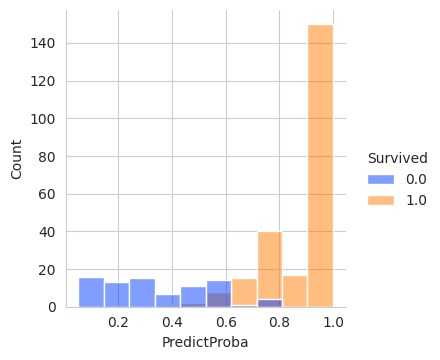

In [894]:
g = sns.displot(df_out.query("Split == 'Train' and Sex == 'female'"), x="PredictProba", hue="Survived", palette="bright", height=3.7)

In [897]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

tab = {
    "DT": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "TN": [],
    "TP": [],
    "FN": [],
    "FP": [],
}
decision_thresholds = np.arange(0.5, 0.71, 0.01)
y_true = df_out.query("Split == 'Train' and Sex == 'female'")["Survived"]
for dt in decision_thresholds:
    tab["DT"].append(dt)
    y_pred = df_out.query("Split == 'Train' and Sex == 'female'")["PredictProba"] >= dt
    tab["Accuracy"].append(round(accuracy_score(y_true, y_pred)*100,2))
    tab["Recall"].append(round(recall_score(y_true, y_pred, zero_division=np.nan)*100,2))
    tab["Precision"].append(round(precision_score(y_true, y_pred, zero_division=np.nan)*100,2))
    tab["F1"].append(round(f1_score(y_true, y_pred, zero_division=np.nan)*100,2))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tab["TN"].append(cm[0,0])
    tab["TP"].append(cm[1,1])
    tab["FN"].append(cm[1,0])
    tab["FP"].append(cm[0,1])

pd.DataFrame(tab)

,DT,Accuracy,Precision,Recall,F1,TN,TP,FN,FP
0,0.50,92.99,91.70,99.57,95.47,60,232,1,21
1,0.51,93.31,92.40,99.14,95.65,62,231,2,19
2,0.52,92.99,92.37,98.71,95.44,62,230,3,19
3,0.53,93.31,92.74,98.71,95.63,63,230,3,18
4,0.54,94.59,94.26,98.71,96.44,67,230,3,14
5,0.55,94.90,95.02,98.28,96.62,69,229,4,12
6,0.56,95.54,95.82,98.28,97.03,71,229,4,10
7,0.57,95.22,95.80,97.85,96.82,71,228,5,10
8,0.58,94.90,95.78,97.42,96.60,71,227,6,10
9,0.59,95.22,96.58,97.00,96.79,73,226,7,8


#### Mr - underestimating survival

In [498]:
features = ["Pclass", "AgeBin", "FareBin", "FamilySize"]
metric = "FN"
for control_feature in features:
    fp = df_out.query("Split == 'Train' and Title == 'Mr' and CM == @metric")[control_feature].value_counts().reset_index().rename(columns={"count": f"{metric.lower()}_count"})
    tot = df_out.query("Split == 'Train' and Title == 'Mr'")[control_feature].value_counts().reset_index().rename(columns={"count": "total_count"})
    merge = fp.merge(tot, on=control_feature)
    merge[f"{metric.lower()}_prop"] = (merge[f"{metric.lower()}_count"] / merge["total_count"]*100).round(2)
    merge = merge.sort_values(by=f"{metric.lower()}_prop", ascending=False)
    print(merge)
    print("-"*50)

   Pclass  fn_count  total_count  fn_prop
0       1        37          107    34.58
1       3        36          319    11.29
2       2         8           91     8.79
--------------------------------------------------
   AgeBin  fn_count  total_count  fn_prop
1      40        22           97    22.68
3      50        10           50    20.00
0      30        31          208    14.90
2       5        14          119    11.76
4     100         4           39    10.26
--------------------------------------------------
   FareBin  fn_count  total_count  fn_prop
4     1000         7           21    33.33
2       80        15           51    29.41
1       40        22           90    24.44
3       20         9           85    10.59
0       10        28          270    10.37
--------------------------------------------------
   FamilySize  fn_count  total_count  fn_prop
1           1        14           68    20.59
0           0        61          397    15.37
2           2         6        

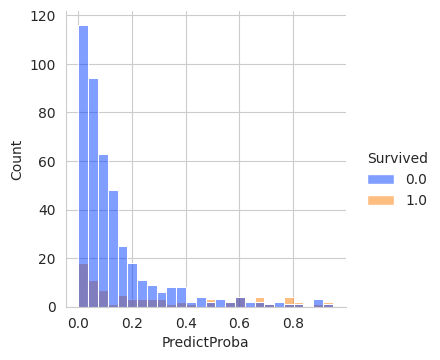

In [65]:
g = sns.displot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="PredictProba", hue="Survived", palette="bright", height=3.7)

In [500]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

tab = {
    "DT": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "TN": [],
    "TP": [],
    "FN": [],
    "FP": [],
}
decision_thresholds = np.arange(0.3, 0.51, 0.01)
y_true = df_out.query("Split == 'Train' and Title == 'Mr'")["Survived"]
for dt in decision_thresholds:
    tab["DT"].append(dt)
    y_pred = df_out.query("Split == 'Train' and Title == 'Mr'")["PredictProba"] >= dt
    tab["Accuracy"].append(round(accuracy_score(y_true, y_pred)*100,2))
    tab["Recall"].append(round(recall_score(y_true, y_pred, zero_division=np.nan)*100,2))
    tab["Precision"].append(round(precision_score(y_true, y_pred, zero_division=np.nan)*100,2))
    tab["F1"].append(round(f1_score(y_true, y_pred, zero_division=np.nan)*100,2))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tab["TN"].append(cm[0,0])
    tab["TP"].append(cm[1,1])
    tab["FN"].append(cm[1,0])
    tab["FP"].append(cm[0,1])

pd.DataFrame(tab)
    

,DT,Accuracy,Precision,Recall,F1,TN,TP,FN,FP
0,0.30,79.30,33.75,33.33,33.54,383,27,54,53
1,0.31,80.08,35.14,32.10,33.55,388,26,55,48
2,0.32,80.46,35.71,30.86,33.11,391,25,56,45
3,0.33,80.08,33.82,28.40,30.87,391,23,58,45
4,0.34,80.08,32.81,25.93,28.97,393,21,60,43
5,0.35,80.08,32.26,24.69,27.97,394,20,61,42
6,0.36,81.62,36.54,23.46,28.57,403,19,62,33
7,0.37,82.21,38.30,22.22,28.12,407,18,63,29
8,0.38,82.79,40.48,20.99,27.64,411,17,64,25
9,0.39,82.79,38.89,17.28,23.93,414,14,67,22


### Survival and prediction rate vs. features

In [66]:
print(df_out.query("Split == 'Train'").Survived.mean())
print(df_out.query("Split == 'Train'").Prediction.mean())
# (38.38-34.34)

0.3838383838383838
0.36475869809203143


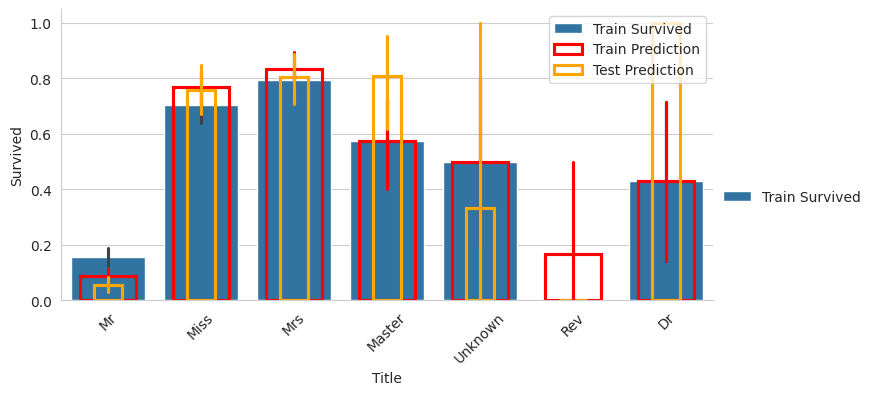

In [67]:
# Title
g = sns.catplot(df_out.query("Split == 'Train'"), kind="bar", x="Title", y="Survived", order=df_out.Title.value_counts().sort_values(ascending=False).index, height=3.7, aspect=2, fill=True, label="Train Survived")
_ = sns.barplot(df_out.query("Split == 'Train'"), x="Title", y="Prediction", label="Train Prediction", ax=g.ax, color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test'"), x="Title", y="Prediction", label="Test Prediction", ax=g.ax, color="orange", width=0.3, fill=False)
_ = g.ax.legend()
_ = g.ax.tick_params(axis="x", labelrotation=45)

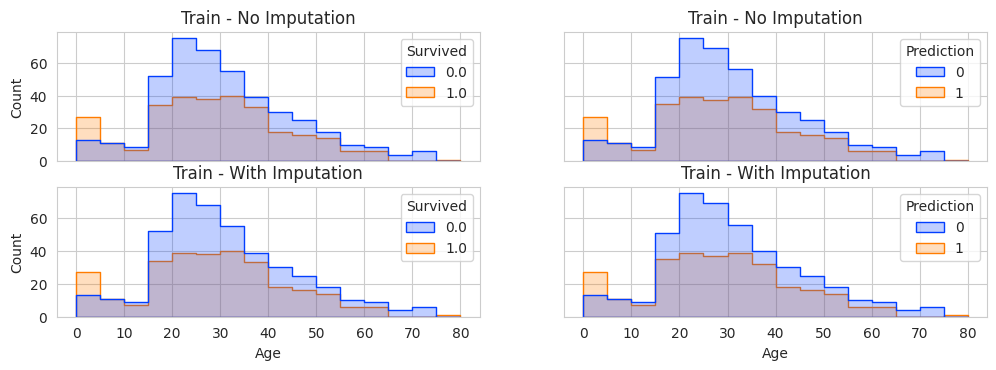

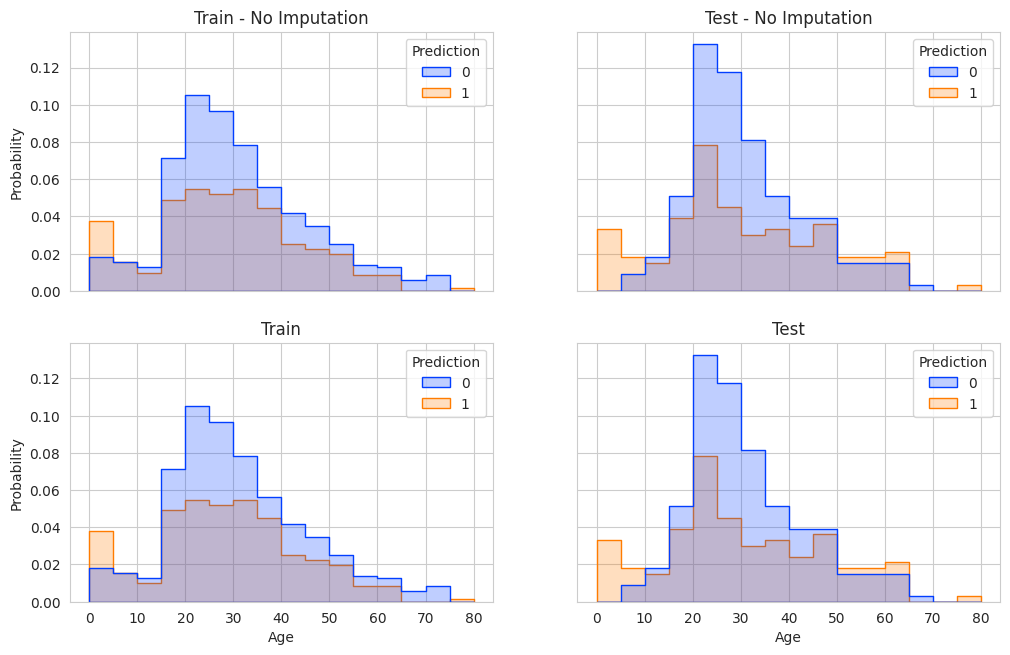

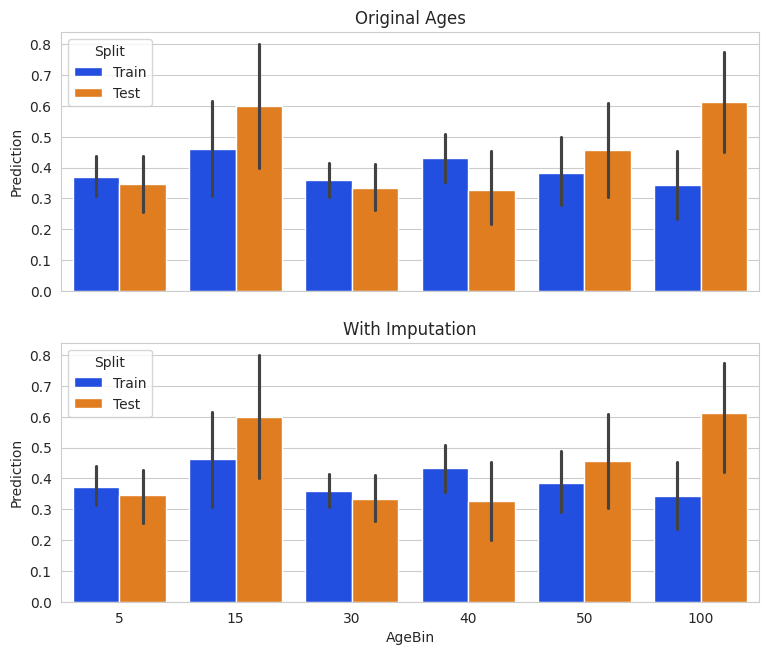

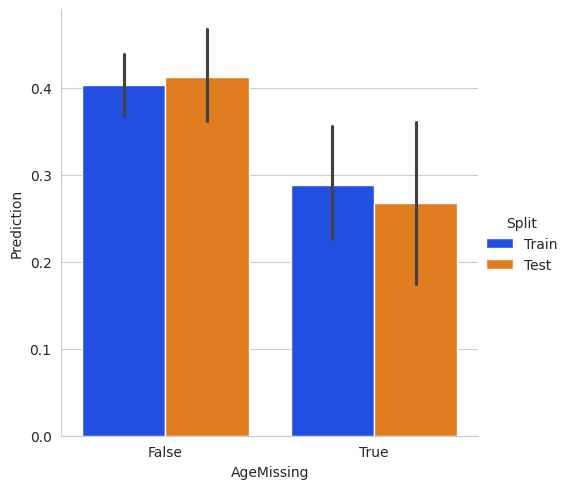

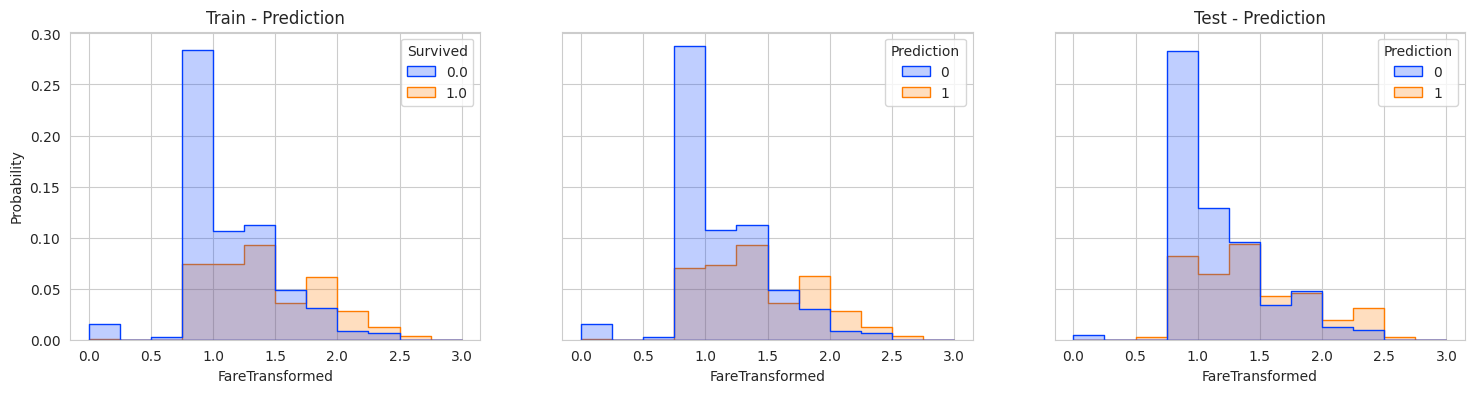

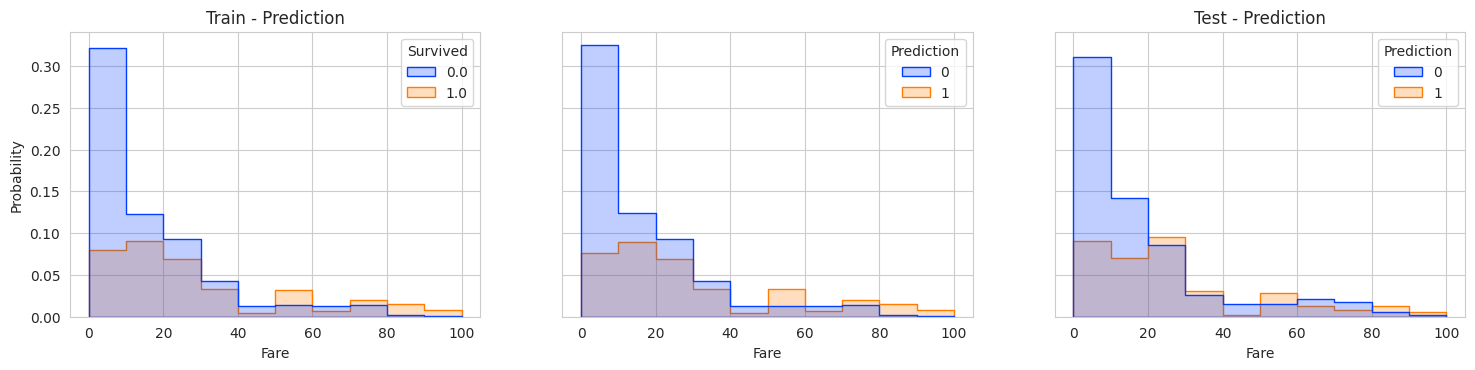

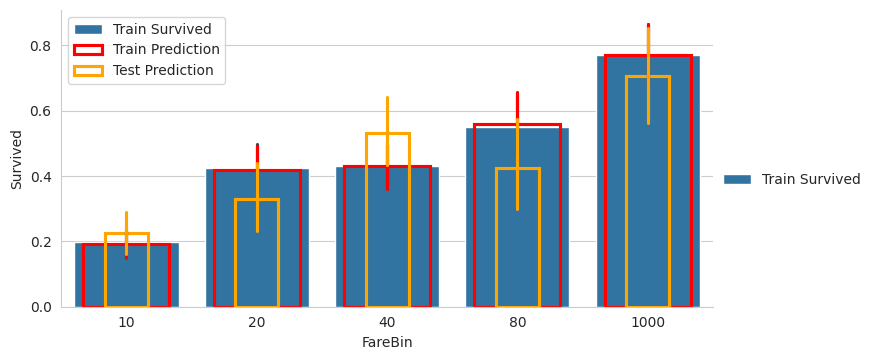

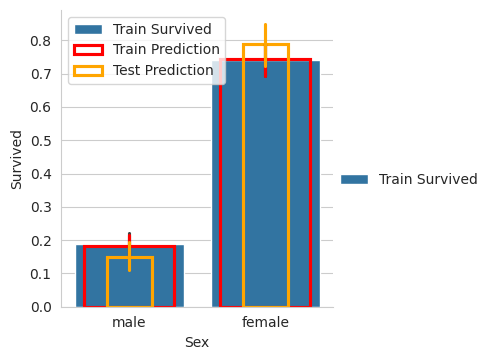

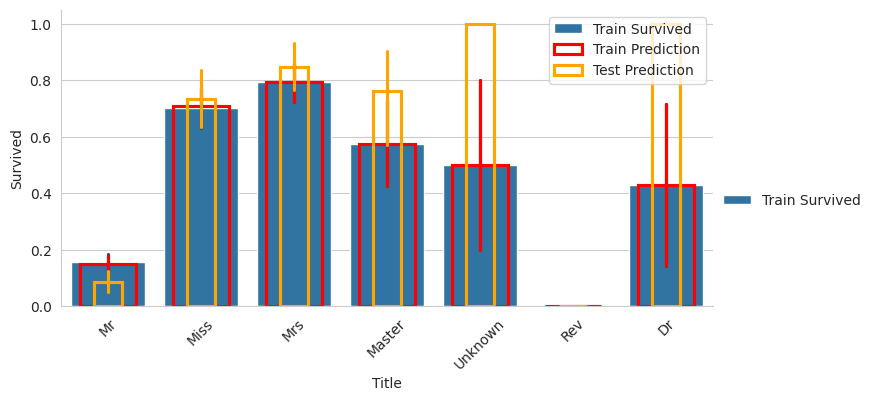

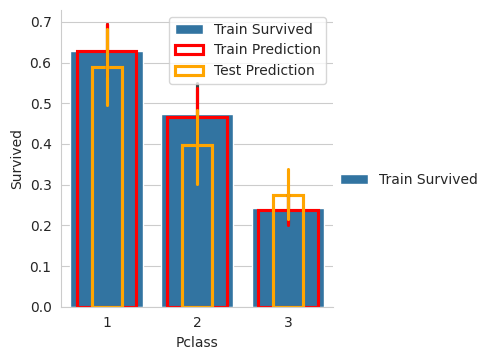

In [ ]:
# Age - not much difference between survival and prediction
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(6*2, 3.7), sharex=True, sharey=True)
_ = sns.histplot(df_out.query("Split == 'Train'"), x="AgeOG", hue="Survived", palette="bright", element="step", bins=range(0,85,5), ax=axs[0][0])
_ = sns.histplot(df_out.query("Split == 'Train'"), x="AgeOG", hue="Prediction", palette="bright", element="step", bins=range(0,85,5), ax=axs[0][1])
_ = sns.histplot(df_out.query("Split == 'Train'"), x="Age", hue="Survived", palette="bright", element="step", bins=range(0,85,5), ax=axs[1][0])
_ = sns.histplot(df_out.query("Split == 'Train'"), x="Age", hue="Prediction", palette="bright", element="step", bins=range(0,85,5), ax=axs[1][1])
_ = axs[0][0].set_title("Train - No Imputation")
_ = axs[0][1].set_title("Train - No Imputation")
_ = axs[1][0].set_title("Train - With Imputation")
_ = axs[1][1].set_title("Train - With Imputation")
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(6*2, 3.7*2), sharex=True, sharey=True)
_ = sns.histplot(df_out.query("Split == 'Train'"), x="AgeOG", hue="Prediction", element="step", bins=range(0,85,5), palette="bright", stat="probability", ax=axs[0][0])
_ = sns.histplot(df_out.query("Split == 'Test'"), x="AgeOG", hue="Prediction", element="step", bins=range(0,85,5), palette="bright", stat="probability", ax=axs[0][1])
_ = sns.histplot(df_out.query("Split == 'Train'"), x="Age", hue="Prediction", element="step", bins=range(0,85,5), palette="bright", stat="probability", ax=axs[1][0])
_ = sns.histplot(df_out.query("Split == 'Test'"), x="Age", hue="Prediction", element="step", bins=range(0,85,5), palette="bright", stat="probability", ax=axs[1][1])
_ = axs[0][0].set_title("Train - No Imputation")
_ = axs[0][1].set_title("Test - No Imputation")
_ = axs[1][0].set_title("Train")
_ = axs[1][1].set_title("Test")
f, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6*1.5, 3.7*2))
_ = sns.barplot(df_out, x="AgeOGBin", y="Prediction", hue="Split", palette="bright", ax=axs[0])
_ = sns.barplot(df_out, x="AgeBin", y="Prediction", hue="Split", palette="bright", ax=axs[1])
_ = axs[0].set_title("Original Ages")
_ = axs[1].set_title("With Imputation")
g = sns.catplot(df_out, x="AgeMissing", y="Prediction", kind="bar", hue="Split", palette="bright")

# Fare
f, axs = plt.subplots(ncols=3, figsize=(6*3, 4), sharex=True, sharey=True)
_ = sns.histplot(df_out.query("Split == 'Train'"), x="FareTransformed", hue="Survived", element="step", bins=np.arange(0,3.25,0.25), palette="bright", stat="probability", ax=axs[0])
_ = sns.histplot(df_out.query("Split == 'Train'"), x="FareTransformed", hue="Prediction", element="step", bins=np.arange(0,3.25,0.25), palette="bright", stat="probability", ax=axs[1])
_ = sns.histplot(df_out.query("Split == 'Test'"), x="FareTransformed", hue="Prediction", element="step", bins=np.arange(0,3.25,0.25), palette="bright", stat="probability", ax=axs[2])
_ = axs[0].set_title("Train - Survived")
_ = axs[0].set_title("Train - Prediction")
_ = axs[2].set_title("Test - Prediction")
f, axs = plt.subplots(ncols=3, figsize=(6*3, 3.7), sharex=True, sharey=True)
_ = sns.histplot(df_out.query("Fare <= 100 and Split == 'Train'"), x="Fare", hue="Survived", element="step", bins=range(0, 110, 10), palette="bright", stat="probability", ax=axs[0])
_ = sns.histplot(df_out.query("Fare <= 100 and Split == 'Train'"), x="Fare", hue="Prediction", element="step", bins=range(0, 110, 10), palette="bright", stat="probability", ax=axs[1])
_ = sns.histplot(df_out.query("Fare <= 100 and Split == 'Test'"), x="Fare", hue="Prediction", element="step", bins=range(0, 110, 10), palette="bright", stat="probability", ax=axs[2])
_ = axs[0].set_title("Train - Survived")
_ = axs[0].set_title("Train - Prediction")
_ = axs[2].set_title("Test - Prediction")
g = sns.catplot(df_out.query("Split == 'Train'"), x="FareBin", y="Survived", kind="bar", height=3.7, aspect=2, label="Train Survived")
_ = sns.barplot(df_out.query("Split == 'Train'"), x="FareBin", y="Prediction", color="red", fill=False, width=0.66, label="Train Prediction")
_ = sns.barplot(df_out.query("Split == 'Test'"), x="FareBin", y="Prediction", color="orange", fill=False, width=0.33, label="Test Prediction")
_ = g.ax.legend()

# Sex
g = sns.catplot(df_out.query("Split == 'Train'"), x="Sex", y="Survived", kind="bar", height=3.7, label="Train Survived")
_ = sns.barplot(df_out.query("Split == 'Train'"), x="Sex", y="Prediction", color="red", fill=False, width=0.66, label="Train Prediction")
_ = sns.barplot(df_out.query("Split == 'Test'"), x="Sex", y="Prediction", color="orange", fill=False, width=0.33, label="Test Prediction")
_ = g.ax.legend()

# Title
g = sns.catplot(df_out.query("Split == 'Train'"), kind="bar", x="Title", y="Survived", order=df_out.Title.value_counts().sort_values(ascending=False).index, height=3.7, aspect=2, fill=True, label="Train Survived")
_ = sns.barplot(df_out.query("Split == 'Train'"), x="Title", y="Prediction", label="Train Prediction", ax=g.ax, color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test'"), x="Title", y="Prediction", label="Test Prediction", ax=g.ax, color="orange", width=0.3, fill=False)
_ = g.ax.legend()
_ = g.ax.tick_params(axis="x", labelrotation=45)

# Pclass
g = sns.catplot(df_out.query("Split == 'Train'"), x="Pclass", y="Survived", kind="bar", height=3.7, label="Train Survived")
_ = sns.barplot(df_out.query("Split == 'Train'"), x="Pclass", y="Prediction", color="red", fill=False, width=0.66, label="Train Prediction")
_ = sns.barplot(df_out.query("Split == 'Test'"), x="Pclass", y="Prediction", color="orange", fill=False, width=0.33, label="Test Prediction")
_ = g.ax.legend()

# g = sns.catplot(df_out, x="FamilySize", y="Survived", kind="bar")
# # g = sns.displot(df_out, x="FamilySize", hue="Survived", element="step", discrete=True, palette="bright")
# # g = sns.catplot(df_out, x="SibSp", y="Survived", kind="bar")
# # g = sns.catplot(df_out, x="Parch", y="Survived", kind="bar")
# g = sns.catplot(df_out, x="Deck", y="Survived", kind="bar", order=sorted(df_out.Deck.unique()))
# g = sns.catplot(df_out, x="Embarked", y="Survived", kind="bar", order=df_out.Embarked.value_counts().sort_values(ascending=False).index)

### The problem with "Mr"

What's happening: the model predicts all "Mr" to die. Good prediction - most of them do die.
* Take a look at misclassification rate across all features to see which subsets are misclassified the most
    * I think it's important to look not just at misclassification, but which kind of misclassification - false negative or false positive. In "Mr" case, it's mostly false negative.
    * For "Mr", it's the older and wealthier that are misclassified (makes sense since loss is dominated by the larger population of younger and poor)
    * However, for "Mr", it's the misclassification of young, poor, single men that will have the most impact on accuracy since this is by far the majority demographic.
    * What does this mean? Should I weight the young, poor, single men even more?
* Even if the survival rate isn't actually 0%, it's like 10-15%. So we always predict that they die because it's not like we can randomly pick 15% of them to survive (unless we change our threshold). Exactly - when I check prediction probability across all "Mr" samples, the mean probability is 15%. This matches the survival rate, but the prediction rate is much lower (almost zero for the test set).
    * This is true for both train and test splits - prediction rate is much lower than actual survival rate (although test is worse)
* DO NOT USE test set for tuning the learning algorithm.
* Training and validation
    * Does it make sense to "weight" Title less? Or Sex less? I bet this is why you can't achieve better than 77%. The model is super fixated on these features (but what about feature importance?). Can you weight features less? Or weight specific samples less.
    * Does it make sense to use recall/precision/F1 score to evaluate generalization?
* Does it make sense to change threshold? Is that how RandomForestClassifier works?
    * Look at predict_proba distribution per Title. For Mr that survived, is predict_proba higher?
    * Look at recall and precision per Title.
* Changing decision threshold for "Mr" doesn't help - you end up overestimating survival rate for Pclass 1 and still underestimating survival for lower Pclass. More false positives, fewer false negatives; overall accuracy drops.
* Increasing sample weight for surviving "Mr" also doesn't help - it actually has the same effect as changing the decision threshold. Because now you really penalize false negatives, so you get fewer false negatives at the cost of more false positives.
* Double-check your original setup with stratification by Survived 
* mlflow experiment tracking/save models
* Try single-feature classification
* For the "Mr" that do survive, is there anything distinguishing them from the others? Is there some feature that predicts that they could survive?

Training:
* Try adding all features to let the model learn - revisit survival rate for "Mr" as a function of other features. Even if survival rate is less than 50%, any feature that increases survival rate is important. Hopefully this means that adding the feature and increasing the weight for surviving "Mr" will increase accuracy.
* Try increasing the weight for surviving "Mr"
* You can tune prediction thresholds after training

In [63]:
df_out.query("Title == 'Mr'").groupby("Split").Pclass.value_counts(normalize=True).sort_index().reset_index()

,Split,Pclass,proportion
0,Test,1,0.216667
1,Test,2,0.245833
2,Test,3,0.537500
3,Train,1,0.206963
4,Train,2,0.176015
5,Train,3,0.617021


In [64]:
(df_out.query("Split == 'Train'").groupby("Title").Survived.value_counts().sort_values(ascending=False)/len(df_train)*100).reset_index()

,Title,Survived,count
0,Mr,0.0,48.933782
1,Miss,1.0,14.590348
2,Mrs,1.0,11.223345
3,Mr,1.0,9.090909
4,Miss,0.0,6.172840
5,Mrs,0.0,2.918070
6,Master,1.0,2.581369
7,Master,0.0,1.907969
8,Rev,0.0,0.673401
9,Unknown,0.0,0.561167


In [ ]:
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("Pclass").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("AgeBin").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("FareBin").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("FamilySize").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("SibSp").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("Parch").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("AgeMissing").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("Embarked").Misclassified.agg(["count", "mean"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("Deck").Misclassified.agg(["count", "mean"]))
print("")

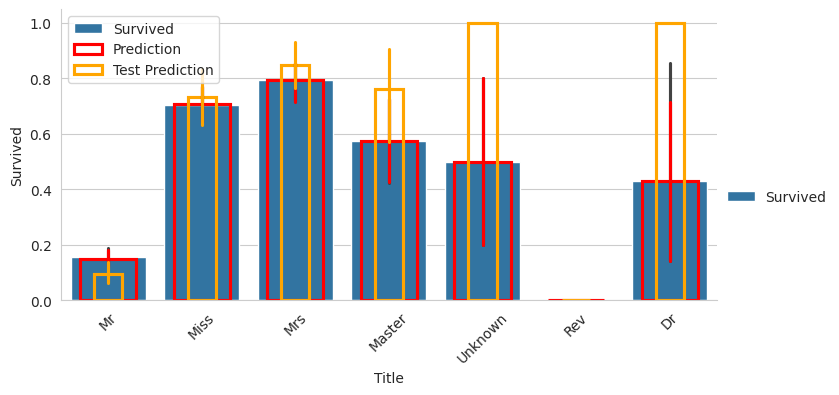

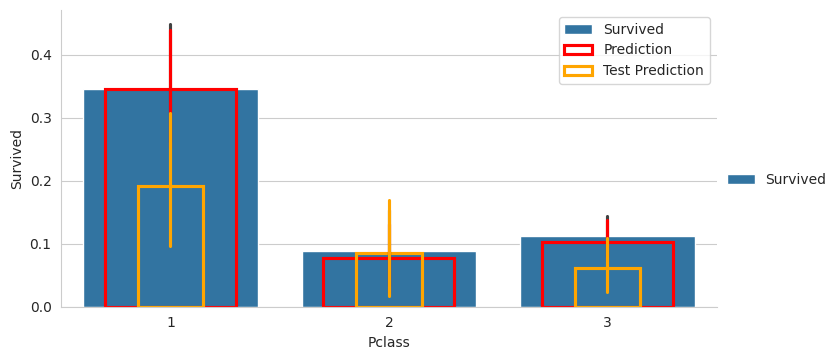

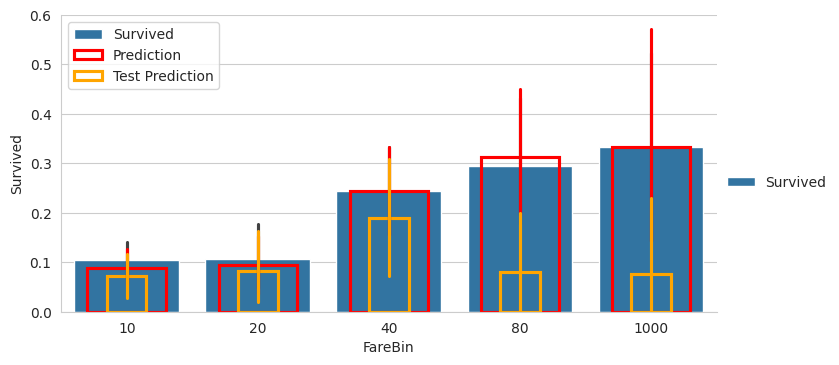

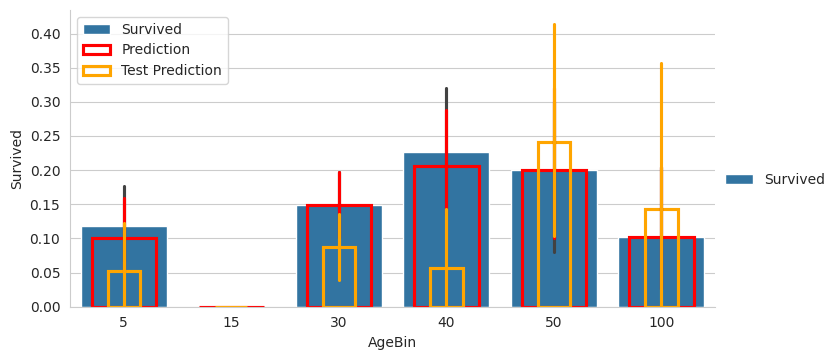

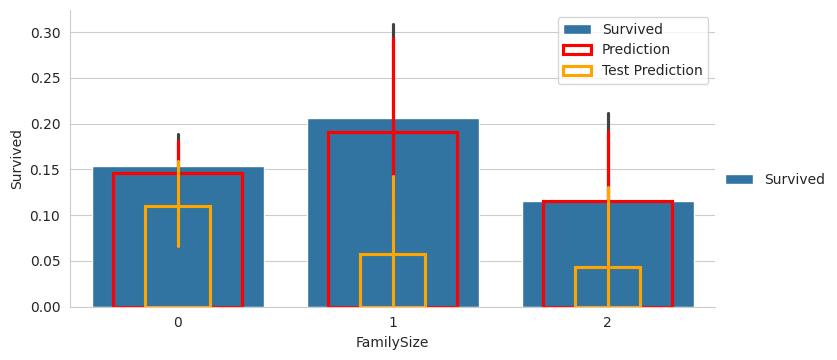

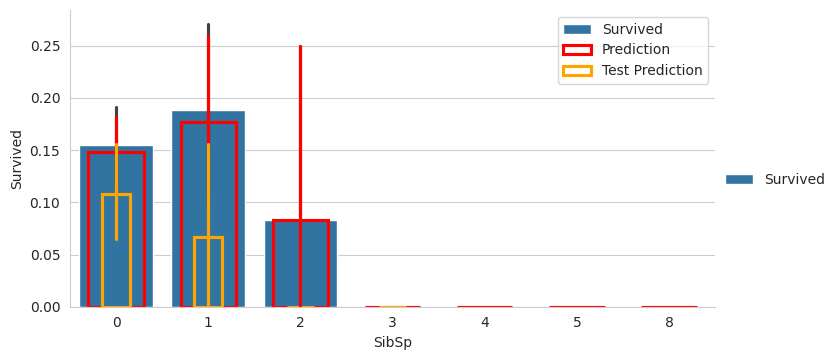

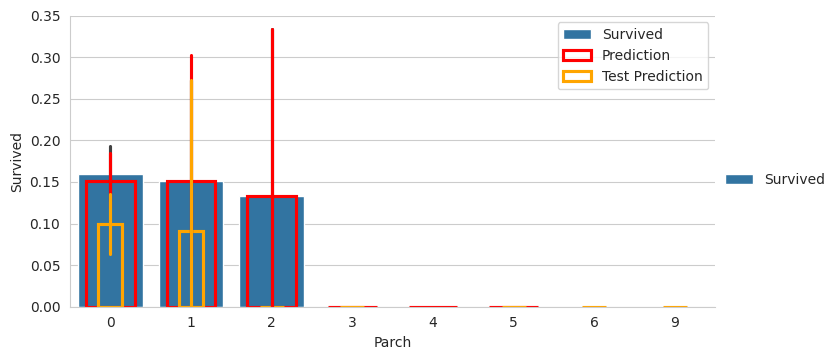

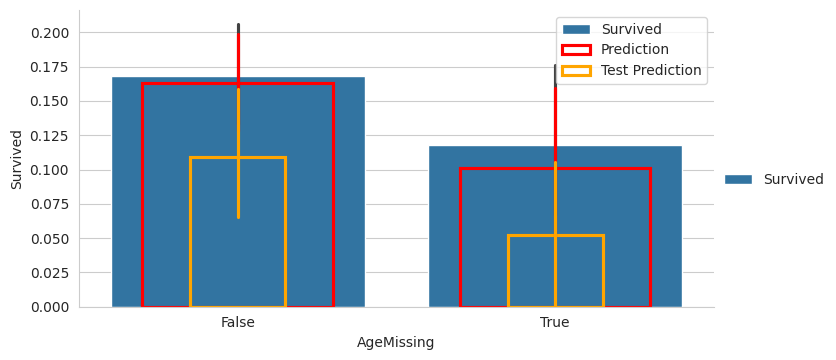

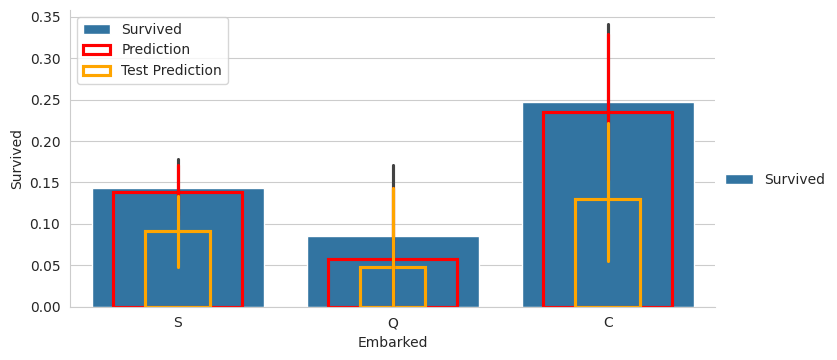

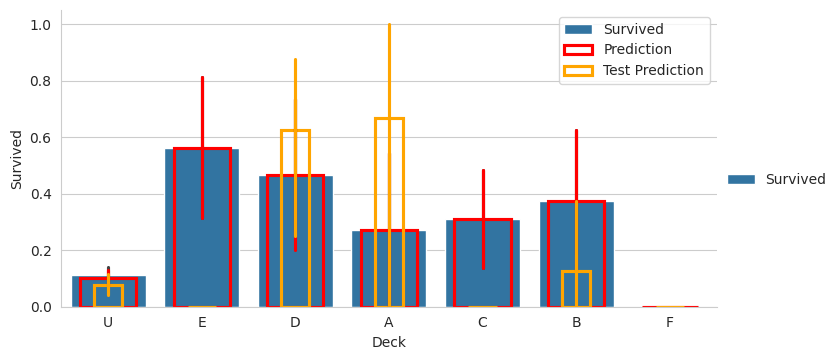

In [382]:
# Take a closer look at Title == Mr
g = sns.catplot(df_out.query("Split == 'Train'"), kind="bar", x="Title", y="Survived", order=df_out.Title.value_counts().sort_values(ascending=False).index, height=3.7, aspect=2, fill=True, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train'"), x="Title", y="Prediction", label="Prediction", ax=g.ax, color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test'"), x="Title", y="Prediction", label="Test Prediction", ax=g.ax, color="orange", width=0.3, fill=False)
_ = g.ax.legend()
_ = g.ax.tick_params(axis="x", labelrotation=45)
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Pclass", order=[1,2,3], y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="Pclass", order=[1,2,3], y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="Pclass", order=[1,2,3], y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="FareBin", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="FareBin", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="FareBin", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="AgeBin", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="AgeBin", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="AgeBin", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()

# The features below were not used in training
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="FamilySize", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="FamilySize", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="FamilySize", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="SibSp", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="SibSp", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="SibSp", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Parch", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="Parch", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="Parch", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="AgeMissing", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="AgeMissing", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="AgeMissing", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Embarked", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="Embarked", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="Embarked", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Deck", y="Survived", height=3.7, aspect=2, label="Survived")
_ = sns.barplot(df_out.query("Split == 'Train' and Title == 'Mr'"), x="Deck", y="Prediction", ax=g.ax, label="Prediction", color="red", width=0.6, fill=False)
_ = sns.barplot(df_out.query("Split == 'Test' and Title == 'Mr'"), x="Deck", y="Prediction", ax=g.ax, label="Test Prediction", color="orange", width=0.3, fill=False)
_ = g.ax.legend()

count    517.000000
mean       0.156673
std        0.363844
Name: Survived, dtype: float64

       count      mean       std
Split                           
Test     240  0.025000  0.156451
Train    517  0.048356  0.214725

       count      mean    median       std
Split                                     
Test     240  0.152170  0.108518  0.114151
Train    517  0.156944  0.100008  0.140638


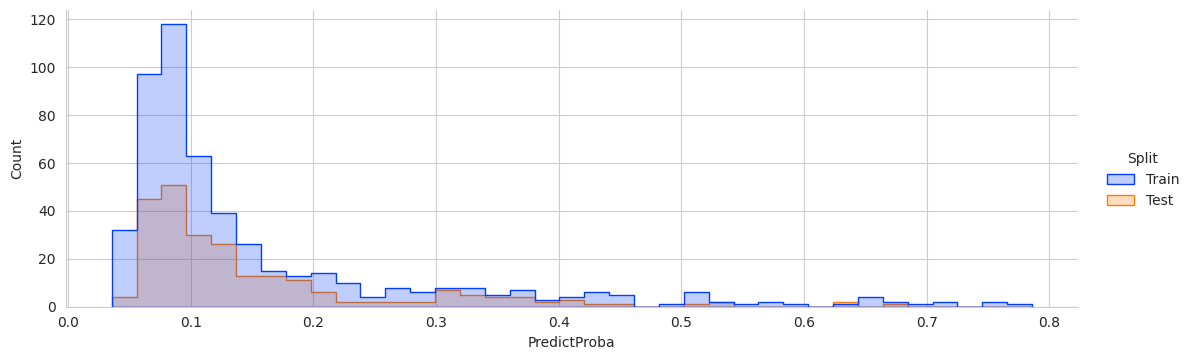

In [64]:
print(df_out.query("Title == 'Mr' and Split == 'Train'").Survived.agg(["count", "mean", "std"]))
print("")
print(df_out.query("Title == 'Mr'").groupby("Split").Prediction.agg(["count", "mean", "std"]))
print("")
print(df_out.query("Title == 'Mr'").groupby("Split").PredictProba.agg(["count", "mean", "median", "std"]))
g = sns.displot(df_out.query("Title == 'Mr'"), kind="hist", x="PredictProba", hue="Split", palette="bright", height=3.7, aspect=3, element="step")

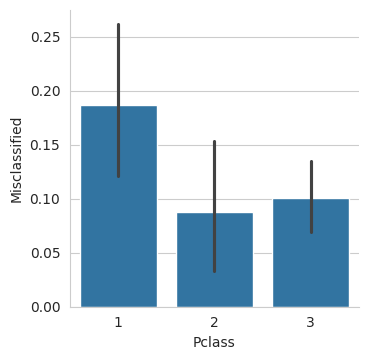

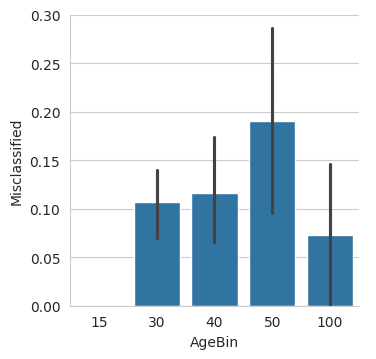

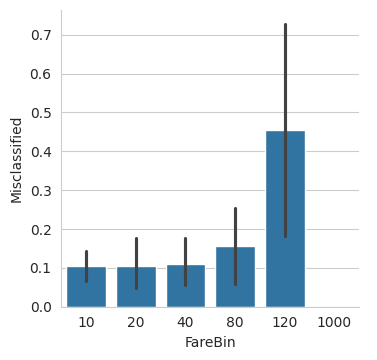

In [648]:
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Pclass", y="Misclassified", height=3.7)
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="AgeBin", y="Misclassified", height=3.7)
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="FareBin", y="Misclassified", height=3.7)

### What distinguishes a "Mr" survivor?

* For sure Pclass, Age, Fare
* Survival rate seems slightly higher for "Mr" with FamilySize=1
* Deck/Embarked are highly correlated with Pclass - ignore

In [742]:
df_out.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Prediction', 'PredictProba',
       'Misclassified', 'Split', 'AgeMissing', 'AgeOG', 'FamilySize', 'Title',
       'Deck', 'FareTransformed', 'AgeOGBin', 'AgeBin', 'FareBin'],
      dtype='object')

In [759]:
avg_surv_rate_mr = df_out.query("Split == 'Train' and Title == 'Mr'").Survived.mean()

In [774]:
print(df_out.query("Split == 'Train' and Title == 'Mr'").Survived.agg(["count", "mean", "std"]))
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("FareBin").Survived.agg(["count", "mean", "std"]).sort_index())
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("AgeBin").Survived.agg(["count", "mean", "std"]).sort_index())
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("Pclass").Survived.agg(["count", "mean", "std"]).sort_index())
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("FamilySize").Survived.agg(["count", "mean", "std"]).sort_index())
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("Embarked").Survived.agg(["count", "mean", "std"]).sort_index())
print("")
print(df_out.query("Split == 'Train' and Title == 'Mr'").groupby("Deck").Survived.agg(["count", "mean", "std"]).sort_index())
print("")

count    517.000000
mean       0.156673
std        0.363844
Name: Survived, dtype: float64

         count      mean       std
FareBin                           
10         270  0.103704  0.305442
20          85  0.105882  0.309513
40          90  0.244444  0.432165
80          51  0.294118  0.460179
1000        21  0.333333  0.483046

        count      mean       std
AgeBin                           
15          4  0.000000  0.000000
30        271  0.136531  0.343987
40        138  0.181159  0.386553
50         63  0.238095  0.429339
100        41  0.097561  0.300406

        count      mean       std
Pclass                           
1         107  0.345794  0.477865
2          91  0.087912  0.284736
3         319  0.112853  0.316910

            count      mean       std
FamilySize                           
0             397  0.153652  0.361070
1              68  0.205882  0.407351
2              52  0.115385  0.322603

          count      mean       std
Embarked                 

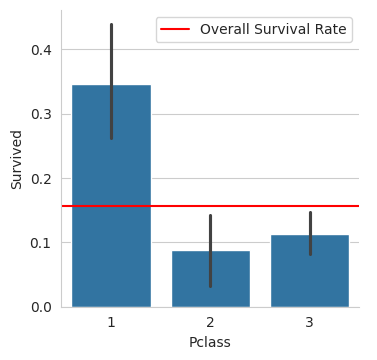

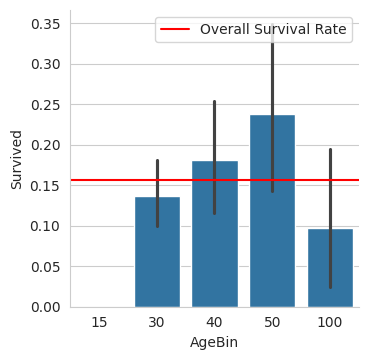

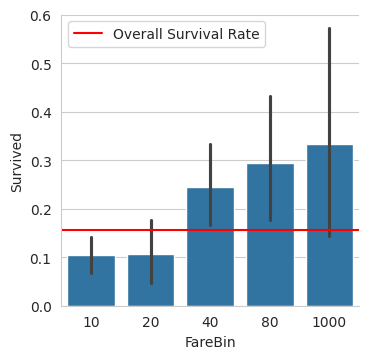

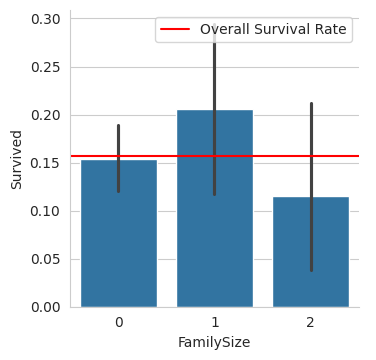

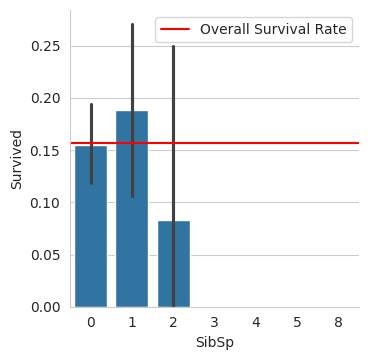

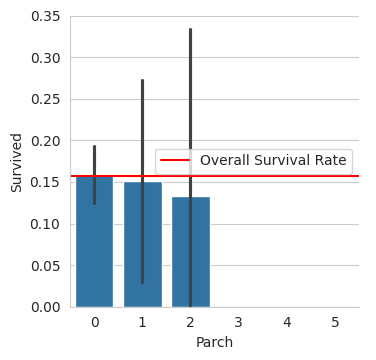

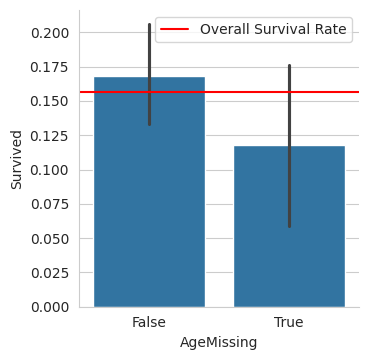

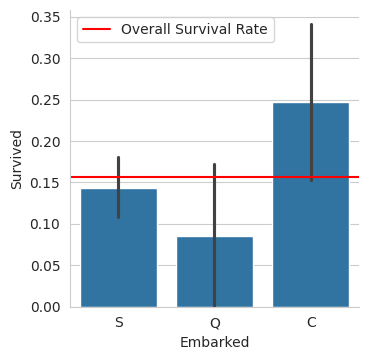

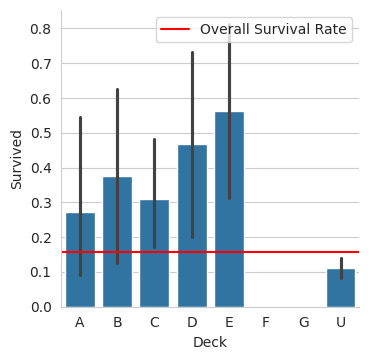

In [775]:
# What distinguishes a Mr that survives?

g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Pclass", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="AgeBin", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="FareBin", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
# g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="AgeBin", y="Survived", col="Pclass", height=3.7)
# g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="FareBin", y="Survived", col="Pclass", height=3.7)
# g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="FareBin", y="Survived", row="AgeBin", col="Pclass", height=3, aspect=2)
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="FamilySize", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="SibSp", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Parch", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="AgeMissing", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Embarked", y="Survived", height=3.7)
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()
g = sns.catplot(df_out.query("Split == 'Train' and Title == 'Mr'"), kind="bar", x="Deck", y="Survived", height=3.7, order=sorted(df_out.Deck.unique()))
_ = g.ax.axhline(y=avg_surv_rate_mr, label="Overall Survival Rate", color="red")
_ = g.ax.legend()

# Sanity-check the train-test distributions

In [329]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")
df_train["Split"] = "Train"
df_test["Split"] = "Test"
df = pd.concat((df_train, df_test), axis=0).reset_index(drop=True)

In [330]:
from custom_transformers import DynamicDataPrepPipeline
from sklearn.ensemble import RandomForestRegressor

data_prep_pipe = DynamicDataPrepPipeline(extract_fam=True, extract_title=True)
data_prep_pipe = DynamicDataPrepPipeline(extract_fam=True, extract_title=True, age_imputer_model=RandomForestRegressor(max_depth=10, random_state=0),
                                         impute_age_kwargs={"add_indicator": True, "feature_names": {"numeric": {"FamilySize", "SibSp", "Pclass", "FareTransformed"}, "ordinal": {"Sex"}, "onehot": {"Title"}}})
data_prep_pipe.fit(df_train)
df_train_out = data_prep_pipe.feature_extractor_.transform(df_train)
data_prep_pipe.fit(df_test)
df_test_out = data_prep_pipe.feature_extractor_.transform(df_test)

df_out = pd.concat((df_train_out, df_test_out), axis=0).reset_index(drop=True)
df_out["AgeOG"] = df["Age"]

print(df_out.shape)
print(df_out.columns)

(1309, 16)
Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Split', 'FamilySize', 'Title',
       'FareTransformed', 'Age_Missing', 'AgeOG'],
      dtype='object')


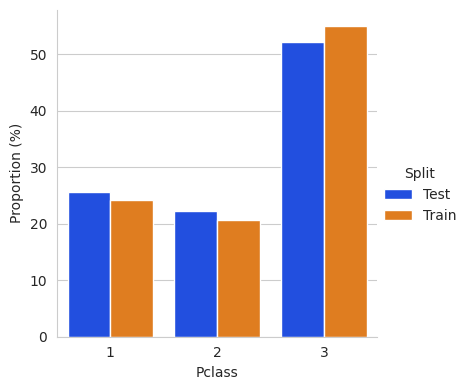

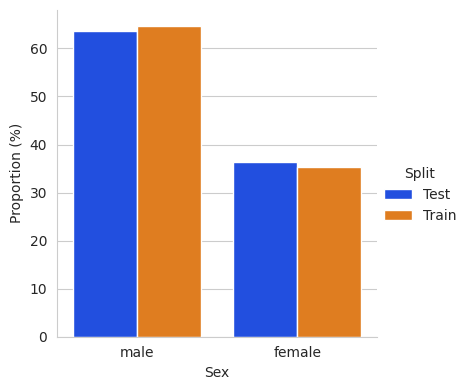

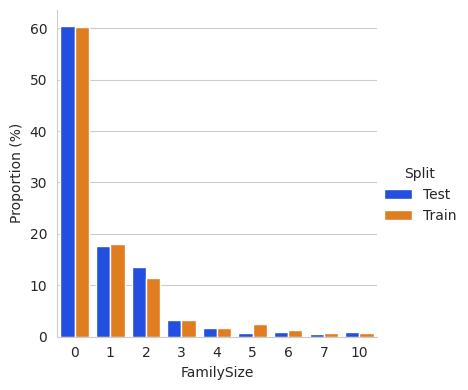

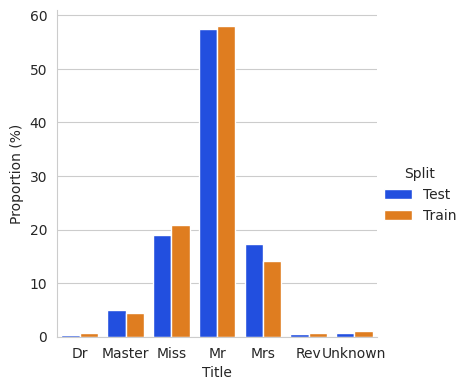

In [331]:
pclass_dist = (df_out.groupby("Split").Pclass.value_counts(normalize=True).sort_index()*100).reset_index()
sex_dist = (df_out.groupby("Split").Sex.value_counts(normalize=True)*100).reset_index()
fam_dist = (df_out.groupby("Split").FamilySize.value_counts(normalize=True).sort_index()*100).reset_index()
title_dist = (df_out.groupby("Split").Title.value_counts(normalize=True).sort_index()*100).reset_index()

g = sns.catplot(pclass_dist, kind="bar", x="Pclass", y="proportion", hue="Split", palette="bright", height=4)
_ = g.ax.set_ylabel("Proportion (%)")
g = sns.catplot(sex_dist, kind="bar", x="Sex", y="proportion", hue="Split", palette="bright", height=4)
_ = g.ax.set_ylabel("Proportion (%)")
g = sns.catplot(fam_dist, kind="bar", x="FamilySize", y="proportion", hue="Split", palette="bright", height=4)
_ = g.ax.set_ylabel("Proportion (%)")
g = sns.catplot(title_dist, kind="bar", x="Title", y="proportion", hue="Split", palette="bright", height=4)
_ = g.ax.set_ylabel("Proportion (%)")

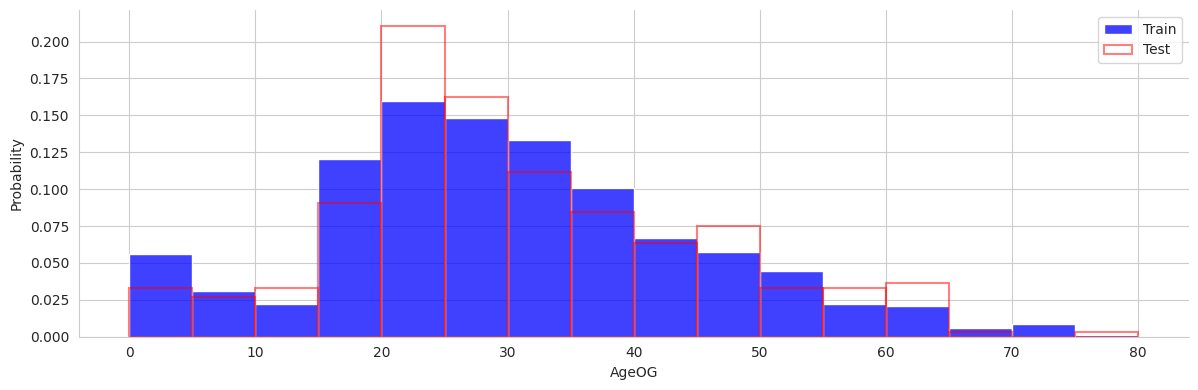

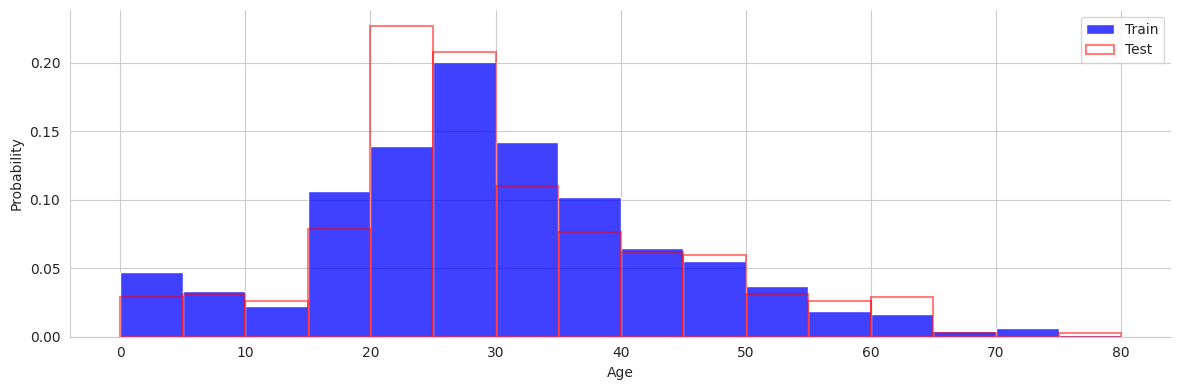

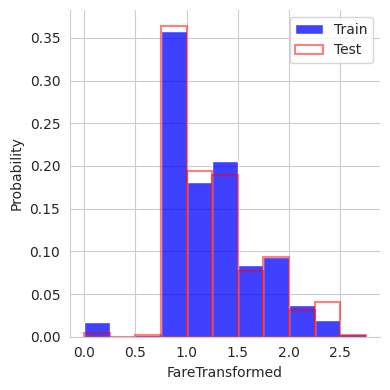

In [332]:
g = sns.displot(df_out.query("Split == 'Train'"), kind="hist", x="AgeOG", bins=range(0,85,5), height=4, aspect=3, label="Train", stat="probability", color="blue")
_ = sns.histplot(df_out.query("Split == 'Test'"), x="AgeOG", bins=range(0,85,5), color="red", alpha=0.5, label="Test", stat="probability", ax = g.ax, fill=False)
_ = g.ax.legend()
g = sns.displot(df_out.query("Split == 'Train'"), kind="hist", x="Age", bins=range(0,85,5), height=4, aspect=3, label="Train", stat="probability", color="blue")
_ = sns.histplot(df_out.query("Split == 'Test'"), x="Age", bins=range(0,85,5), color="red", alpha=0.5, label="Test", stat="probability", ax = g.ax, fill=False)
_ = g.ax.legend()
g = sns.displot(df_out.query("Split == 'Train'"), kind="hist", x="FareTransformed", bins=np.arange(0, 3, 0.25), height=4, label="Train", stat="probability", color="blue")
_ = sns.histplot(df_out.query("Split == 'Test'"), x="FareTransformed", bins=np.arange(0, 3, 0.25), color="red", alpha=0.5, label="Test", stat="probability", ax = g.ax, fill=False)
_ = g.ax.legend()

       count      mean       std       min       25%       50%       75%  \
Split                                                                      
Test   332.0  5.982517  4.663007  0.046121  2.500229  5.027340  8.047415   
Train  714.0  6.454360  5.897722  0.005500  2.258022  4.899704  8.846023   

             max  
Split             
Test   28.348427  
Train  46.088358  

Split      
Test   0.50     5.027340
       0.75     8.047415
       0.90    12.293159
       0.95    14.828642
       0.99    20.019194
Train  0.50     4.899704
       0.75     8.846023
       0.90    14.298822
       0.95    17.339964
       0.99    29.469891
Name: MAE, dtype: float64



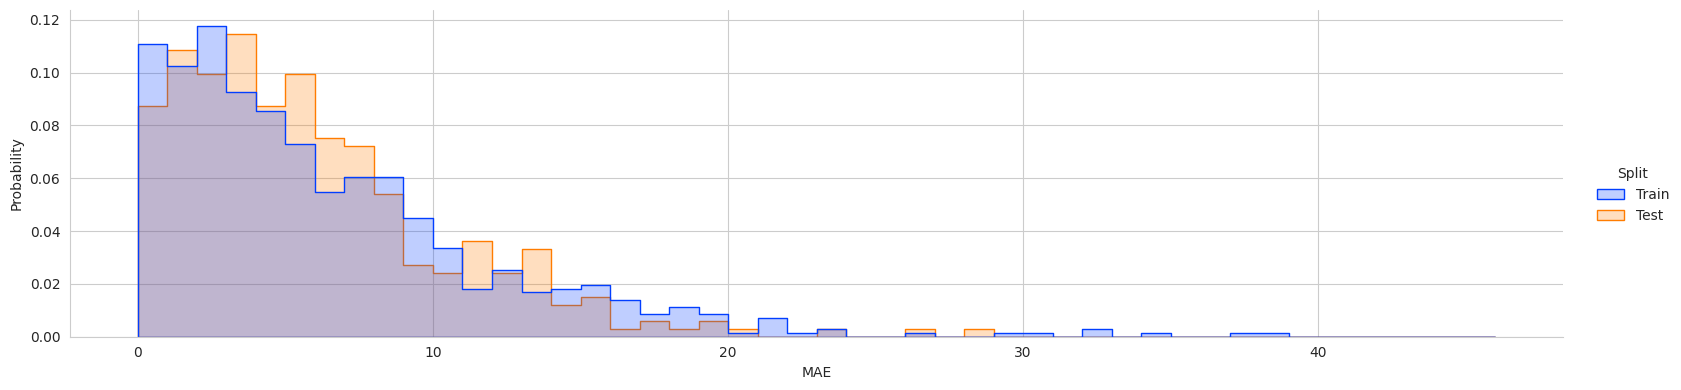

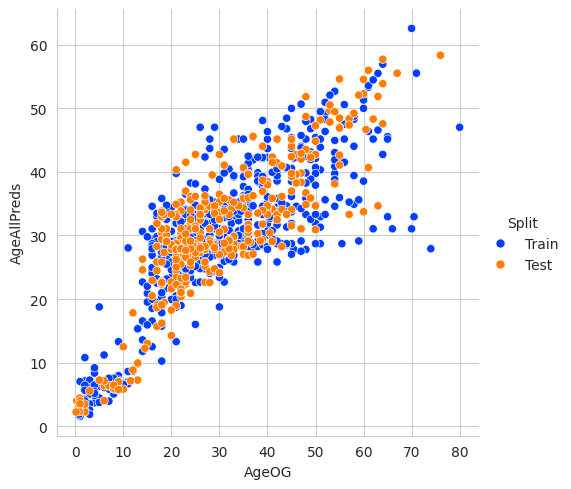

In [403]:
y_preds = data_prep_pipe.feature_extractor_.named_steps["age_imputer"].pipeline_.predict(df_out)

df_all_preds = df_out.copy()
df_all_preds["AgeAllPreds"] = y_preds
df_all_preds["MAE"] = df_all_preds["AgeOG"]
not_missing_mask = df_all_preds["MAE"].notna()
df_all_preds.loc[not_missing_mask, "MAE"] = np.abs(df_all_preds.loc[not_missing_mask, "AgeOG"] - df_all_preds.loc[not_missing_mask, "AgeAllPreds"])

print(df_all_preds.groupby("Split")["MAE"].describe())
print("")
print(df_all_preds.groupby("Split")["MAE"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))
print("")
g = sns.displot(df_all_preds, kind="hist", x="MAE", hue="Split", palette="bright", element="step", height=4, aspect=4, 
                stat="probability", common_norm=False, bins=range(0,np.ceil(df_all_preds["MAE"].max()).astype("int").item()))
g = sns.relplot(df_all_preds.loc[not_missing_mask], kind="scatter", x="AgeOG", y="AgeAllPreds", hue="Split", palette="bright")